The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Sep 15 2021

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

astropy               : 4.2.1
exoplanet             : 0.5.1
arviz                 : 0.11.2
numpy                 : 1.20.1
aesara_theano_fallback: 0.0.4
corner                : 2.2.1
matplotlib            : 3.3.4
pymc3                 : 3.11.4
pymc3_ext             : 0.1.0
celerite2             : 0.2.0
seaborn               : 0.11.1
starry                : 1.1.2
pandas                : 1.3.2

Watermark: 2.2.0



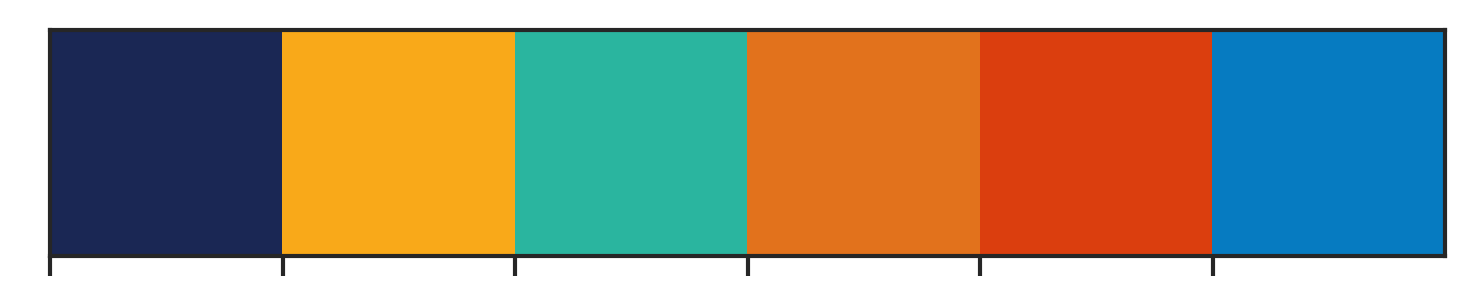

In [557]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import starry
starry.config.lazy = True
starry.config.quiet = True

import time as timer
import pandas as pd

import arviz as az
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

import astropy.units as u
import astropy.constants as c

import corner
from sklearn.neighbors import KernelDensity

from astropy.time import Time

import seaborn as sns

sns.set_theme(context='paper', 
              style='ticks', 
              font='sans-serif', 
              font_scale=1.1)


tangerine = ['#1a2754','#f9a919','#2ab59f','#e2721c','#db3e0e','#067bc1']

sns.set_palette(tangerine)
sns.palplot(tangerine)

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = 4,3
mpl.rcParams['legend.fancybox'] = False
#     mpl.rcParams['lines.linewidth'] = 0.5
#     mpl.rcParams['lines.markersize'] = 3


kde_kws = {"levels": 4, "alpha": 0.5}
ebar_kwargs = {"fmt":"o", "ms":3, "mfc":"None", "lw":0.5, "mew":0.5}
ebar_kwargs = {"fmt":"o", "ms":3, "mfc":"None", "lw":1, "mew":1}


%watermark -n -u -v -iv -w

In [558]:
def Keplers_Third_A(Period, M1, M2=None):
    # Period in [days]
    # M1, M2 in [Solar masses]
    P = Period*u.day.to(u.second)    
    
    if M2:
        GMtot = (M1+M2)*c.GM_sun.cgs.value
    else:
        GMtot = M1*c.GM_sun.cgs.value
    
    a  = (P**2.0 * GMtot/(4.0*np.pi**2.0))**(1.0/3.0)
    return a

def cosi_from_b(b, a_R, ecc=0.0, omega=np.pi/2.0):
    return b/a_R*(1.0+ecc*np.sin(omega))/(1.0-ecc**2.0)

def t14(P, a_R, ror, b, sini):
    return P/np.pi * np.arcsin(1./a_R * np.sqrt((1.+ror)**2. - b**2.)/sini)

#Stellar parameters
M_star = 1.10, 0.05
R_star = 1.305, 0.07

V1298 = {'per': [24.141445, 0.000056],
         't0': [2454833.0+2234.046461, 0.002141],
         'tmid': [2458781.08691, 0.005824],
         'rprs': [0.0700, 0.0023],
         'vsini': [25.24, 1], 
         'prot': [2.865, 0.012],
         'mstar': [1.10, 0.05],
         'rstar': [1.305, 0.070],
         'mp': 1e-5,
         'ecc': 0.,
         'omega': 90.,
         'ip': [89.0,0.5],
         't14': 6.42/24.0}

#We subtract a constant time offset from all observations, to be added back in at the end
time_offset = V1298['t0'][0]+71.*V1298['per'][0]

Median RV exposure time [minutes]: 5.480832606554031


<ipython-input-573-c53981be0116>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pepsi['inst_id'][red] = 'pepsi_r'


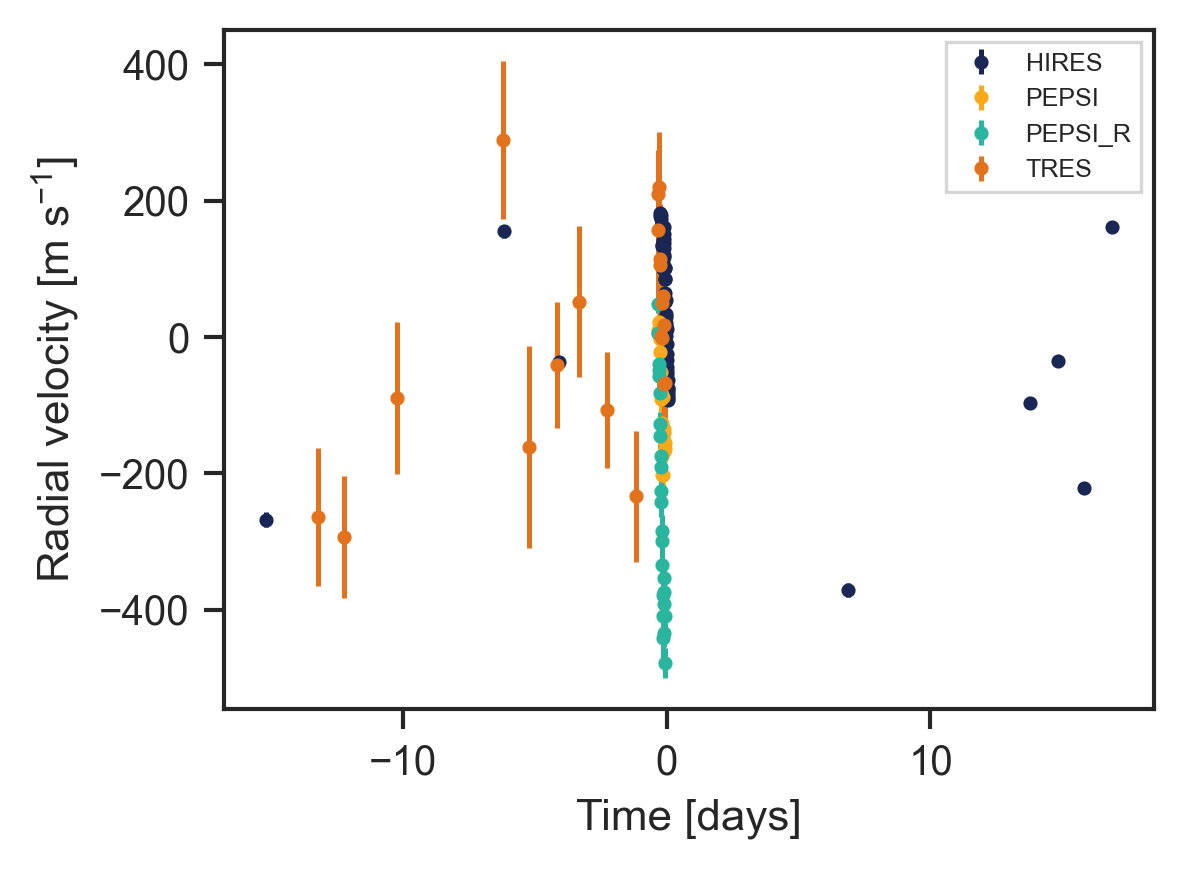

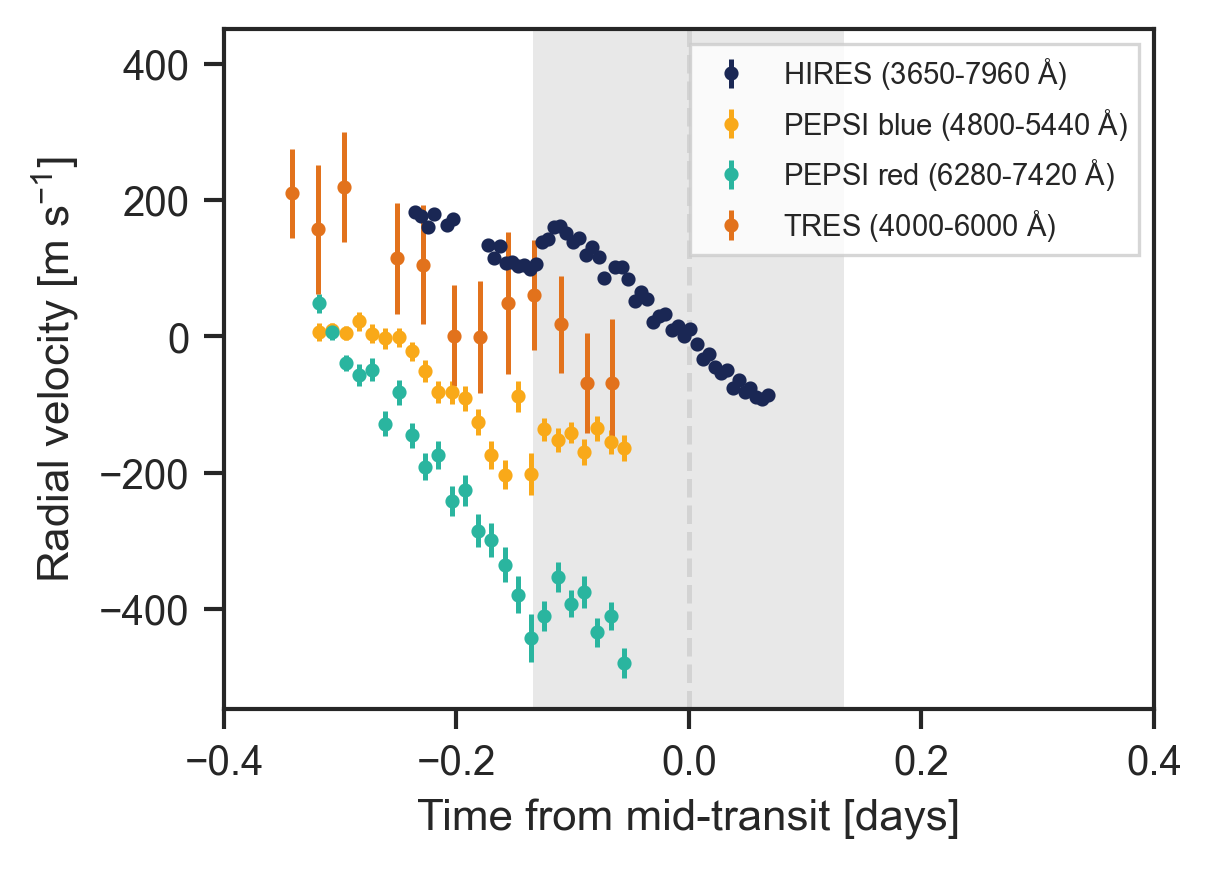

In [573]:
def get_rvs(instruments='all'):

    # Keck/HIRES radial velocities from California Planet Search
    hires = pd.read_csv('../data/hires.csv', comment='#')
    hires['time'] = hires['bjd']-time_offset
    hires['rv'] = hires['mnvel']
    hires['err'] = hires['errvel']
    hires['inst_id'] = ['hires']*len(hires)
    hires_flag = np.zeros(len(hires), dtype=bool)

    # FLWO/TRES radial velocities from George Zhou
    tres = pd.read_csv('../data/tres.csv')
    tres['time'] = tres['bjd_tdb']-time_offset
    tres['rv'] = 1e3*(tres['rv']-np.median(tres['rv']))
    tres['err'] = 1e3*tres['rverr']
    tres_flag = np.ones(len(tres), dtype=bool)
    tres_flag[np.argmin(tres['rv'])] = False
    
    # Remove bad data point
    tres['time'] = tres['time'][tres_flag]
    tres['rv'] = tres['rv'][tres_flag]
    tres['err'] = tres['err'][tres_flag]
    tres['inst_id'] = ['tres']*len(tres['time'])

    # PEPSI radial velocities from Ilya Ilin
    pepsi = pd.read_csv('../data/pepsi.csv')
    pepsi['bjd'] = pepsi['hjd_obs']
    pepsi['bjd'] += 0.5*15.0*u.minute.to(u.day) #double check this
    
    pepsi['time'] = pepsi['bjd']-time_offset
    pepsi['chip'] = [fn[5] for fn in pepsi['filename']]

    blue = pepsi['chip']=='b'
    red  = pepsi['chip']=='r'
    pepsi['inst_id'] = ['pepsi']*len(pepsi)
    pepsi['inst_id'][red] = 'pepsi_r'

    # Compute average RV between the red and blue chips of PEPSI
    pepsi_avgrv = np.mean([np.array(pepsi['rv'][red]), np.array(pepsi['rv'][blue])], axis=0)
    pepsi_avgrverr = np.sqrt(np.array(pepsi['erv'][red])**2. + np.array(pepsi['erv'][blue])**2.)
        
    # Concatenate RVs
    if instruments=='all':
        x_rv = list(hires['time'])+list(tres['time'])+list(pepsi['time'])
        y_rv = list(hires['mnvel'])+list(tres['rv'])+list(pepsi['rv'])
        yerr_rv = list(hires['errvel'])+list(tres['err'])+list(pepsi['erv'])
        inst_id = list(hires['inst_id'])+list(tres['inst_id'])+list(pepsi['inst_id'])
    
    elif instruments=='hires':
        x_rv = list(hires['time'])
        y_rv = list(hires['mnvel'])
        yerr_rv = list(hires['errvel'])
        inst_id = list(hires['inst_id'])
        
    x_rv = np.ascontiguousarray(x_rv, dtype=np.float64)
    y_rv = np.ascontiguousarray(y_rv, dtype=np.float64)
    yerr_rv = np.ascontiguousarray(yerr_rv, dtype=np.float64)
    inst_id = np.ascontiguousarray(inst_id, dtype=str)

    # RVs must be sorted for GP modeling
    arg = np.argsort(x_rv)
    x_rv = x_rv[arg]
    y_rv = y_rv[arg]
    yerr_rv = yerr_rv[arg]
    inst_id = inst_id[arg]


    texp_rv = np.median(np.diff(x_rv[abs(x_rv)<0.25]))
    print('Median RV exposure time [minutes]:', texp_rv*24.*60.)

    for inst in np.unique(inst_id):
        arg = inst_id == inst
        plt.errorbar(x_rv[arg], y_rv[arg], yerr=yerr_rv[arg], fmt=".", label=inst.upper())

    plt.xlabel("Time [days]")
    plt.ylabel("Radial velocity [m s$^\mathregular{-1}$]")
    plt.legend(prop={'size':6}, loc='upper right')
    plt.show()
    
    
    
    #Instruments plot for paper
    inst_labels = [r'HIRES (3650-7960 $\mathregular{\AA}$)', 
               'PEPSI blue (4800-5440 $\mathregular{\AA}$)', 
               'PEPSI red (6280-7420 $\mathregular{\AA}$)', 
               'TRES (4000-6000 $\mathregular{\AA}$)']

    #for inst in np.unique(inst_id[all_rm]):
    for i,inst in enumerate(np.unique(inst_id)):
        _ = (inst_id==inst)
        plt.errorbar(x_rv[_], y_rv[_], yerr_rv[_], fmt='.', label=inst_labels[i])
    plt.xlim(-0.4,0.4)
    plt.axvspan(-0.5*V1298['t14'], 0.5*V1298['t14'], color='lightgrey', alpha=0.5, lw=0)
    plt.axvline(0, color='lightgrey', ls='--')
    plt.legend(prop={'size':7}, loc='best')
    plt.xlabel('Time from mid-transit [days]')
    plt.ylabel('Radial velocity [m s$^\mathregular{-1}$]')
    plt.savefig('../figures/instruments.pdf', bbox_inches='tight')
    plt.show()
    
    
    return x_rv, y_rv, yerr_rv, inst_id

x_rv, y_rv, yerr_rv, inst_id = get_rvs(instruments='all')

### Defining masks for the radial velocity time series and preparing data for analysis

In [581]:
# HIRES data from the RM night only
hires_rm = (inst_id=='hires') & (abs(x_rv)<1)

# All instruments with select data
#all_rm = (abs(x_rv)<20) & (inst_id!='pepsi_r') & (np.isfinite(y_rv))
all_rm = (abs(x_rv)<20) & (inst_id!='pepsi_r')


# PEPSI data only
#pepsir = (inst_id=='pepsi_r')
#pepsib = (inst_id=='pepsi')

# arg = (np.isfinite(y_rv)) & (inst_id!='pepsi')
# x_rv = x_rv[arg]
# y_rv = y_rv[arg]
# yerr_rv = yerr_rv[arg]
# inst_id = inst_id[arg]

# LaTeX table for radial velocities

In [575]:
rv_df = pd.DataFrame({'BJD (d)': x_rv + time_offset, 
                      'RV (m/s)': y_rv,
                      'RV error (m/s)': yerr_rv,
                      'Instrument': inst_id})

rv_df['Instrument'] = rv_df['Instrument'].str.upper()
rv_df['Instrument'][rv_df['Instrument']=='PEPSI'] = 'PEPSI B'
rv_df['Instrument'][rv_df['Instrument']=='PEPSI_R'] = 'PEPSI R'

rv_df = rv_df.sort_values(by=['Instrument'])
rv_df = rv_df.dropna()

def fmt6(x):
    return '%.6f' % x

def fmt1(x):
    return '%.1f' % x

def fmt_inst(x):
    return '%6s' % x

rv_df.to_latex(buf='../tables/rvs.tex', index=False, formatters=[fmt6, fmt1, fmt1, fmt_inst])
rv_df.to_csv('../tables/rvs.csv', index=False)

<ipython-input-575-d5da2f586fa5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_df['Instrument'][rv_df['Instrument']=='PEPSI'] = 'PEPSI B'
<ipython-input-575-d5da2f586fa5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv_df['Instrument'][rv_df['Instrument']=='PEPSI_R'] = 'PEPSI R'


Median RV exposure time [minutes]: 7.633440122008324
       K2 exposure time [minutes]: 29.43333333333333
  Spitzer exposure time [minutes]: 1.000463292002678


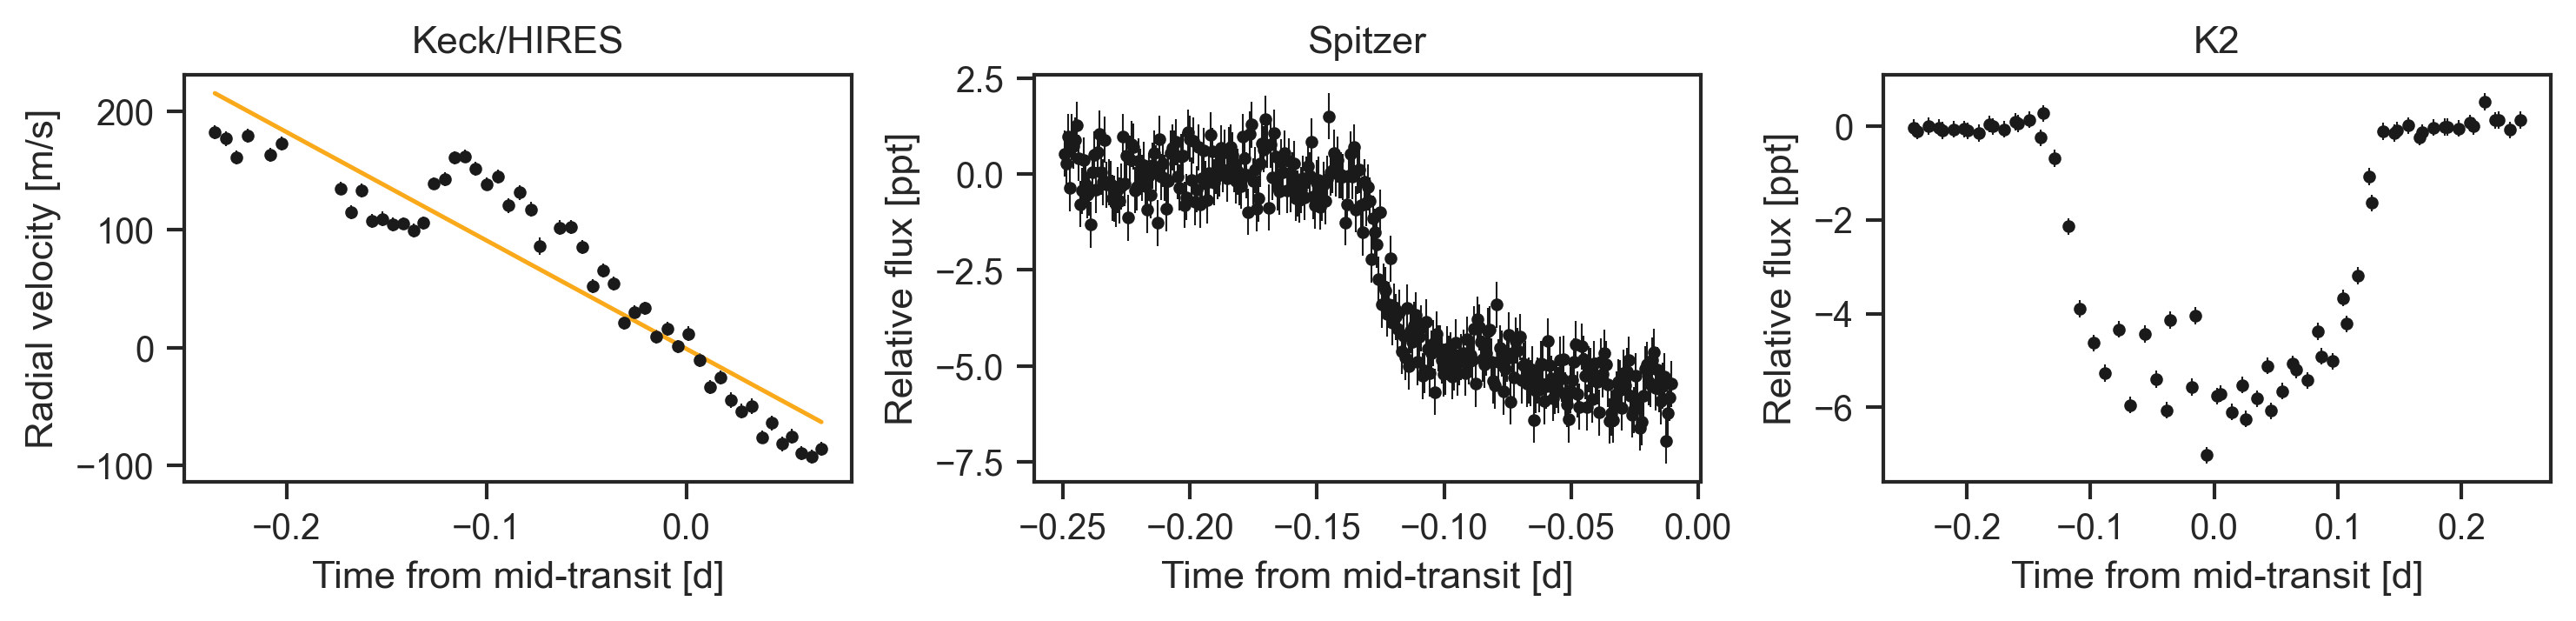

In [576]:
ebar_kwargs = {"fmt":"o", "ms":3, "lw":0.5, "mew":0.5, "color": "k"}

def time_from_mid_transit(time, period, t0):
    return ((time-t0-0.5*period)%period) - 0.5*period

# Radial velocity data
hires_df   = pd.read_csv('../data/hires.csv', comment='#')
hires_time = np.ascontiguousarray(hires_df['bjd'], dtype=np.float64)
hires_rv   = np.ascontiguousarray(hires_df['mnvel'], dtype=np.float64)
hires_err  = np.ascontiguousarray(hires_df['errvel'], dtype=np.float64)

# To model the RVs with a GP it is necessary to sort the data
arg = np.argsort(hires_time)
hires_time = hires_time[arg]
hires_rv   = hires_rv[arg]
hires_err  = hires_err[arg]

# K2 photometry
ktwo_df   = pd.read_csv('../data/ktwo.csv')
ktwo_time = ktwo_df['x']+2454833.0
ktwo_flux = ktwo_df['y']
ktwo_tfmt = time_from_mid_transit(ktwo_time, t0=V1298['t0'][0], period=V1298['per'][0])

# Mask out of transit data
arg = abs(ktwo_tfmt)<0.25
ktwo_time = ktwo_time[arg]
ktwo_tfmt = ktwo_tfmt[arg]
ktwo_flux = ktwo_flux[arg]

# Spitzer photometry
spitz_df   = pd.read_csv('../data/spitzer.csv')
spitz_time = spitz_df['time']
spitz_tfmt = time_from_mid_transit(spitz_time, t0=V1298['t0'][0], period=V1298['per'][0])
spitz_flux = 1e3*(spitz_df['flux']-1.0) #Normalization
spitz_arg  = abs(spitz_tfmt)<0.25

spitz_time = np.ascontiguousarray(spitz_time[spitz_arg], dtype=float)
spitz_tfmt = np.ascontiguousarray(spitz_tfmt[spitz_arg], dtype=float)
spitz_flux = np.ascontiguousarray(spitz_flux[spitz_arg], dtype=float)
spitz_err  = 600*1e-6*1e3

ktwo_time  = np.ascontiguousarray(ktwo_time, dtype=float)
ktwo_tfmt  = np.ascontiguousarray(ktwo_tfmt, dtype=float)
ktwo_flux  = np.ascontiguousarray(ktwo_flux, dtype=float)
ktwo_err   = 180*1e-6*1e3

# We will subtract a constant from all of the timestamps, to be added back in after sampling
hires_time -= time_offset
ktwo_time  -= time_offset
spitz_time -= time_offset

rm_mask = abs(hires_time)<2
hires_time = hires_time[rm_mask]
hires_rv = hires_rv[rm_mask]
hires_err = hires_err[rm_mask]

hires_texp = np.median(np.diff(hires_time))
ktwo_texp  = 1766.0/86400.0
spitz_texp = np.median(np.diff(np.sort(np.array(spitz_time))))
print('Median RV exposure time [minutes]:', hires_texp*24.0*60.0)
print('       K2 exposure time [minutes]:', ktwo_texp*24.0*60.0)
print('  Spitzer exposure time [minutes]:', spitz_texp*24.0*60.0)

#Fit polynomial to RV data
poly_coeff = np.polyfit(hires_time,hires_rv,1)
p=np.poly1d(poly_coeff)

plt.subplot(131)
plt.errorbar(hires_time, hires_rv, yerr=hires_err, **ebar_kwargs)
plt.plot(hires_time, p(hires_time), 'C1')
plt.xlabel('Time from mid-transit [d]'); plt.ylabel('Radial velocity [m/s]'); plt.title('Keck/HIRES')
plt.subplot(132)
plt.errorbar(spitz_tfmt, spitz_flux, yerr=spitz_err,  **ebar_kwargs)
plt.xlabel('Time from mid-transit [d]'); plt.ylabel('Relative flux [ppt]'); plt.title('Spitzer')
plt.subplot(133)
plt.errorbar(ktwo_tfmt, ktwo_flux, yerr=ktwo_err,  **ebar_kwargs)
plt.xlabel('Time from mid-transit [d]'); plt.ylabel('Relative flux [ppt]'); plt.title('K2')

plt.gcf().set_size_inches(10,2.5)
plt.tight_layout()
plt.show()

In [577]:
#For plotting purposes
t_rv = np.append(np.linspace(-20,20,1000), 
                 np.linspace(hires_time.min() - 0.5, hires_time.max() + 0.5, 1000))
t_rv = np.sort(t_rv)

def build_model(trend, 
                mask=None,
                instruments='hires',
                start=None, 
                eccentric=False, 
                planet_mass=False, 
                prot_prior='loose'):
    
    if mask is None:
        mask = np.ones(len(x_rv), dtype=bool)
        
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=5)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
        
        # Orbital parameters for the planets
        if planet_mass==True:
            logm = pm.Uniform("logm", lower=np.log(0.1), upper=np.log(1e4))
            m_pl = pm.Deterministic("m_pl", tt.exp(logm))
        elif planet_mass==False:
            m_pl = 0.0
            
        # Transit parameters    
        period = pm.Normal("period", mu=V1298['per'][0], sd=0.1)
        t0   = pm.Normal("t0", mu=0.0, sd=0.1)
        ror  = pm.Uniform("ror", lower=0.0, upper=0.2, testval=0.07)
        r_pl = pm.Deterministic("r_pl", r_star*ror)
        b    = xo.distributions.ImpactParameter("b", ror=ror)            
            
        if eccentric==True:
            ecc = xo.distributions.eccentricity.vaneylen19("ecc")
            omega = xo.distributions.Angle("omega")
        
        elif eccentric==False:
            ecc = 0.0
            omega = np.pi/2.
        
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(r_star=r_star,
                                         m_star=m_star,
                                         period=period,
                                         t0=t0,
                                         b=b,
                                         m_planet=xo.units.with_unit(m_pl, u.M_earth),
                                         ecc=ecc,
                                         omega=omega)
        
        
        # Compute the model light curve using starry
        u_star       = xo.distributions.QuadLimbDark("u_star")
        u_star_spitz = xo.distributions.QuadLimbDark("u_star_ir")
        mean_ktwo    = pm.Normal("mean_ktwo", mu=0.0, sd=10.0)
        mean_spitz   = pm.Normal("mean_spitz", mu=0.0, sd=10.0)
                
        light_curves = (xo.LimbDarkLightCurve(u_star).get_light_curve(orbit=orbit, 
                                                                      r=r_pl, 
                                                                      t=ktwo_time, texp=ktwo_texp) * 1e3)
        light_curve  = pm.math.sum(light_curves, axis=-1) + mean_ktwo
        pm.Deterministic("light_curves", light_curves)
        pm.Deterministic("light_curve", light_curve)
        
        light_curves_spitz = (xo.LimbDarkLightCurve(u_star_spitz).get_light_curve(orbit=orbit, 
                                                                      r=r_pl, 
                                                                      t=spitz_time, texp=spitz_texp) * 1e3)
        light_curve_spitz  = pm.math.sum(light_curves_spitz, axis=-1) + mean_spitz
        
        pm.Deterministic("light_curves_spitz", light_curves_spitz)
        pm.Deterministic("light_curve_spitz", light_curve_spitz)      

        logjit_spitz = pm.Uniform("logjit_spitz", lower=-10, upper=2) 
        jit_spitz    = pm.Deterministic("jit_spitz", tt.exp(logjit_spitz))
        err_spitz    = pm.Deterministic("err_spitz", tt.sqrt(tt.sqr(spitz_err) + tt.sqr(jit_spitz)))

        # Note, we allow K2 error bars to scale with light curve depth to account for excess in-transit scatter
        logjit_ktwo  = pm.Uniform("logjit_ktwo", lower=-10, upper=2) 
        jit_ktwo     = pm.Deterministic("jit_ktwo", tt.exp(logjit_ktwo)*abs(light_curve))
        err_ktwo     = pm.Deterministic("err_ktwo", tt.sqrt(tt.sqr(ktwo_err) + tt.sqr(jit_ktwo)))
        
        # The likelihood functions for the light curves assuming known Gaussian uncertainty
        pm.Normal("obs_spitz", mu=light_curve_spitz, sd=err_spitz, observed=spitz_flux)
        pm.Normal("obs_ktwo", mu=light_curve, sd=err_ktwo, observed=ktwo_flux)
                
        # Modeling the Rossiter-McLaughlin curve with Starry
        VsiniBoundedNormal = pm.Bound(pm.Normal, lower=0, upper=100)        
        vsini = VsiniBoundedNormal("vsini", mu=24.9, sd=0.2) #Marshall's value

        #Draw from uniform distribution in cosi for isotropic viewing angles
        cosi_st   = pm.Uniform("cosi_st", lower=0, upper=1.0)
        sini_st   = pm.Deterministic("sini_st", tt.sin(tt.arccos(cosi_st)))
        i_st      = pm.Deterministic("i_st", tt.arcsin(sini_st)*180./np.pi)
        veq       = pm.Deterministic("veq", vsini/sini_st)
        a_r       = pm.Deterministic("a_r", Keplers_Third_A(period, m_star)/r_star*(u.cm/c.R_sun.cgs).value)
        cosi_pl   = pm.Deterministic("cosi_pl", cosi_from_b(b, a_r))
        i_pl_deg  = pm.Deterministic("i_pl_deg", tt.arccos(cosi_pl)*180./np.pi)
        
        #Track the inferred rotation period
        prot_model = pm.Deterministic("prot_model",1./u.day.to(u.second)*2.*np.pi*r_star*c.R_sun.to(u.km).value/veq)
        
        # Leverage information from the photometrically derived rotation period 
        # to derive self-consistent constraints on vsini, R*, stellar inclination, 
        # and obliquity
        
        # The tight prior corresponds to the constraints on the rotation period from
        # Gaussian process regression on the K2 light curve in David et al. 2019b
        if prot_prior=='tight':            
            prot_obs   = pm.Normal("prot_obs", mu=prot_model, sigma=0.022, observed=2.870)
        
        # The loose prior accounts for additional uncertainty due to differential rotation
        elif prot_prior=='loose':
            prot_obs   = pm.Normal("prot_obs", mu=prot_model, sigma=0.2, observed=2.870)
                
        #############################
        # Rossiter-McLaughlin model #
        #############################
        
        # Obliquity
        obliquity_rad = pm.Uniform("obliquity_rad", lower=-np.pi, upper=np.pi)
        obliquity     = pm.Deterministic("obliquity", obliquity_rad*180./np.pi)

        pri = starry.Primary(starry.Map(udeg=2, 
                                        rv=True, 
                                        amp=1, 
                                        veq=veq*1e3, 
                                        alpha=0.0, 
                                        obl=obliquity),
                             r=r_star,
                             m=m_star,
                             length_unit=u.Rsun,
                             mass_unit=u.Msun,
                            )

        # Limb darkening
        pri.map[1] = u_star[0]
        pri.map[2] = u_star[1] 

        # Define the planet
        sec = starry.Secondary(starry.Map(rv=True, 
                                          amp=0, 
                                          veq=0),
                               r=ror*r_star,
                               porb=period,
                               m=0, 
                               t0=t0,
                               inc=i_pl_deg,
                               ecc=ecc,
                               w=omega*180./np.pi,
                               length_unit=u.Rsun,
                               mass_unit=u.Msun,
                               angle_unit=u.degree,
                               time_unit=u.day
                              )

        
        # Define the system in Starry
        sys_rv = starry.System(pri, sec, texp=hires_texp)
        # Note: we are assuming the HIRES exposure time

        # Compute the RV signal
        rm_curve      = pm.Deterministic("rm_curve", sys_rv.rv(x_rv[mask]))
        rm_curve_pred = pm.Deterministic("rm_curve_pred", sys_rv.rv(t_rv))
        
        # RV jitter        
        if instruments=='hires':
            logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv[mask])), sd=5)
            err_rv  = pm.Deterministic("err_rv", tt.sqrt(yerr_rv[mask] ** 2 + tt.exp(2 * logs_rv)))            
            
        if (instruments=='hires') and (trend=='gp'):
            # The mean radial velocity of the time series
            mean_hires = pm.Normal("mean_hires", mu=0, sd=50)
            mean_rv    = pm.Deterministic("mean_rv", mean_hires*np.ones(len(x_rv)))
            #maybe this should be x_rv[mask]!!
            
        elif instruments=='all':
            # Jitter parameters for each instrument
            logs_rv_hires = pm.Normal("logs_rv_hires", mu=np.log(np.median(yerr_rv[mask&(inst_id=='hires')])), sd=5)
            logs_rv_tres  = pm.Normal("logs_rv_tres",  mu=np.log(np.median(yerr_rv[mask&(inst_id=='tres')])), sd=5)
            logs_rv_pepsi = pm.Normal("logs_rv_pepsi", mu=np.log(np.median(yerr_rv[mask&(inst_id=='pepsi')])), sd=5)

            logs_rv = pm.Deterministic("logs_rv", 
                                       logs_rv_hires * (inst_id == 'hires') +\
                                       logs_rv_tres * (inst_id == 'tres') +\
                                       logs_rv_pepsi * (inst_id == 'pepsi')
                                      )
            
            # The mean radial velocity of the time series
            mean_hires = pm.Normal("mean_hires", mu=0, sd=50)
            mean_tres  = pm.Uniform("mean_tres", lower=-1000, upper=1000)
            mean_pepsi = pm.Uniform("mean_pepsi", lower=-1000, upper=1000)
                        
            mean_rv = pm.Deterministic("mean_rv", mean_hires*(inst_id=='hires') +\
                                       mean_tres*(inst_id=='tres') +\
                                       mean_pepsi*(inst_id=='pepsi'))            
            
            err_rv = pm.Deterministic("err_rv", tt.sqrt(tt.sqr(yerr_rv[mask]) + tt.exp(2 * logs_rv[mask])))   
                     
        
        if trend=="linear":
            c0 = pm.Normal("c0", mu=0, sd=1e5, testval=poly_coeff[1])
            c1 = pm.Normal("c1", mu=0, sd=1e5, testval=poly_coeff[1])

            rv_trend      = pm.Deterministic("rv_trend", c0 + c1*x_rv[mask])
            rv_trend_pred = pm.Deterministic("rv_trend_pred", c0 + c1*t_rv)        
        
        elif trend=="quadratic":
            c0 = pm.Normal("c0", mu=0, sd=1e5, testval=poly_coeff[1])
            c1 = pm.Normal("c1", mu=0, sd=1e5, testval=poly_coeff[1])
            c2 = pm.Normal("c2", mu=0, sd=1e5)

            rv_trend      = pm.Deterministic("rv_trend", c0 + c1*x_rv[mask] + c2*x_rv[mask]**2)
            rv_trend_pred = pm.Deterministic("rv_trend_pred", c0 + c1*t_rv + c2*t_rv**2)

        elif trend=="cubic":
            c0 = pm.Normal("c0", mu=0, sd=1e5, testval=poly_coeff[1])
            c1 = pm.Normal("c1", mu=0, sd=1e5, testval=poly_coeff[1])
            c2 = pm.Normal("c2", mu=0, sd=1e5)
            c3 = pm.Normal("c3", mu=0, sd=1e5)

            rv_trend      = pm.Deterministic("rv_trend", c0 + c1*x_rv[mask] + c2*x_rv[mask]**2 + c3*x_rv[mask]**3)
            rv_trend_pred = pm.Deterministic("rv_trend_pred", c0 + c1*t_rv + c2*t_rv**2 + c3*t_rv**3)            
            
        elif trend=="gp":
            log_sigma_rot = pm.Normal("log_sigma_rot", mu=np.log(np.std(y_rv[mask])), sd=10, testval=10)
            log_Q0     = pm.Normal("log_Q0", mu=1, sd=10, testval=0.16)
            log_dQ     = pm.Normal("log_dQ", mu=2, sd=10, testval=4.4)
            f          = pm.Uniform("f", lower=0.1, upper=1.0)
            
            # Set up the Gaussian Process model
            kernel = terms.RotationTerm(sigma=tt.exp(log_sigma_rot),
                                        period=prot_model,
                                        Q0=tt.exp(log_Q0),
                                        dQ=tt.exp(log_dQ),
                                        f=f,
                                       )
            gp = GaussianProcess(
                kernel,
                t=x_rv[mask],
                diag=tt.sqr(err_rv),
                quiet=True,
            )                
            
        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
#         if planet_mass==True:
#             #pl_rv = orbit.get_radial_velocity(hires_time)
#             pl_rv = orbit.get_radial_velocity(x_rv[mask])
#             pm.Deterministic("pl_rv", pl_rv)
#             pl_rv_pred = orbit.get_radial_velocity(t_rv)
#             pm.Deterministic("pl_rv_pred", pl_rv_pred)        
            
#             rv_model = pm.Deterministic("rv_model", pl_rv + rm_curve + rv_trend)
#             rv_model_pred = pm.Deterministic("rv_model_pred", pl_rv_pred + rm_curve_pred + rv_trend_pred)
            
#         elif planet_mass==False:
#             rv_model = pm.Deterministic("rv_model", rm_curve + rv_trend)
#             rv_model_pred = pm.Deterministic("rv_model_pred", rm_curve_pred + rv_trend_pred)        
                    
        # Likelihood for RVs
        if trend != "gp":
            rv_model      = pm.Deterministic("rv_model", rm_curve + rv_trend)
            rv_model_pred = pm.Deterministic("rv_model_pred", rm_curve_pred + rv_trend_pred)                    
            pm.Normal("obs", mu=rv_model, sd=err_rv, observed=y_rv[mask])
            
        elif trend == "gp":
            rv_model = pm.Deterministic("rv_model", rm_curve)
            rv_model_pred = pm.Deterministic("rv_model_pred", rm_curve_pred)
                                   
            # Compute the Gaussian Process likelihood and add it into the the PyMC3 model as a "potential"
            #pm.Potential("loglike_rv", gp_rv.log_likelihood(y_rv[rv_mask] - tt.sum(pl_rv, axis=-1) - mean_rv[rv_mask] - rm_curve))
            
            #09092021
            #pm.Potential("loglike_rv", gp.log_likelihood(y_rv[mask] - mean_rv[mask] - rv_model))
            
            #09092021
            # Compute the Gaussian Process likelihood and add it into the the PyMC3 model as a "potential"
            gp.marginal("gp", observed=y_rv[mask] - mean_rv[mask] - rv_model)
            
            # Compute the mean model prediction for plotting purposes 
            gp_rv      = pm.Deterministic("gp_rv", gp.predict(y_rv[mask] - mean_rv[mask] - rv_model, x_rv[mask]))
            gp_rv_pred = pm.Deterministic("gp_rv_pred", gp.predict(y_rv[mask] - mean_rv[mask] - rv_model, t_rv, include_mean=False))                           
            #rv_model = pm.Deterministic("rv_model", st_rv + rm_curve + tt.sum(pl_rv, axis=-1))

            
        if trend=='gp':
            model.gp = gp
        model.orbit = orbit
        model.sys_rv = sys_rv

        # Fit for the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start)
        map_soln = pmx.optimize(start=map_soln, vars=[ror, b, logjit_ktwo, logjit_spitz])
        map_soln = pmx.optimize(start=map_soln, vars=[period, t0])
        
        if trend=="linear":
            map_soln = pmx.optimize(start=map_soln, vars=[c0, c1, obliquity_rad])
        elif trend=="quadratic":
            map_soln = pmx.optimize(start=map_soln, vars=[c0, c1, c2, obliquity_rad])
        elif trend=="cubic":
            map_soln = pmx.optimize(start=map_soln, vars=[c0, c1, c2, c3, obliquity_rad])            
        if instruments=='all':
            map_soln = pmx.optimize(start=map_soln, vars=[mean_hires, mean_pepsi, mean_tres])
        elif trend=='gp':
            map_soln = pmx.optimize(start=map_soln, vars=[log_sigma_rot, log_Q0, log_dQ, f, obliquity_rad])

        map_soln = pmx.optimize(start=map_soln, vars=[logjit_ktwo, logjit_spitz, logs_rv])
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln

### debugging the gp plotting issue

In [545]:

# fig, ax = plt.subplots(nrows=1,ncols=1)

# mask = None

# rvmodel = np.percentile(trace_gp["gp_rv_pred"]+trace_gp["rv_model_pred"], [16,50,84], axis=0)

# art = ax.fill_between(t_rv, rvmodel[0], rvmodel[2], color='#808080', alpha=0.5, zorder=1)
# art.set_edgecolor("none")  

# #for inst in np.unique(inst_id)[::-1]:
# for inst in np.unique(inst_id[mask]):
#     _ = inst_id[mask]==inst
#     ax.errorbar(x_rv[mask][_], 
#                 y_rv[mask][_]-np.mean(trace_gp["mean_rv"], axis=0)[mask][_], 
#                 #yerr=np.mean(trace_gp["err_rv"], axis=0)[_], 
#                 label=inst.upper(), fmt='.')

# ax.set_ylabel('Radial velocity [m/s]', labelpad=10)
# ax.legend(prop={'size':8})
# #ax.set_xticklabels([])
# ax.set_xlim(-0.5,0.5)

In [578]:
def plot_rm_curve(soln, mask=None):

    if mask is None:
        mask = np.ones(len(x_rv), dtype=bool)

    plt.subplot(211)
    plt.errorbar(x_rv[mask], y_rv[mask], yerr=soln["err_rv"], fmt='.', color='k')
    plt.plot(t_rv, soln['rv_model_pred'], 'C1', zorder=99)
    plt.xlim(-0.25,0.25)
    plt.ylim(-300,300)
    plt.ylabel(r'Radial velocity [m s$^\mathregular{-1}$]')
    plt.subplot(212)
    plt.axhline(0, color='lightgrey')
    plt.errorbar(x_rv[mask], y_rv[mask]-soln['rv_model'], yerr=soln["err_rv"], fmt='.', color='k', lw=0.5)
    plt.xlim(-0.25,0.25)
    plt.xlabel('JD - offset [days]')
    plt.ylabel(r'Residuals [m s$^\mathregular{-1}$]')
    plt.gcf().set_size_inches(4,4)
    plt.show()
    
    
def plot_map_soln(map_soln, mask=None, gp=False, figpath=None):

    if mask is None:
        mask = np.ones(len(x_rv), dtype=bool)
        
#     mpl.rcParams['lines.linewidth'] = 0.5
#     mpl.rcParams['lines.markersize'] = 3
    
    time_hires = np.linspace(-0.25,0.25,int(1e3))
    tfmt_hires = ((hires_time-map_soln['t0']-0.5*map_soln['period'])%map_soln['period']) - 0.5*map_soln['period']

    lc_tfmt = ((ktwo_time-map_soln['t0']-0.5*map_soln['period'])%map_soln['period']) - 0.5*map_soln['period']
    spitz_tfmt = ((spitz_time-map_soln['t0']-0.5*map_soln['period'])%map_soln['period']) - 0.5*map_soln['period']
    
    arg = np.argsort(lc_tfmt)
    arg = np.argsort(tfmt_hires)

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=3, figsize=(10,4))

    ax1[0].set_title("Keck/HIRES")
    if gp==False:
        ax1[0].errorbar(x_rv[mask], y_rv[mask], yerr=map_soln["err_rv"], color='k', fmt='.')
        ax2[0].errorbar(x_rv[mask], y_rv[mask]-map_soln["rv_model"], yerr=map_soln["err_rv"], color='k', fmt='.')
    elif gp==True:
        ax1[0].errorbar(x_rv[mask], y_rv[mask]-map_soln["gp_rv"]-map_soln["mean_rv"][mask], yerr=map_soln["err_rv"], color='k', fmt='.')
        ax2[0].errorbar(x_rv[mask], y_rv[mask]-map_soln["gp_rv"]-map_soln["mean_rv"][mask]-map_soln["rv_model"], yerr=map_soln["err_rv"], color='k', fmt='.')
    ax1[0].plot(t_rv, map_soln["rv_model_pred"], "C1-", zorder=999, lw=2, alpha=0.5)
    ax1[0].set_ylabel(r'Radial velocity [m s$^\mathregular{-1}$]')
    ax1[0].set_xlim(-0.25,0.25)
    ax1[0].set_ylim(-250,250)

    ax2[0].axhline(0, color="C1", ls='--', zorder=999)    
    ax2[0].set_xlabel('Time from mid-transit [days]')
    ax2[0].set_ylabel(r'O-C [m s$^\mathregular{-1}$]')
    ax2[0].set_xlim(-0.25,0.25)

    ax1[1].set_title("Spitzer")
    ax1[1].errorbar(spitz_tfmt, spitz_flux, yerr=map_soln["err_spitz"], color='k', fmt='.')
    ax1[1].plot(spitz_tfmt, map_soln["light_curve_spitz"], "C1-", zorder=999, lw=2, alpha=0.9)
    ax1[1].set_ylabel('Relative flux [ppt]')
    ax1[1].set_xlim(-0.25,0.25)

    ax2[1].axhline(0, color="C1", ls='--', zorder=999)
    ax2[1].errorbar(spitz_tfmt, (spitz_flux-map_soln["light_curve_spitz"]), yerr=map_soln["err_spitz"], color='k', fmt='.')
    ax2[1].set_xlabel('Time from mid-transit [days]')
    ax2[1].set_ylabel(r'O-C [ppt]')
    ax2[1].set_xlim(-0.25,0.25)

    ax1[2].set_title("K2")
    ind = np.argsort(ktwo_tfmt)
    ax1[2].errorbar(ktwo_tfmt, ktwo_flux, yerr=map_soln["err_ktwo"], color='k', fmt='.')
    ax1[2].plot(ktwo_tfmt[ind], map_soln["light_curve"][ind], "C1-", zorder=999, lw=2, alpha=0.5)
    ax1[2].set_ylabel('Relative flux [ppt]')
    ax1[2].set_xlim(-0.25,0.25)

    ax2[2].axhline(0, color="C1", ls='--', zorder=999)
    ax2[2].errorbar(ktwo_tfmt, (ktwo_flux-map_soln["light_curve"]), yerr=map_soln["err_ktwo"], color='k', fmt='.')
    ax2[2].set_xlabel('Time from mid-transit [days]')
    ax2[2].set_ylabel(r'O-C [ppt]')
    ax2[2].set_xlim(-0.25,0.25)

    plt.tight_layout()
    if figpath:
        plt.savefig(figpath, bbox_inches='tight')
    plt.show()
    
    return 

def plot_gp_soln(map_soln, model, mask=None, figpath=None):
    #ebar_kwargs = {"fmt":"o", "ms":3, "mfc":"None", "lw":0.5, "mew":0.5}
    ebar_kwargs = {"fmt":"o", "ms":3, "mfc":"None", "lw":1, "mew":1}
    
    x_gp = np.linspace(-20,20,1000)
    with model:
        y_gp = pmx.eval_in_model(model.gp.predict(y_rv[mask] - map_soln["mean_rv"][mask] - map_soln["rm_curve"], x_gp), map_soln)
    
    if mask is None:
        mask = np.ones(len(x_rv), dtype=bool)
        
    fig = plt.figure(constrained_layout=False, figsize=(9,4))
    spec = fig.add_gridspec(ncols=2, nrows=2, hspace=0.0, wspace=0.4, width_ratios=[1,1], height_ratios=[2,1])

    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1])

    ax3 = fig.add_subplot(spec[1, 0])
    ax4 = fig.add_subplot(spec[1, 1])

    resid = y_rv[mask] - map_soln["mean_rv"][mask] - map_soln["rm_curve"] - map_soln["gp_rv"]
    rv_out = abs(resid)/map_soln["err_rv"] > 3

    for ax in [ax1,ax2]:
        ax.plot(t_rv, map_soln["rm_curve_pred"]+map_soln["gp_rv_pred"], color='#2e2e2e', lw=0.5)

        for inst in np.unique(inst_id[mask]):
            _ = inst_id[mask]==inst
            ax.errorbar(x_rv[mask][_], y_rv[mask][_]-map_soln["mean_rv"][mask][_], yerr=map_soln["err_rv"][_], label=inst.upper(), **ebar_kwargs)

        ax.set_ylabel(r'Radial velocity [m s$^\mathregular{-1}$]')
        ax.legend()
        ax.set_xticklabels([])

        ax.plot(x_rv[mask][rv_out], y_rv[mask][rv_out] - map_soln["mean_rv"][mask][rv_out], 'rx')
    
    ax1.plot(x_gp, y_gp, color='#2e2e2e', lw=0.5)
    
    for ax in [ax3,ax4]:
        for inst in np.unique(inst_id[mask]):            
            _ = inst_id[mask]==inst
            ax.errorbar(x_rv[mask][_], resid[_], 
                        yerr=map_soln["err_rv"][_], label=inst.upper(), **ebar_kwargs)
            
        ax.plot(x_rv[mask][rv_out], resid[rv_out], 'rx')

        ax.set_xlabel('Time from mid-transit [days]')
        ax.set_ylabel(r'Residuals [m s$^\mathregular{-1}$]')
        ax.axhline(0, color='k', lw=0.5)

    ax1.set_xlim(-20,20)
    ax3.set_xlim(-20,20)
    ax2.set_xlim(-0.4,0.2)
    ax4.set_xlim(-0.4,0.2)
    if figpath:
        plt.savefig(figpath, bbox_inches='tight')    
    plt.show()
    
    print("Obliquity [deg]: ", map_soln["obliquity"])
    
    return ~rv_out

In [579]:
model_line, map_soln_line = build_model(trend="linear", 
                                        mask=hires_rm, 
                                        prot_prior="loose")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fedc0accbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fedc0accbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object a

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [c1, c0, logs_rv, obliquity_rad, cosi_st, vsini, logjit_ktwo, logjit_spitz, mean_spitz, mean_ktwo, u_star_ir, u_star, b, ror, t0, period, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -14311.06904152957 -> -548.4375417540172
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fedc0accbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a t

optimizing logp for variables: [logjit_spitz, logjit_ktwo, b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -548.4375417540172 -> -548.4375417540172
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fedc0accbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fedc0accbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot c

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [t0, period]


message: Desired error not necessarily achieved due to precision loss.
logp: -548.4375417540172 -> -548.4375417540172
optimizing logp for variables: [obliquity_rad, c1, c0]


message: Desired error not necessarily achieved due to precision loss.
logp: -548.4375417540172 -> -548.4375417540172
optimizing logp for variables: [logs_rv, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -548.4375417540172 -> -548.4375417540172
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fedc0accbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fedc0accbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [c1, c0, logs_rv, obliquity_rad, cosi_st, vsini, logjit_ktwo, logjit_spitz, mean_spitz, mean_ktwo, u_star_ir, u_star, b, ror, t0, period, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -548.4375417540172 -> -548.4375417540172


In [15]:
model_line_protprio, map_soln_line_protprio = build_model(trend="linear", 
                                                          mask=hires_rm, 
                                                          prot_prior="tight")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object a

message: Desired error not necessarily achieved due to precision loss.
logp: -14779.755682428608 -> -548.5608388655025
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a 

message: Desired error not necessarily achieved due to precision loss.
logp: -548.5608388655025 -> -548.5608388655025
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot c

message: Desired error not necessarily achieved due to precision loss.
logp: -548.5608388655025 -> -548.5608388655025
optimizing logp for variables: [obliquity_rad, c1, c0]


message: Optimization terminated successfully.
logp: -548.5608388655025 -> -548.5608388655025
optimizing logp for variables: [logs_rv, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -548.5608388655025 -> -548.5608388655025
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -548.5608388655025 -> -548.5608388655025


In [16]:
model_quad, map_soln_quad = build_model(trend="quadratic", 
                                        mask=hires_rm, 
                                        prot_prior="loose")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object a

message: Desired error not necessarily achieved due to precision loss.
logp: -14323.500905527746 -> -553.4934086045638
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a 

message: Optimization terminated successfully.
logp: -553.4934086045638 -> -553.4934086045528
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -553.4934086045528 -> -553.4934086045528
optimizing logp for variables: [obliquity_rad, c2, c1, c0]


message: Optimization terminated successfully.
logp: -553.4934086045528 -> -553.4934086045484
optimizing logp for variables: [logs_rv, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -553.4934086045484 -> -553.4934086045447
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -553.4934086045447 -> -553.4934086045447


In [17]:
model_quad_protprio, map_soln_quad_protprio = build_model(trend="quadratic", 
                                                          mask=hires_rm, 
                                                          prot_prior="tight")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object a

message: Desired error not necessarily achieved due to precision loss.
logp: -14792.187546426783 -> -555.1178700754801
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a 

message: Optimization terminated successfully.
logp: -555.1178700754801 -> -555.1178700754801
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -555.1178700754801 -> -555.1178700754801
optimizing logp for variables: [obliquity_rad, c2, c1, c0]


message: Optimization terminated successfully.
logp: -555.1178700754801 -> -555.1178700754801
optimizing logp for variables: [logs_rv, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -555.1178700754801 -> -555.1178700754801
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -555.1178700754801 -> -555.1178700754801


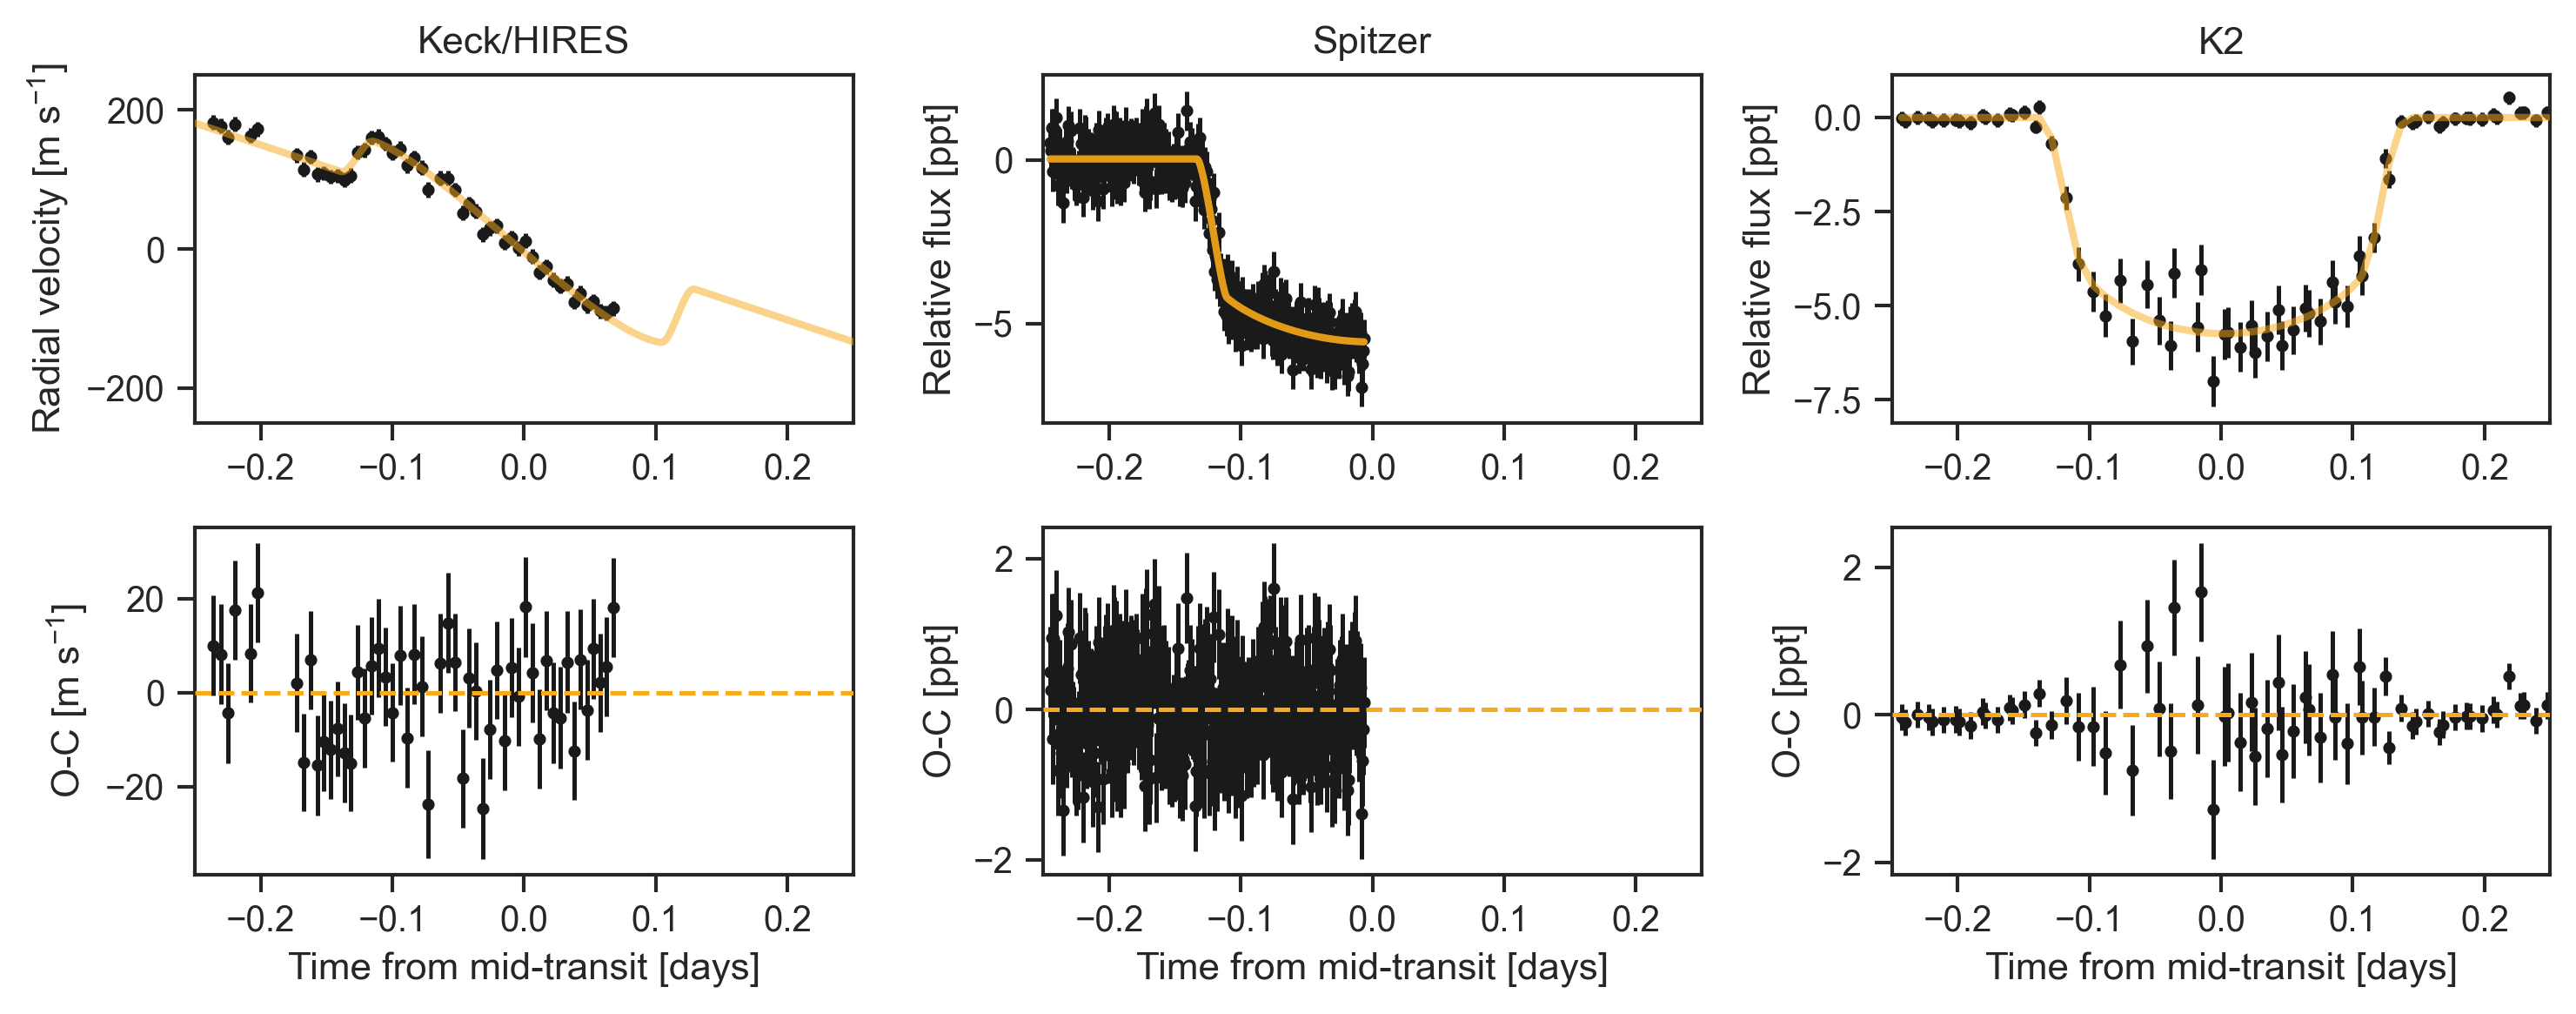

In [580]:
plot_map_soln(map_soln_line, mask=hires_rm, figpath='../figures/map_line.pdf')
plot_map_soln(map_soln_quad, mask=hires_rm, figpath='../figures/map_quad.pdf')

plot_map_soln(map_soln_line_protprio, mask=hires_rm, figpath='../figures/map_line_protprio.pdf')
plot_map_soln(map_soln_quad_protprio, mask=hires_rm, figpath='../figures/map_quad_protprio.pdf')

In [26]:
model_gp, map_soln_gp = build_model(trend="gp", 
                                    mask=all_rm, 
                                    instruments="all", 
                                    prot_prior="loose")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.ro

message: Desired error not necessarily achieved due to precision loss.
logp: -14024.121076718493 -> -850.2641770194102
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [logjit_spitz, logjit_kt

message: Optimization terminated successfully.
logp: -850.2641770194102 -> -850.2641770194095
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.o

message: Desired error not necessarily achieved due to precision loss.
logp: -850.2641770194095 -> -850.2641770194095
optimizing logp for variables: [mean_tres, mean_pepsi, mean_hires]


message: Optimization terminated successfully.
logp: -850.2641770194095 -> -850.2641770194095
optimizing logp for variables: [logs_rv_hires, logs_rv_tres, logs_rv_pepsi, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -850.2641770194095 -> -850.2641770194095
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.o

message: Desired error not necessarily achieved due to precision loss.
logp: -850.2641770194095 -> -850.2641770194095


In [27]:
model_gp_protprio, map_soln_gp_protprio = build_model(trend="gp", 
                                                      mask=all_rm, 
                                                      instruments="all",
                                                      prot_prior="tight")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.ro

message: Desired error not necessarily achieved due to precision loss.
logp: -14492.80771761753 -> -850.2516578142984
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [logjit_spitz, logjit_ktw

message: Optimization terminated successfully.
logp: -850.2516578142984 -> -850.2516578142984
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.o

message: Desired error not necessarily achieved due to precision loss.
logp: -850.2516578142984 -> -850.2516578142984
optimizing logp for variables: [mean_tres, mean_pepsi, mean_hires]


message: Optimization terminated successfully.
logp: -850.2516578142984 -> -850.2516578142984
optimizing logp for variables: [logs_rv_hires, logs_rv_tres, logs_rv_pepsi, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -850.2516578142984 -> -850.2516578142984
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.o

message: Desired error not necessarily achieved due to precision loss.
logp: -850.2516578142984 -> -850.2516578142984


In [28]:
model_gp_hires, map_soln_gp_hires = build_model(trend="gp", 
                                             mask=hires_rm, 
                                             instruments="hires",
                                             prot_prior="loose")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object a

message: Desired error not necessarily achieved due to precision loss.
logp: -12957.869270393272 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedS

message: Optimization terminated successfully.
logp: -12957.869270393272 -> -9114.145241372991
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test 

message: Optimization terminated successfully.
logp: -9114.145241372991 -> -9111.61095669938
optimizing logp for variables: [obliquity_rad, f, log_dQ, log_Q0, log_sigma_rot]


message: Optimization terminated successfully.
logp: -9111.61095669938 -> -9042.295845969436
optimizing logp for variables: [logs_rv, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -9042.295845969436 -> -9040.754046311886
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -9040.754046311886 -> -543.9787664303735


In [29]:
model_gp_protprio_hires, map_soln_gp_protprio_hires = build_model(trend="gp", 
                                             mask=hires_rm, 
                                             instruments="hires",
                                             prot_prior="tight")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object a

message: Desired error not necessarily achieved due to precision loss.
logp: -13426.55591129231 -> -545.1284561051489
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a t

message: Optimization terminated successfully.
logp: -545.1284561051489 -> -545.1284561051489
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -545.1284561051489 -> -545.1284561051489
optimizing logp for variables: [obliquity_rad, f, log_dQ, log_Q0, log_sigma_rot]


message: Optimization terminated successfully.
logp: -545.1284561051489 -> -545.1284561051489
optimizing logp for variables: [logs_rv, logjit_spitz, logjit_ktwo]


message: Optimization terminated successfully.
logp: -545.1284561051489 -> -545.1284561051489
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test v

message: Desired error not necessarily achieved due to precision loss.
logp: -545.1284561051489 -> -545.1284561051489


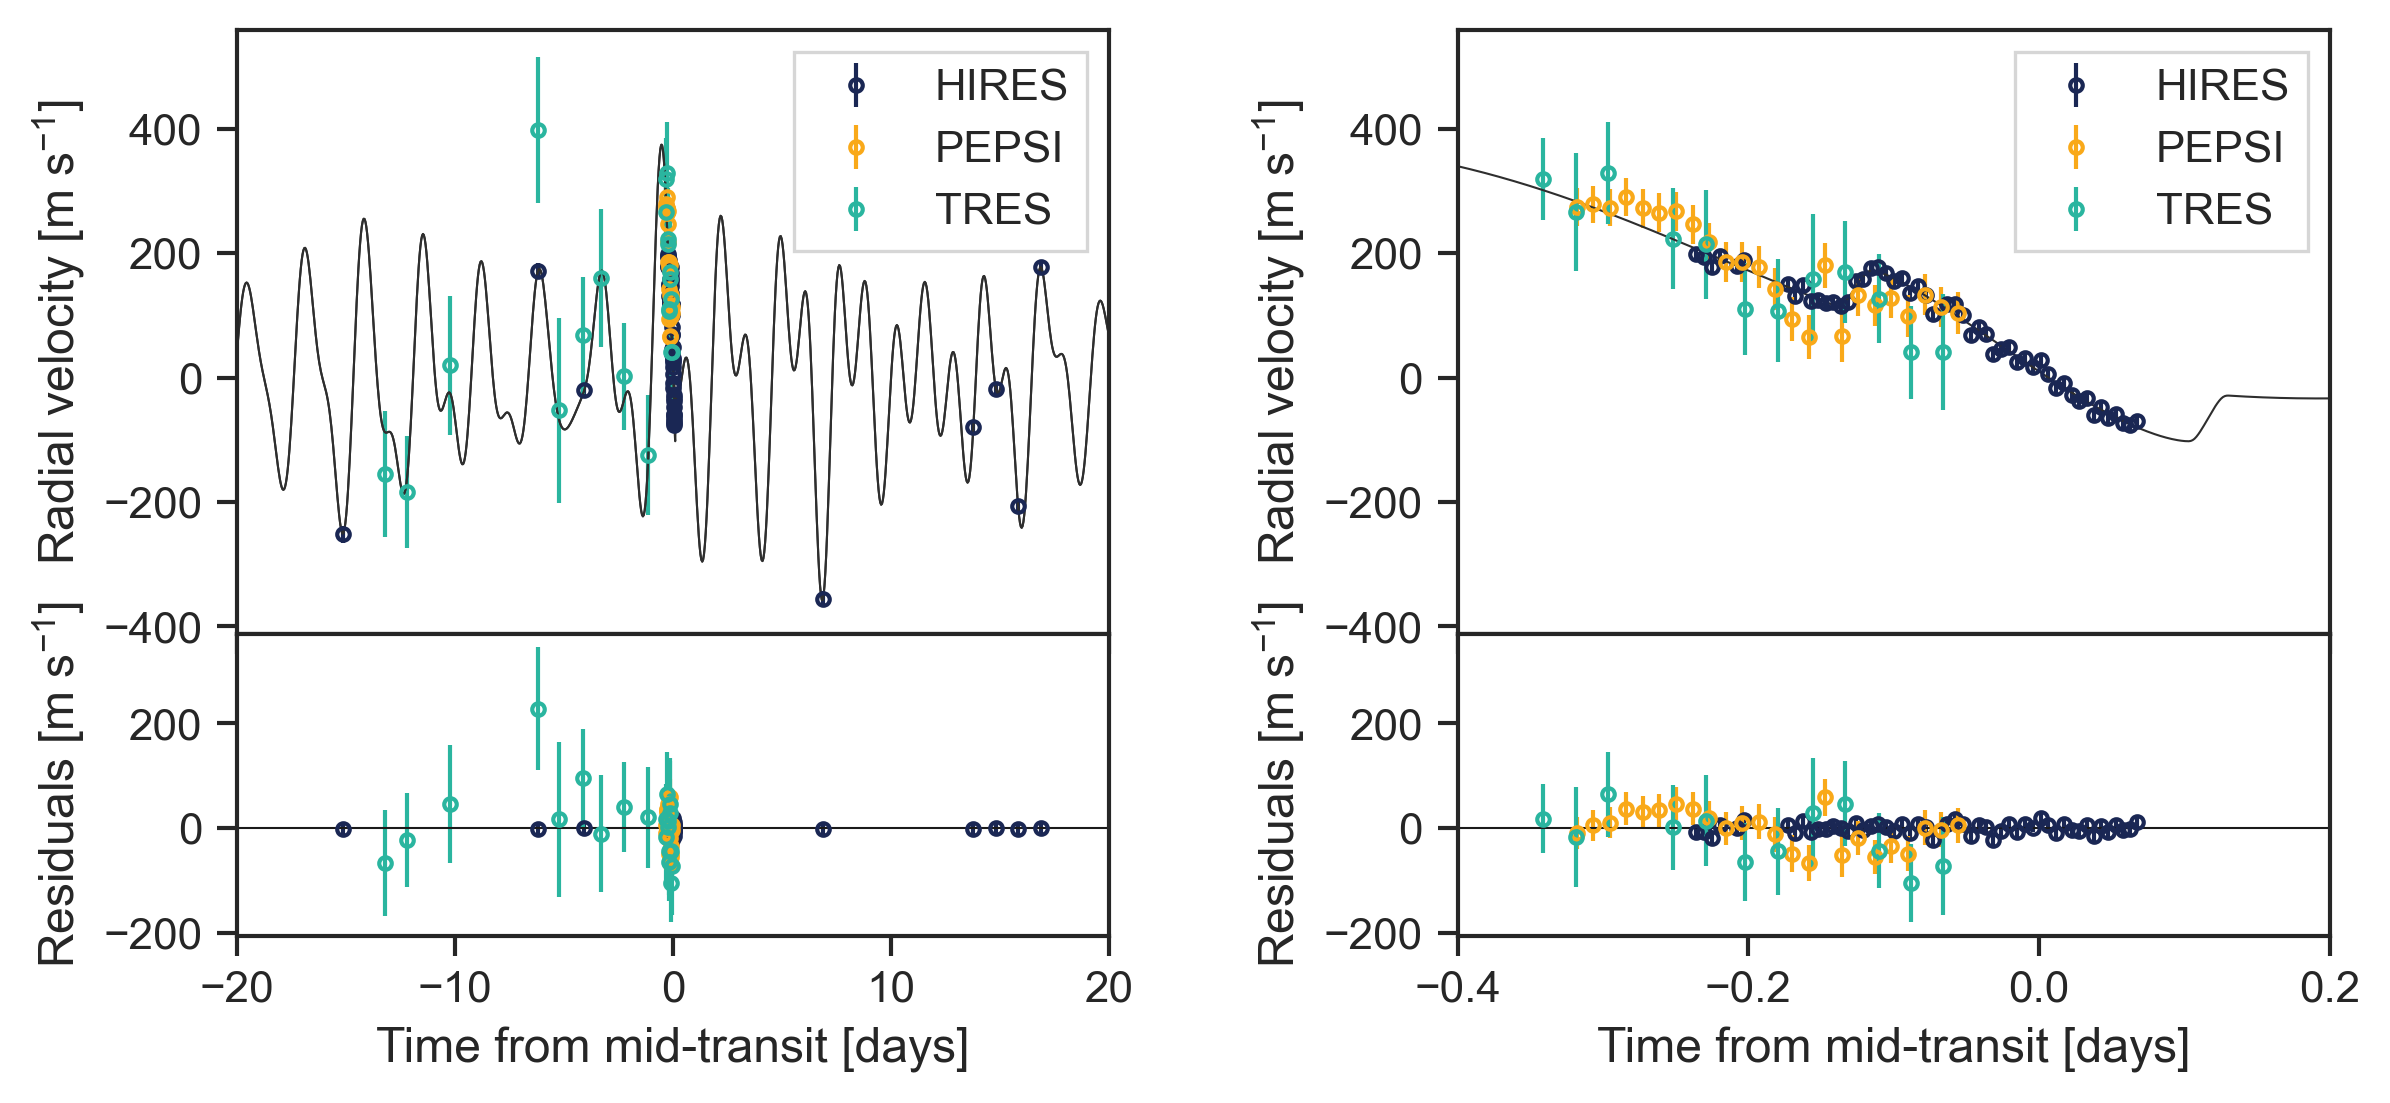

Obliquity [deg]:  0.8147282139245083


In [521]:
_ = plot_gp_soln(map_soln_gp, model_gp, mask=all_rm, figpath='../figures/map_gp.pdf')

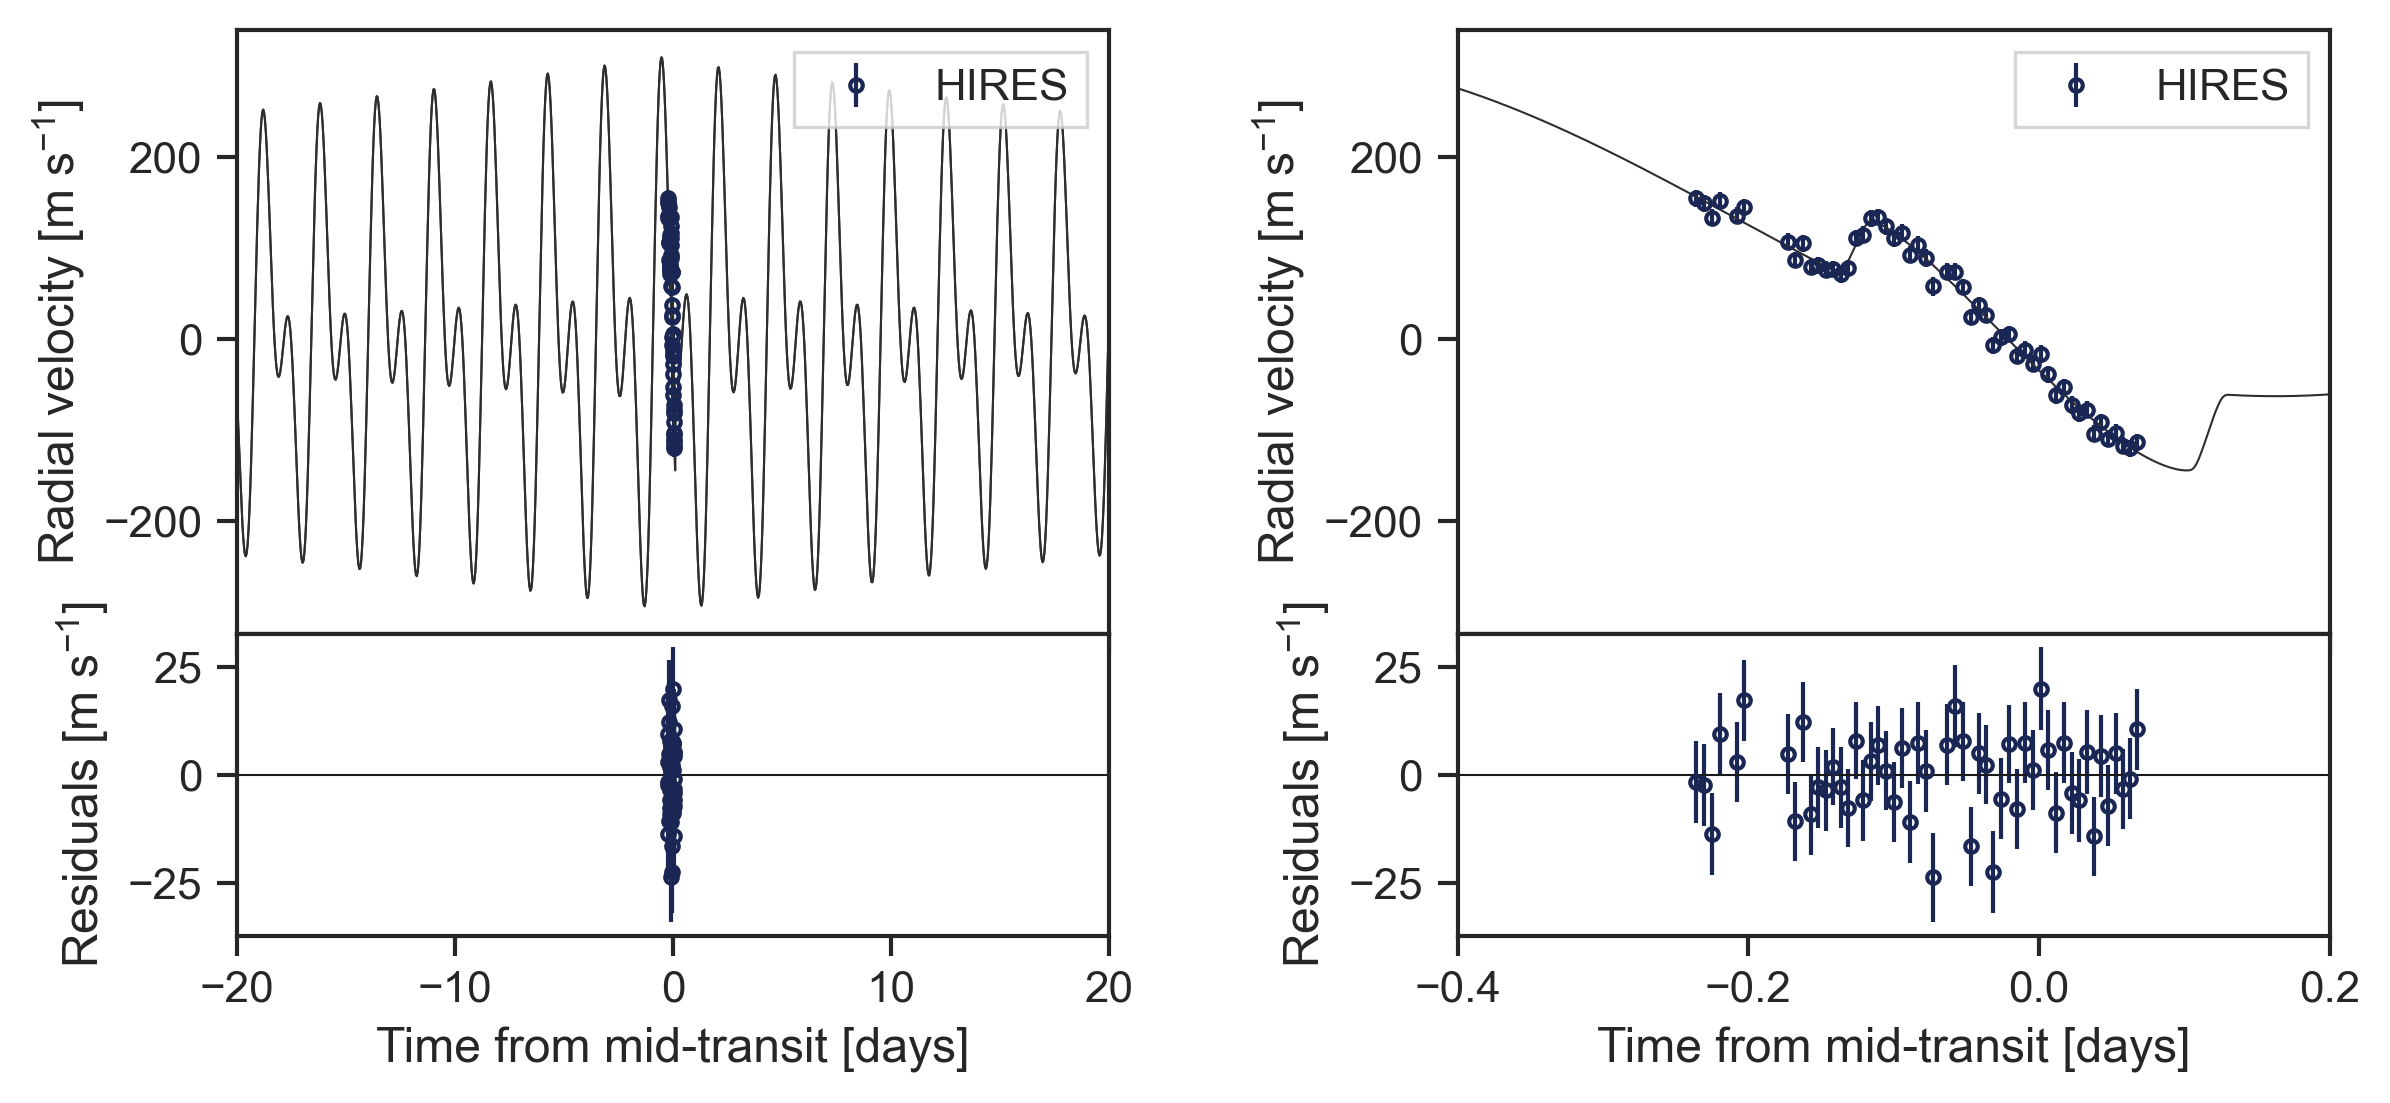

Obliquity [deg]:  -6.063884941929965


In [522]:
_ = plot_gp_soln(map_soln_gp_hires, model_gp_hires, mask=hires_rm, figpath='../figures/map_gp_hires.pdf')

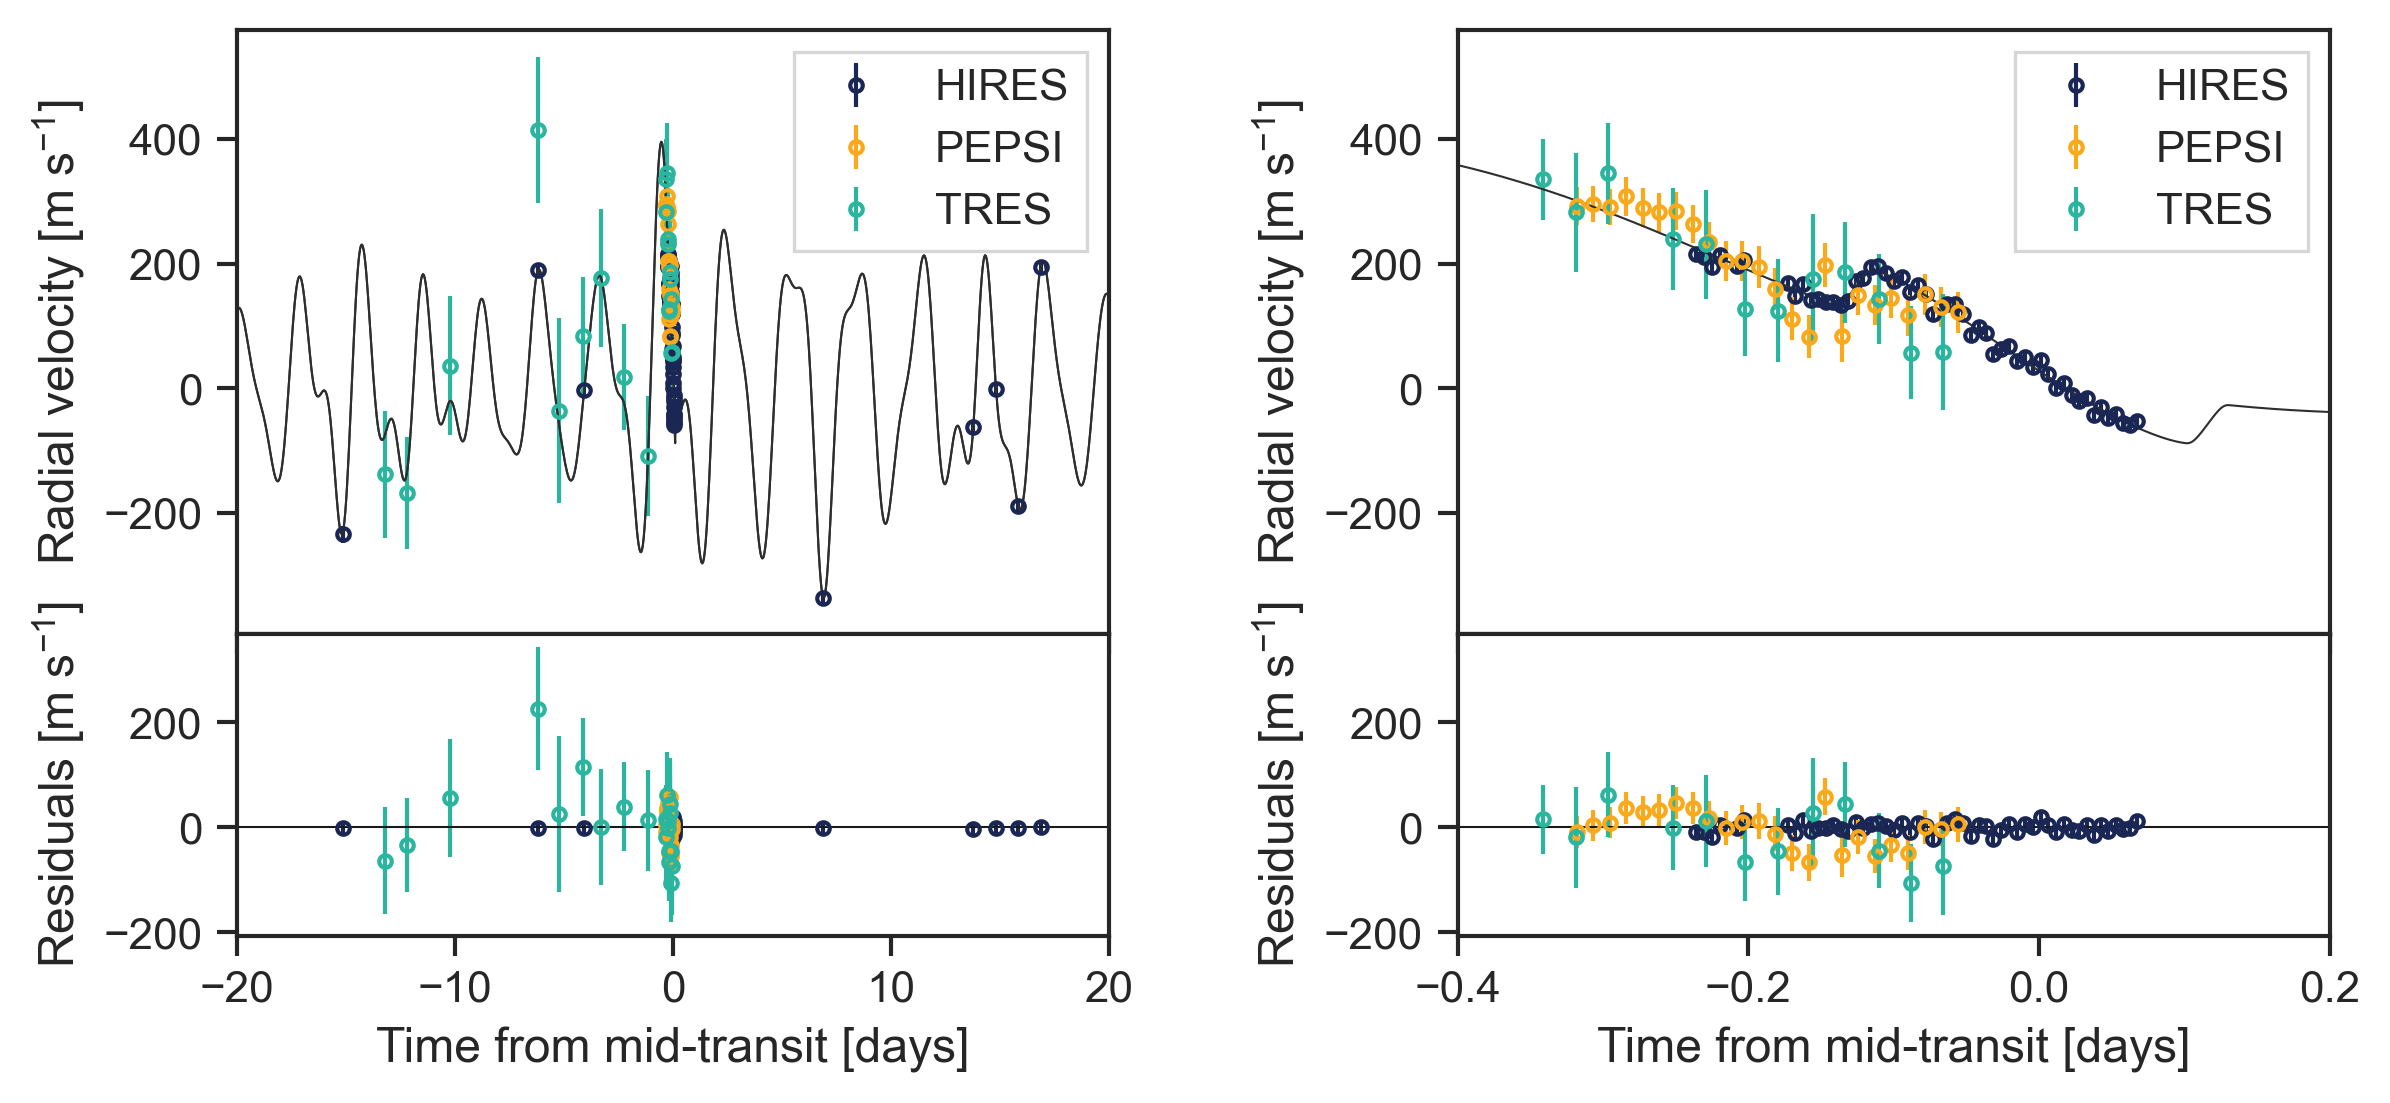

Obliquity [deg]:  6.005745040258344


In [523]:
_ = plot_gp_soln(map_soln_gp_protprio, model_gp_protprio, mask=all_rm, figpath='../figures/map_gp_protprio.pdf')

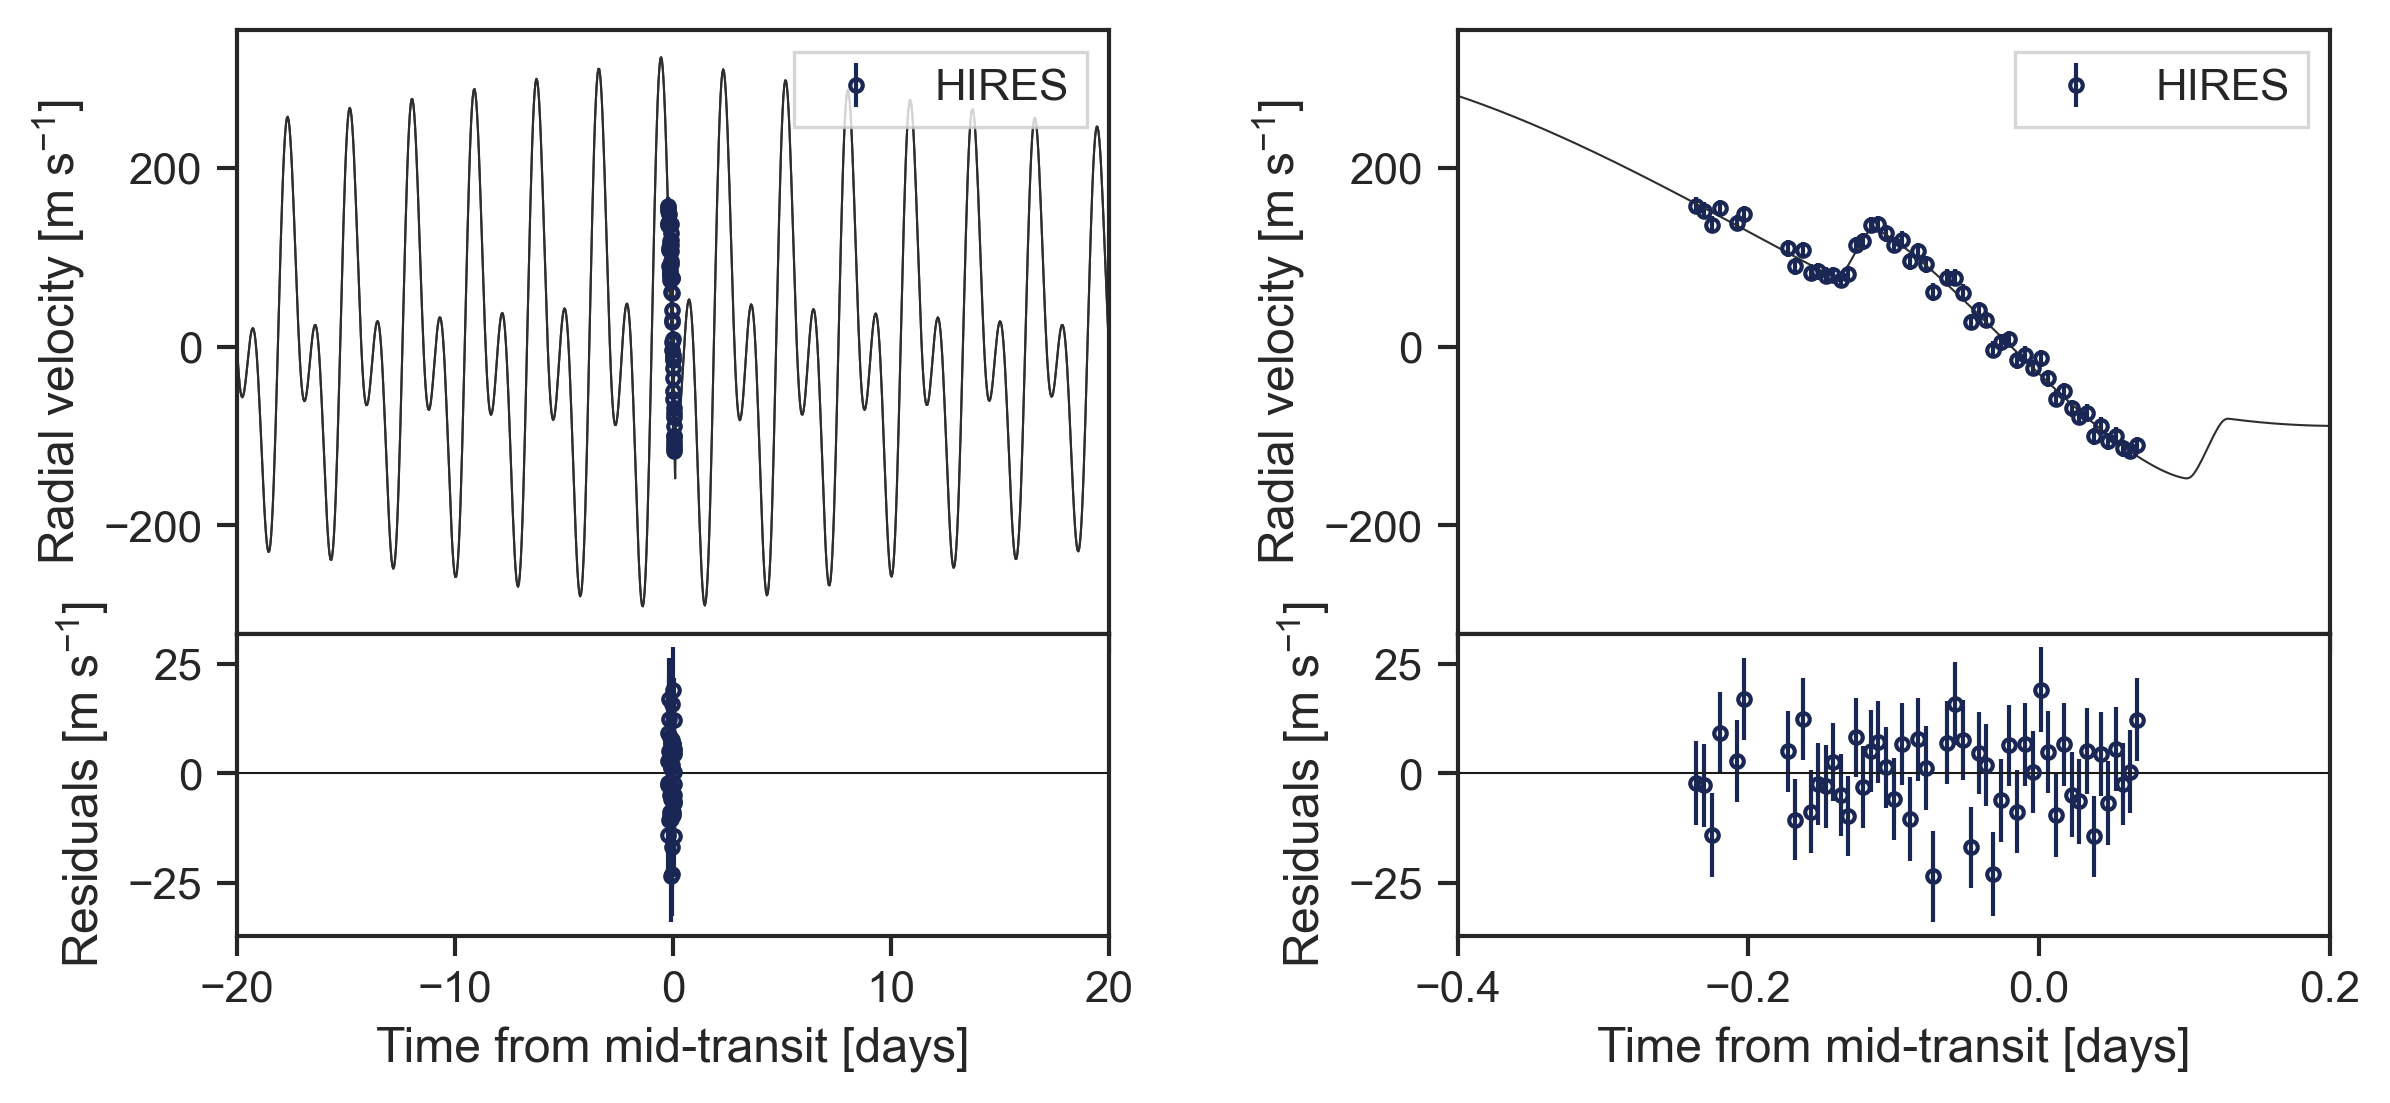

Obliquity [deg]:  1.6260559921568571


In [524]:
_ = plot_gp_soln(map_soln_gp_protprio_hires, model_gp_protprio_hires, mask=hires_rm, figpath='../figures/map_gp_hires_protprio.pdf')

The default 'target_accept' parameter in PyMC3 is 0.9. After some initial sampling and experimenting with the value of this parameter, we found that about 3% of samples were diverging using a 90% proposal acceptance rate. We increased the acceptance rate to 95% and there were no diverging samples with the corresponding decrease in step size.

### Sampling

In [612]:
# def sample_model(model, 
#                  start, 
#                  tune=5000, 
#                  draws=2500, 
#                  chains=2, 
#                  cores=1, 
#                  target_accept=0.95):

#     start_time = timer.time()    
#     with model:
#         trace = pm.sample(
#             tune=tune,
#             draws=draws,
#             start=start,
#             chains=chains,
#             cores=cores,
#             step=xo.get_dense_nuts_step(target_accept=target_accept),
#             random_seed=1298
#         )
        
#     end_time = timer.time()
#     print('Time elapsed:', (end_time-start_time)/60, ' minutes')
#     return trace


import multiprocessing

def sample_model(model, 
                 start, 
                 tune=1500, 
                 draws=1000, 
                 chains=2, 
                 cores=2, 
                 target_accept=0.95):

    start_time = timer.time()    

    with model:
        trace = pm.sample(
            tune=tune,
            draws=draws,
            start=start,
            cores=cores,
            chains=chains,
            target_accept=target_accept,
            return_inferencedata=False,
            random_seed=[1298, 309],
            mp_ctx=multiprocessing.get_context("fork"),
            init="adapt_full",
        )
    
    end_time = timer.time()
    print('Time elapsed:', (end_time-start_time)/60, ' minutes')
    return trace




def get_varnames(trace):
    vnames = []
    for v in trace.varnames:
        
        excluded_list = ['interval',
                    'curve',
                    'err_rv',
                    'model',
                    'trend',
                    'impact',
                    'quadlimbdark',
                    '_ktwo',
                    'pred',
                    'logs_rv',
                    'mean_rv',
                    'gp_rv',
                    'logodds'
                    ]
        
        if any(ele in v for ele in excluded_list)==True:
            continue
        else:
            vnames.append(v)
            
    return vnames

def print_report(trace, var_names, table_path=None):
    
    summary_table = pm.summary(trace, var_names=var_names, round_to=6, fmt='wide')
    if table_path:
        f = open(table_path, "w")
        f.write(summary_table.to_latex())
        f.close()    

    return


def az_report(trace, var_names, table_path=None, 
              kind='stats', 
              fmt='wide',
              round_to=6):
    
    summary_table = az.summary(trace, 
                               var_names=var_names, 
                               round_to=round_to, 
                               fmt=fmt, 
                               kind=kind)
    if table_path:
        f = open(table_path, "w")
        f.write(summary_table.to_latex())
        f.close()    
    
    return summary_table

def true_psi(i_st, i_pl, oblq):
    # Using Equation 9 of Fabrycky & Winn 2009 compute the true 3D obliquity (in degrees)
    # given the stellar inclination, planetary orbital inclination, and sky-projected obliquity
    i_st_rad = i_st * np.pi/180.
    i_pl_rad = i_pl * np.pi/180.
    oblq_rad = oblq * np.pi/180.     
    psi = np.arccos(np.sin(i_st_rad)*np.cos(oblq_rad)*np.sin(i_pl_rad) + np.cos(i_st_rad)*np.cos(i_pl_rad)) 
    return psi*180./np.pi

    
def sampler_pipeline(_model, _map_soln, model_name, tune=1500, draws=1000):
    
    #Run sampler
    trace = sample_model(_model, start=_map_soln, tune=tune, draws=draws)
    #Save the trace
    pm.save_trace(trace, "../samples/"+model_name, overwrite=True)
    
    #Save the summary to a LaTeX table
    print_report(trace, get_varnames(trace), table_path="../tables/"+model_name+'.tex')

    #Save a corner plot
    varnames = ["obliquity", 
                "vsini", 
                "b", 
                "r_star", 
                "prot_model"]
    
    labels = [r'$\mathregular{\lambda}$ [deg]', 
              'vsini [km s$^\mathregular{-1}$]', 
              'b',
              r'R$_\mathregular{\star}$', 
              'P$_\mathregular{rot}$ [d]']
    
    if 'line' in model_name:
        varnames += ["c0", "c1"]
        labels += ['$\mathregular{\gamma}$ [m s$^\mathregular{-1}$]', 
                   '$\mathregular{\dot \gamma}$ [m s$^\mathregular{-1}$ d$^\mathregular{-1}$]']
    
    elif 'quad' in model_name:
        varnames += ["c0", "c1","c2"]
        labels += ["$\mathregular{\gamma}$ [m s$^\mathregular{-1}$]", 
                   "$\mathregular{\dot \gamma}$ [m s$^\mathregular{-1}$ d$^\mathregular{-1}$]",
                   "$\mathregular{\ddot \gamma}$ [m s$^\mathregular{-1}$ d$^\mathregular{-2}$]"]
        
    elif 'gp' in model_name:
        varnames += ["log_sigma_rot", "log_Q0", "log_dQ", "f"]
        labels += ["log($\mathregular{\sigma_{rot}}$)", 
                   "log($\mathregular{Q_0}$)", 
                   "log($\mathregular{\Delta Q}$)", 
                   "f"]


    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    fig = corner.corner(samples, labels=labels);
    plt.savefig("../figures/corner_"+model_name+".pdf")
    plt.close()
    
    return trace



def plot_gp_trace(trace, mask=None, figpath=None):
    ebar_kwargs = {"fmt":"o", "ms":3, "mfc":"None", "lw":1, "mew":1}
    sns.set_palette(tangerine)
    
    
    resid = y_rv[mask] - np.mean(trace["mean_rv"], axis=0)[mask] - np.mean(trace["rm_curve"], axis=0) - np.mean(trace["gp_rv"], axis=0)
    
    rvmodel_mean = np.mean(trace["rv_model_pred"] + trace["gp_rv_pred"] + np.mean(trace["mean_rv"], keepdims=True, axis=1), axis=0) 
    rvmodel = np.percentile(trace["rv_model_pred"] + trace["gp_rv_pred"] + np.mean(trace["mean_rv"], keepdims=True, axis=1), [16.,50.,84.], axis=0)
    
    rvmodel_mean -= np.mean(trace["mean_rv"])
    rvmodel -= np.mean(trace["mean_rv"])
    
    #model_rm = np.nanpercentile(soln['rv_model_pred'] + soln["gp_rv_pred"] + np.vstack([soln["mean_hires"]]*np.shape(soln['rv_model_pred'])[1]).T, [16,50,84], axis=0)     
    
    
    if mask is None:
        mask = np.ones(len(x_rv), dtype=bool)
        
    fig = plt.figure(constrained_layout=False, figsize=(9,4))
    spec = fig.add_gridspec(ncols=2, nrows=2, hspace=0.0, wspace=0.4, width_ratios=[1,1], height_ratios=[2,1])

    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1])

    ax3 = fig.add_subplot(spec[1, 0])
    ax4 = fig.add_subplot(spec[1, 1])    

    for ax in [ax1,ax2]:
        ax.plot(t_rv, rvmodel_mean, color='#808080', lw=0.5)
        art = ax.fill_between(t_rv, rvmodel[0], rvmodel[2], color='#808080', alpha=0.5, zorder=1)
        art.set_edgecolor("none")  

        #for inst in np.unique(inst_id)[::-1]:
        for inst in np.unique(inst_id[mask]):
            _ = inst_id[mask]==inst
            ax.errorbar(x_rv[mask][_], 
                        y_rv[mask][_]-np.mean(trace["mean_rv"], axis=0)[mask][_], 
                        yerr=np.mean(trace["err_rv"], axis=0)[_], 
                        label=inst.upper(), **ebar_kwargs)

        ax.set_ylabel('Radial velocity [m s$^\mathregular{-1}$]', labelpad=10)
        ax.legend(prop={'size':8})
        ax.set_xticklabels([])

        
    for ax in [ax3,ax4]:
        for inst in np.unique(inst_id[mask]):            
            _ = inst_id[mask]==inst
            ax.errorbar(x_rv[mask][_], resid[_], 
                        yerr=np.mean(trace["err_rv"], axis=0)[_], 
                        label=inst.upper(), **ebar_kwargs)
            

        ax.set_xlabel('Time from mid-transit [days]')
        ax.set_ylabel('Residuals [m s$^\mathregular{-1}$]', labelpad=10)
        ax.axhline(0, color='k', lw=0.5)

    
    for ax in [ax1,ax3]:
        ax.set_xlim(-20,20)
    ax3.set_xticks(np.arange(-20,25,5))
    
    ax1.set_ylim(-450,550)
    ax2.set_ylim(-300,450)
    ax4.set_ylim(-200,200)
    ax2.set_xlim(-0.4,0.2)
    ax4.set_xlim(-0.4,0.2)
    
    if figpath:
        plt.savefig(figpath, dpi=300, bbox_inches='tight')
    
    plt.show()
    return


def plot_rm_trace(soln, 
                  gp=False, 
                  savefig=False, 
                  text=None, 
                  mcolor='C1'):
    
    ebar_kwargs = {"fmt":"o", "ms":2, "color":"k", "lw":0.5, "mew":0.5}
    
    tmid = 0.0
    tdur = 24.0*np.median(t14(soln['period'], 
                    soln['a_r'],
                    soln['ror'],
                    soln['b'],
                    np.sin(np.arccos(soln['cosi_pl']))))
    
    if gp==False:
        model_rm = np.nanpercentile(soln['rv_model_pred'], [16,50,84], axis=0)
        resid = hires_rv-np.nanmedian(soln['rv_model'], axis=0)
    elif gp==True:
        model_rm = np.nanpercentile(soln['rv_model_pred'] + soln["gp_rv_pred"] + np.vstack([soln["mean_hires"]]*np.shape(soln['rv_model_pred'])[1]).T, [16,50,84], axis=0) 
        resid = hires_rv - np.nanmedian(soln['rv_model'] + soln["gp_rv"], axis=0) - np.median(soln["mean_hires"], axis=0)
        
    plt.subplot(211)
    if text:
        plt.title(text)
    plt.axvline(0, color='lightgrey', lw=1)
    plt.axvspan(-0.5*tdur, 0.5*tdur, color='lightgrey', alpha=0.2, zorder=0)
    plt.errorbar(24.*(hires_time-tmid), 
                 hires_rv, 
                 yerr=np.nanmedian(soln["err_rv"]), 
                 **ebar_kwargs, label='data', zorder=3)
        
    
    plt.plot(24.*(t_rv-tmid), model_rm[1], color=mcolor, lw=1, zorder=2, label='model')
    
    art = plt.fill_between(24.*(t_rv-tmid), model_rm[0], model_rm[2], color=mcolor, alpha=0.5, zorder=1)
    art.set_edgecolor("none")                            
    

    plt.xticks(np.arange(-6,8,2),[])
    plt.xlim(-6,6)
    plt.ylim(-250,250)
    plt.ylabel('Radial velocity [m s$^\mathregular{-1}$]')
    plt.legend(fancybox=False, loc='lower left')
    
    plt.subplot(212)
    plt.axvline(0, color='lightgrey', lw=1)
    plt.axvspan(-0.5*tdur, 0.5*tdur, color='lightgrey', alpha=0.25, zorder=0, lw=0)    
    plt.axhline(0, color='lightgrey')

    
    rms = np.sqrt(np.median(resid ** 2))
    
    plt.errorbar(24.*(hires_time-tmid), 
                 resid, 
                 yerr=np.nanmedian(soln["err_rv"]), 
                 **ebar_kwargs, zorder=999)
    
    plt.text(0.78,0.05, 
             'rms = \n'+'{:.2f}'.format(rms)+' m s$^\mathregular{-1}$', 
             size=10, transform=plt.gca().transAxes)
    
    plt.xlim(-6,6)
    plt.xlabel('Time from mid-transit [hours]')
    plt.ylabel(r'Residuals [m s$^\mathregular{-1}$]', labelpad=10)
    plt.gcf().set_size_inches(4,4)
    plt.subplots_adjust(hspace=0)
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')    
    plt.show()

### Sampling

In [57]:
# sampler_pipeline(model_line, 
#                  map_soln_line,
#                  "line", tune=5000, draws=2500)

sampler_pipeline(model_line, 
                 map_soln_line,
                 "line")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefd2bd8040>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefd2bd8040>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncS

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 2583 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9001439078630774, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Time elapsed: 43.89900130033493  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 53 variables>

In [61]:
sampler_pipeline(model_line_protprio, 
                 map_soln_line_protprio,
                 "line_protprio")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb1086280>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.ten

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c1, c0, logs_rv, obliquity_rad, cosi_st, vsini, logjit_ktwo, logjit_spitz, mean_spitz, mean_ktwo, u_star_ir, u_star, b, ror, t0, period, r_star, m_star]
INFO:pymc3:N

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 877 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 877 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Time elapsed: 15.465086050828297  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 53 variables>

In [62]:
sampler_pipeline(model_quad, 
                 map_soln_quad,
                 "quad")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefb2940a90>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.ten

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c2, c1, c0, logs_rv, obliquity_rad, cosi_st, vsini, logjit_ktwo, logjit_spitz, mean_spitz, mean_ktwo, u_star_ir, u_star, b, ror, t0, period, r_star, m_star]
INFO:pym

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 29167 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 29167 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


Time elapsed: 632.9263352632522  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 54 variables>

In [63]:
sampler_pipeline(model_quad_protprio, 
                 map_soln_quad_protprio,
                 "quad_protprio")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef7364bbe0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.ten

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c2, c1, c0, logs_rv, obliquity_rad, cosi_st, vsini, logjit_ktwo, logjit_spitz, mean_spitz, mean_ktwo, u_star_ir, u_star, b, ror, t0, period, r_star, m_star]
INFO:pym

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 1265 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 1265 seconds.


Time elapsed: 22.10311985015869  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 54 variables>

In [75]:
sampler_pipeline(model_gp_hires, 
                 map_soln_gp_hires,
                 "gp_hires")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef63d89730>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.ten

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, log_dQ, log_Q0, log_sigma_rot, mean_hires, logs_rv, obliquity_rad, cosi_st, vsini, logjit_ktwo, logjit_spitz, mean_spitz, mean_ktwo, u_star_ir, u_star, b, ror, t0

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 2064 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 2064 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


Time elapsed: 35.6341726342837  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 58 variables>

In [76]:
sampler_pipeline(model_gp_protprio_hires, 
                 map_soln_gp_protprio_hires,
                 "gp_protprio_hires")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef81c28550>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.ten

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, log_dQ, log_Q0, log_sigma_rot, mean_hires, logs_rv, obliquity_rad, cosi_st, vsini, logjit_ktwo, logjit_spitz, mean_spitz, mean_ktwo, u_star_ir, u_star, b, ror, t0

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 1875 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 1875 seconds.


Time elapsed: 32.301695517698924  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 58 variables>

In [77]:
sampler_pipeline(model_gp, 
                 map_soln_gp,
                 "gp")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fef733674f0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.ten

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 2166 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 2166 seconds.


Time elapsed: 37.32915163437526  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 65 variables>

In [78]:
sampler_pipeline(model_gp_protprio, 
                 map_soln_gp_protprio,
                 "gp_protprio")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fefc454bf70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.ten

Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 2116 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 2116 seconds.


Time elapsed: 36.46287636756897  minutes


/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<MultiTrace: 2 chains, 1000 iterations, 65 variables>

# Load traces 
Skip the sampling step above if you only want to inspect the fits and chains. You'll still need to instantiate the models during the initial optimization step.

In [403]:
trace_line = pm.load_trace(directory="../samples/line/", model=model_line)
trace_line_protprio = pm.load_trace(directory="../samples/line_protprio/", model=model_line_protprio)

trace_quad = pm.load_trace(directory="../samples/quad/", model=model_quad)
trace_quad_protprio = pm.load_trace(directory="../samples/quad_protprio/", model=model_quad_protprio)

trace_gp = pm.load_trace(directory="../samples/gp/", model=model_gp)
trace_gp_protprio = pm.load_trace(directory="../samples/gp_protprio/", model=model_gp_protprio)

trace_gp_hires = pm.load_trace(directory="../samples/gp_hires/", model=model_gp_hires)
trace_gp_protprio_hires = pm.load_trace(directory="../samples/gp_protprio_hires/", model=model_gp_protprio_hires)

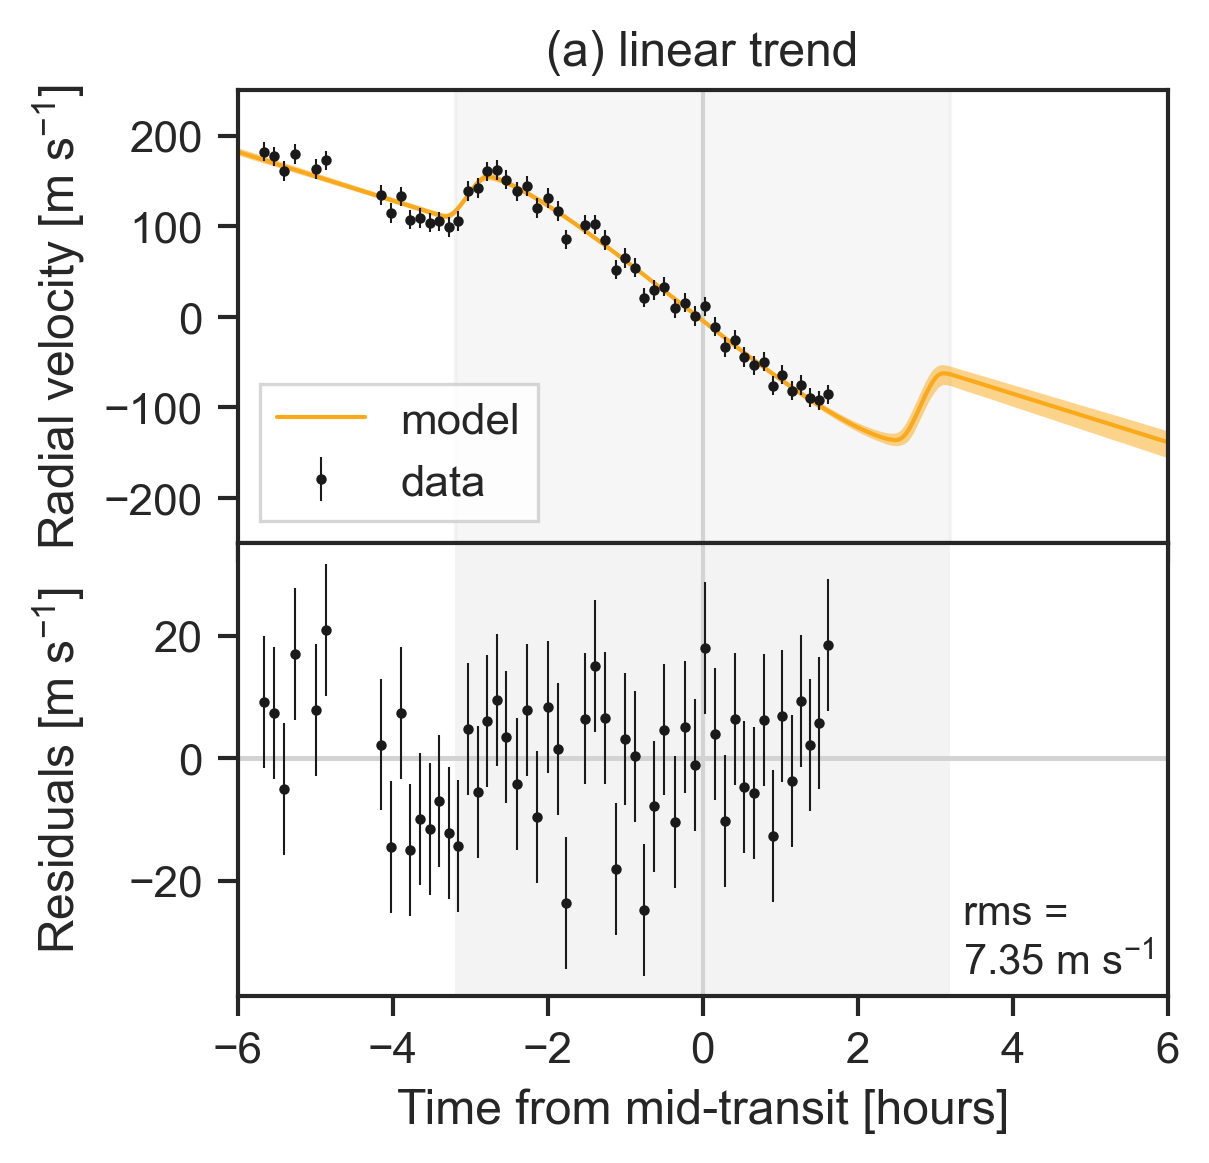

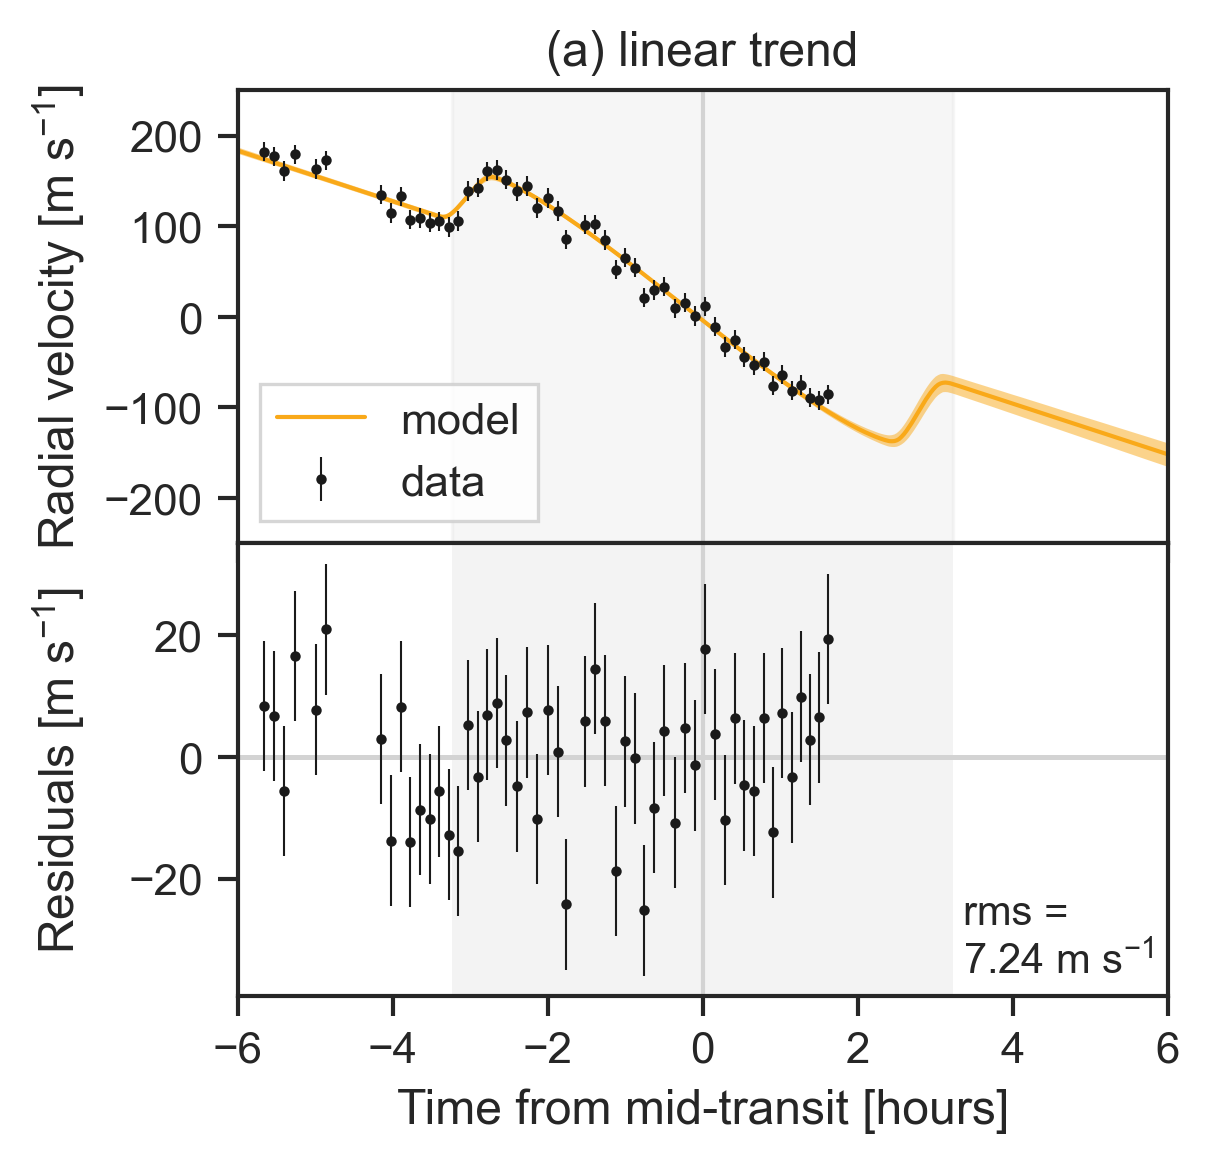

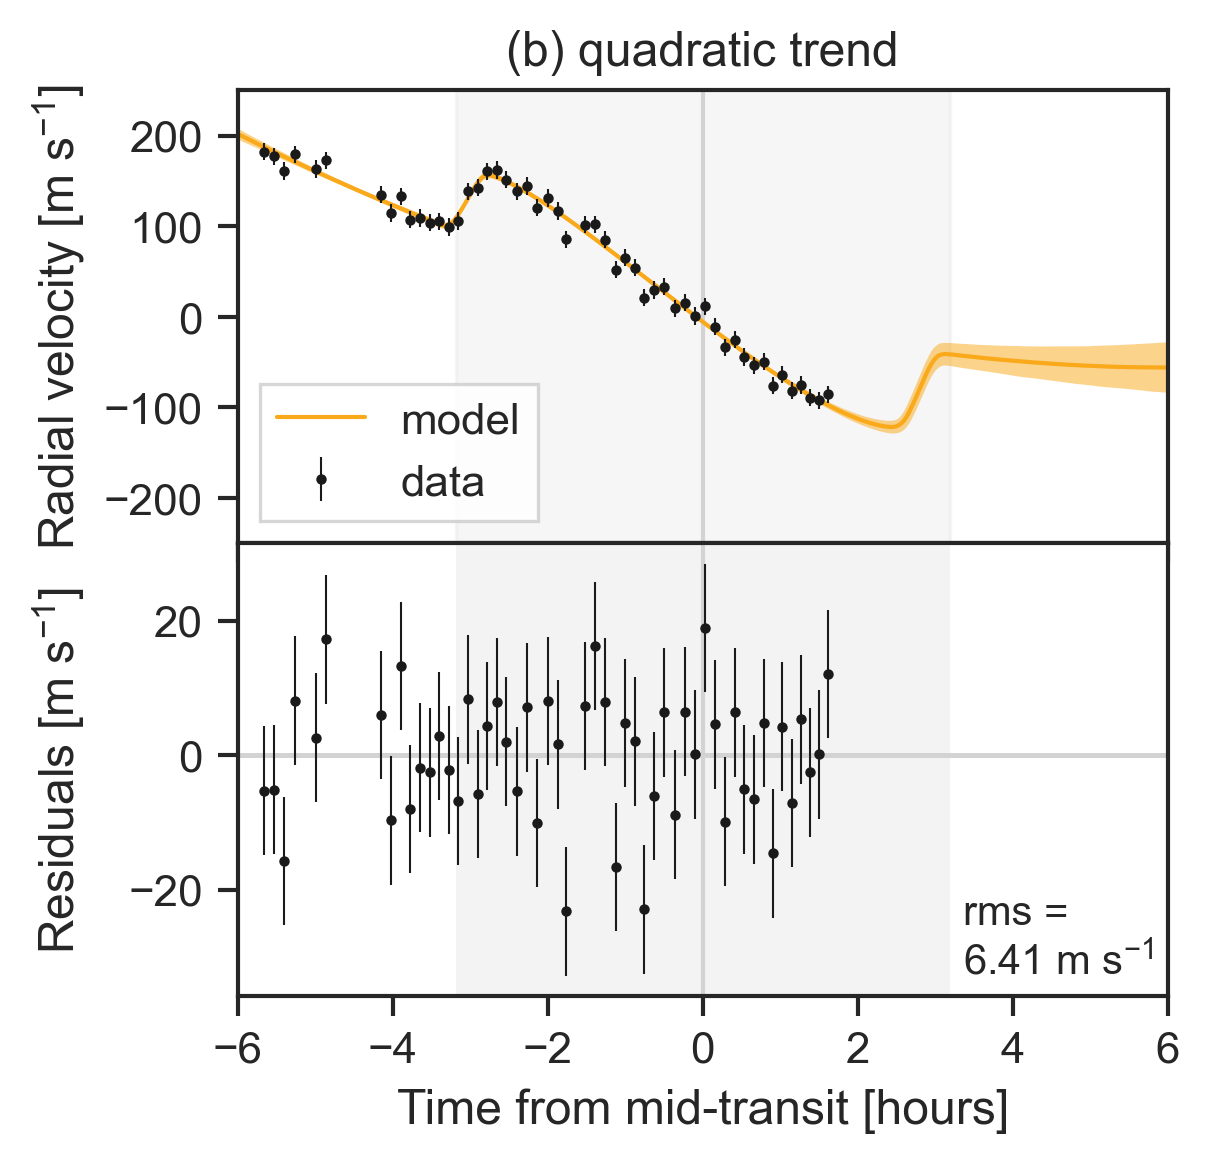

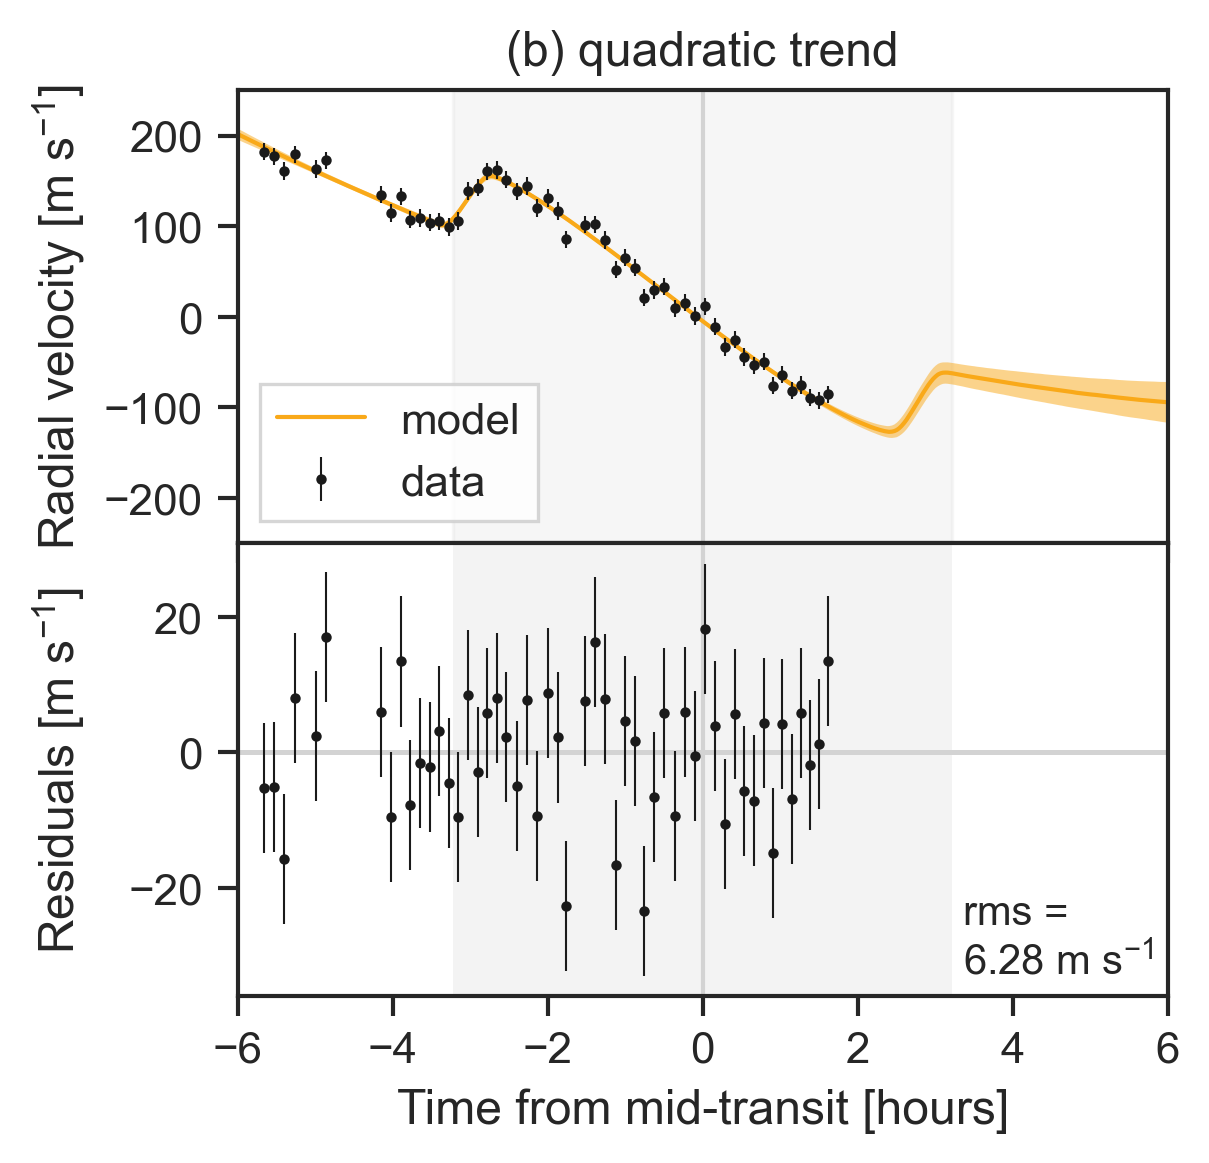

In [420]:
plot_rm_trace(trace_line, text='(a) linear trend', mcolor='C1', savefig='../figures/rm_line.pdf')
plot_rm_trace(trace_line_protprio, text='(a) linear trend', mcolor='C1', savefig='../figures/rm_line_protprio.pdf')
plot_rm_trace(trace_quad, text='(b) quadratic trend', mcolor='C1', savefig='../figures/rm_quad.pdf')
plot_rm_trace(trace_quad_protprio, text='(b) quadratic trend', mcolor='C1', savefig='../figures/rm_quad_protprio.pdf')

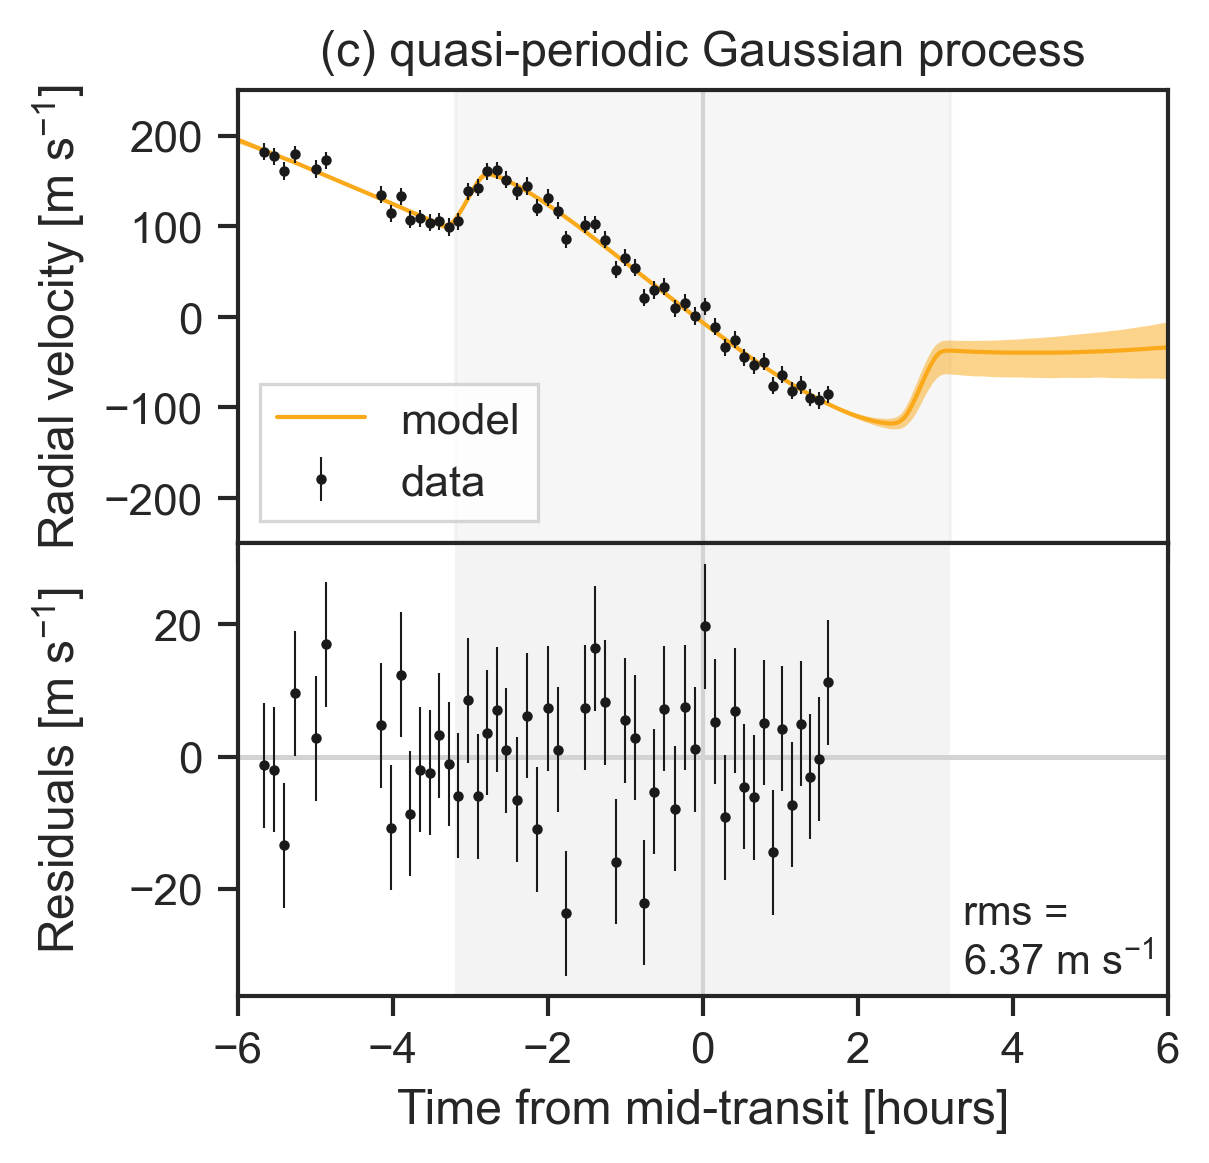

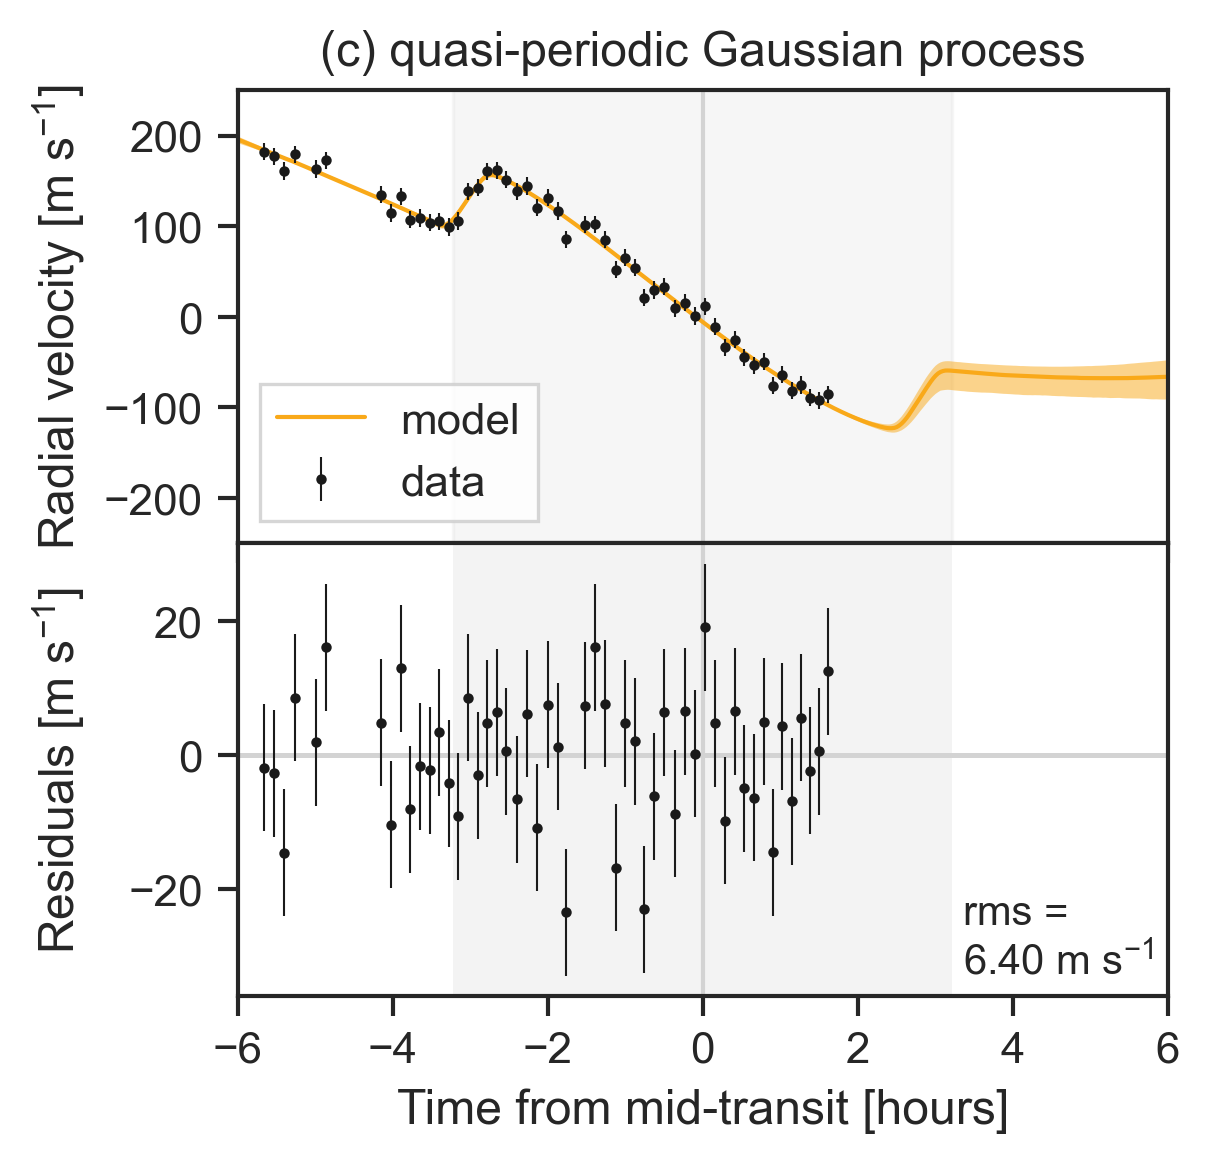

In [421]:
plot_rm_trace(trace_gp_hires, gp=True, text='(c) quasi-periodic Gaussian process', mcolor='C1', savefig='../figures/rm_gp.pdf')
plot_rm_trace(trace_gp_protprio_hires, gp=True, text='(c) quasi-periodic Gaussian process', mcolor='C1', savefig='../figures/rm_gp_protprio.pdf')

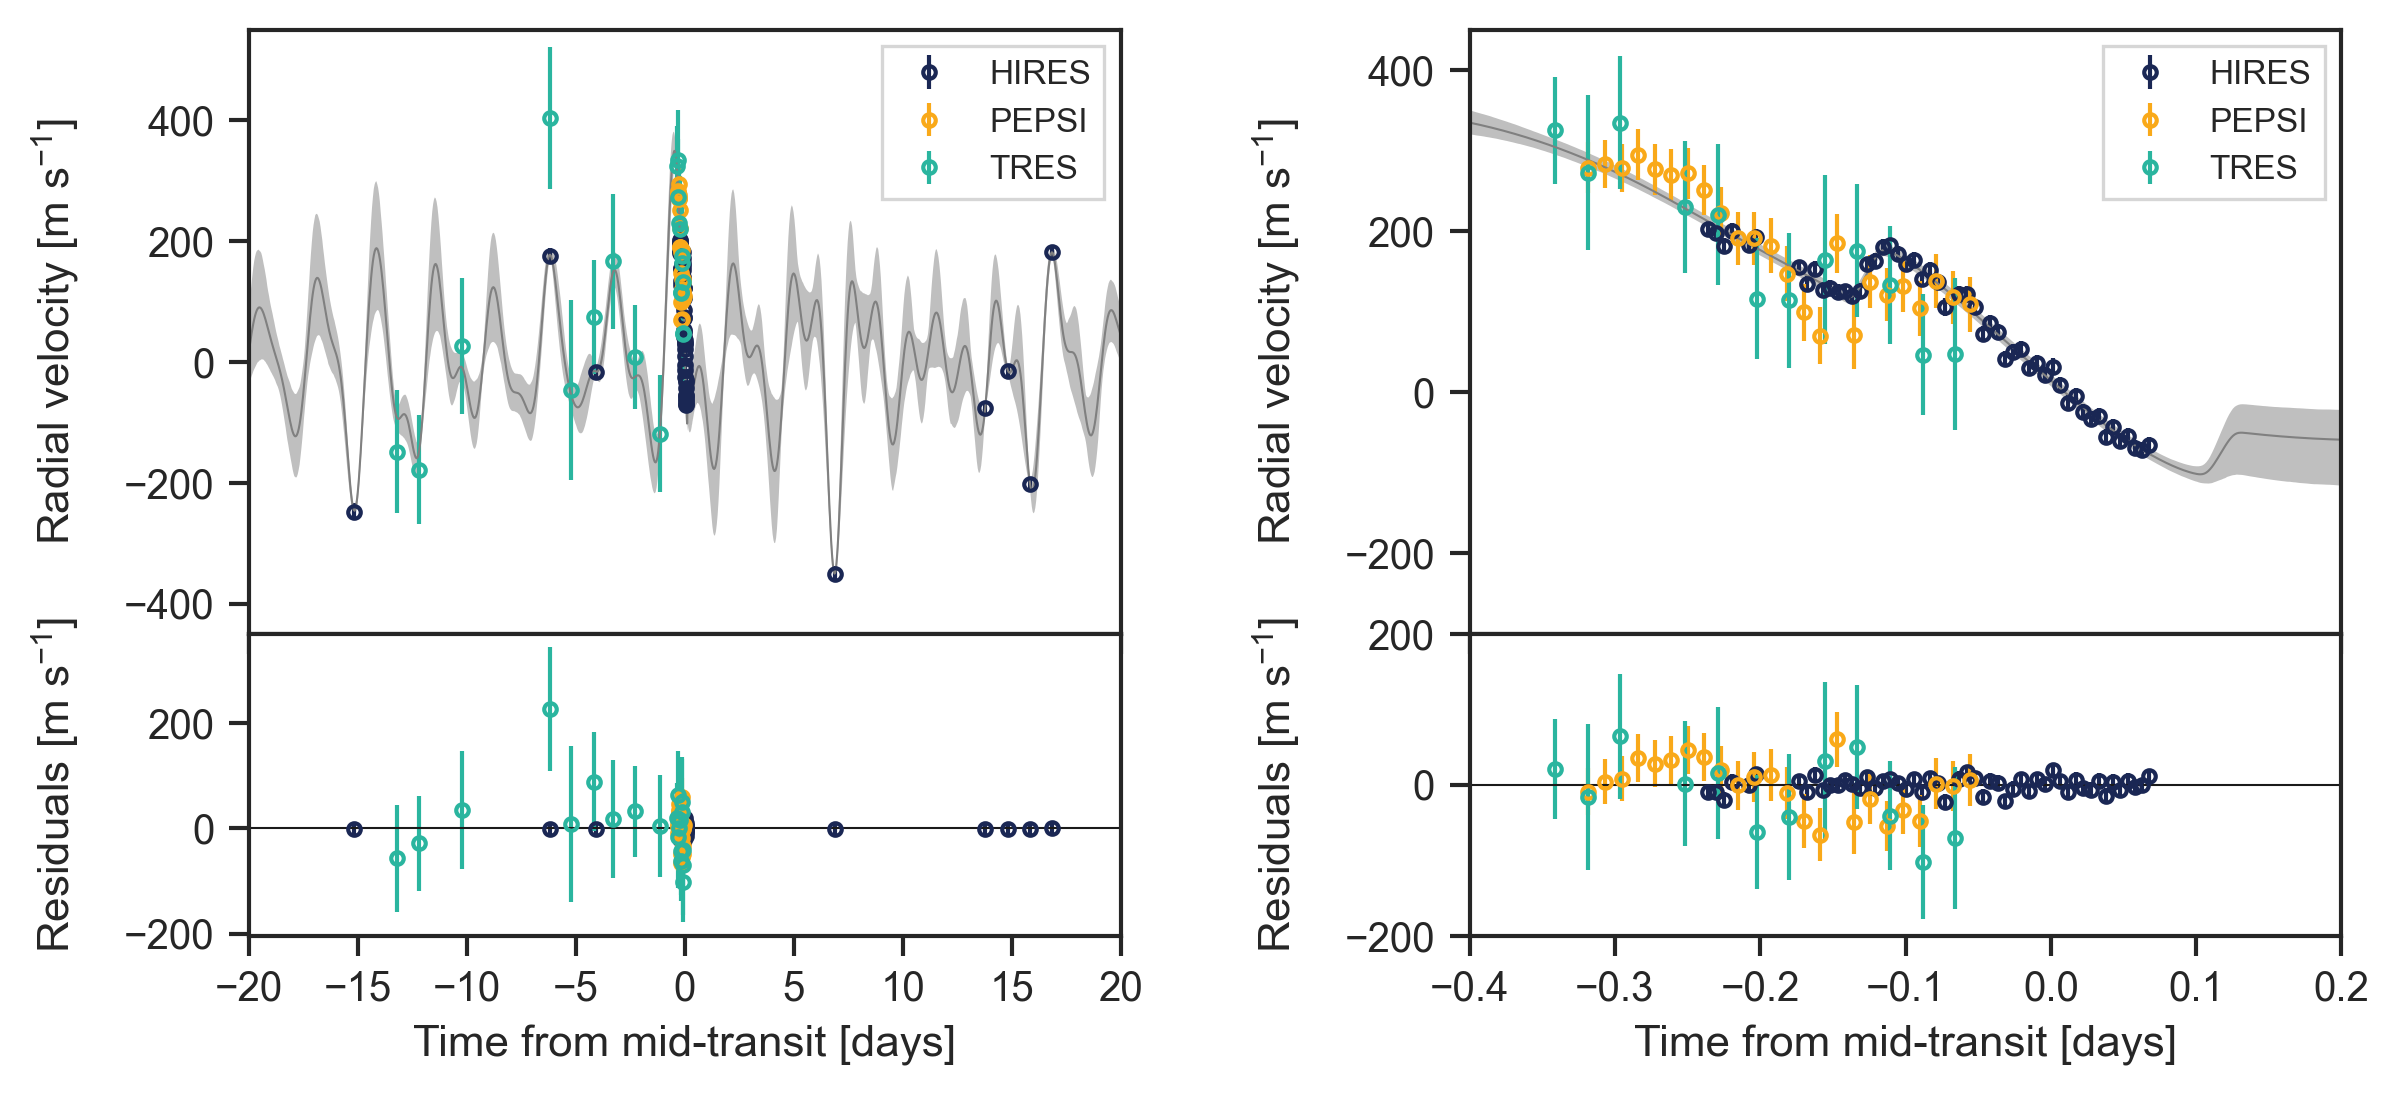

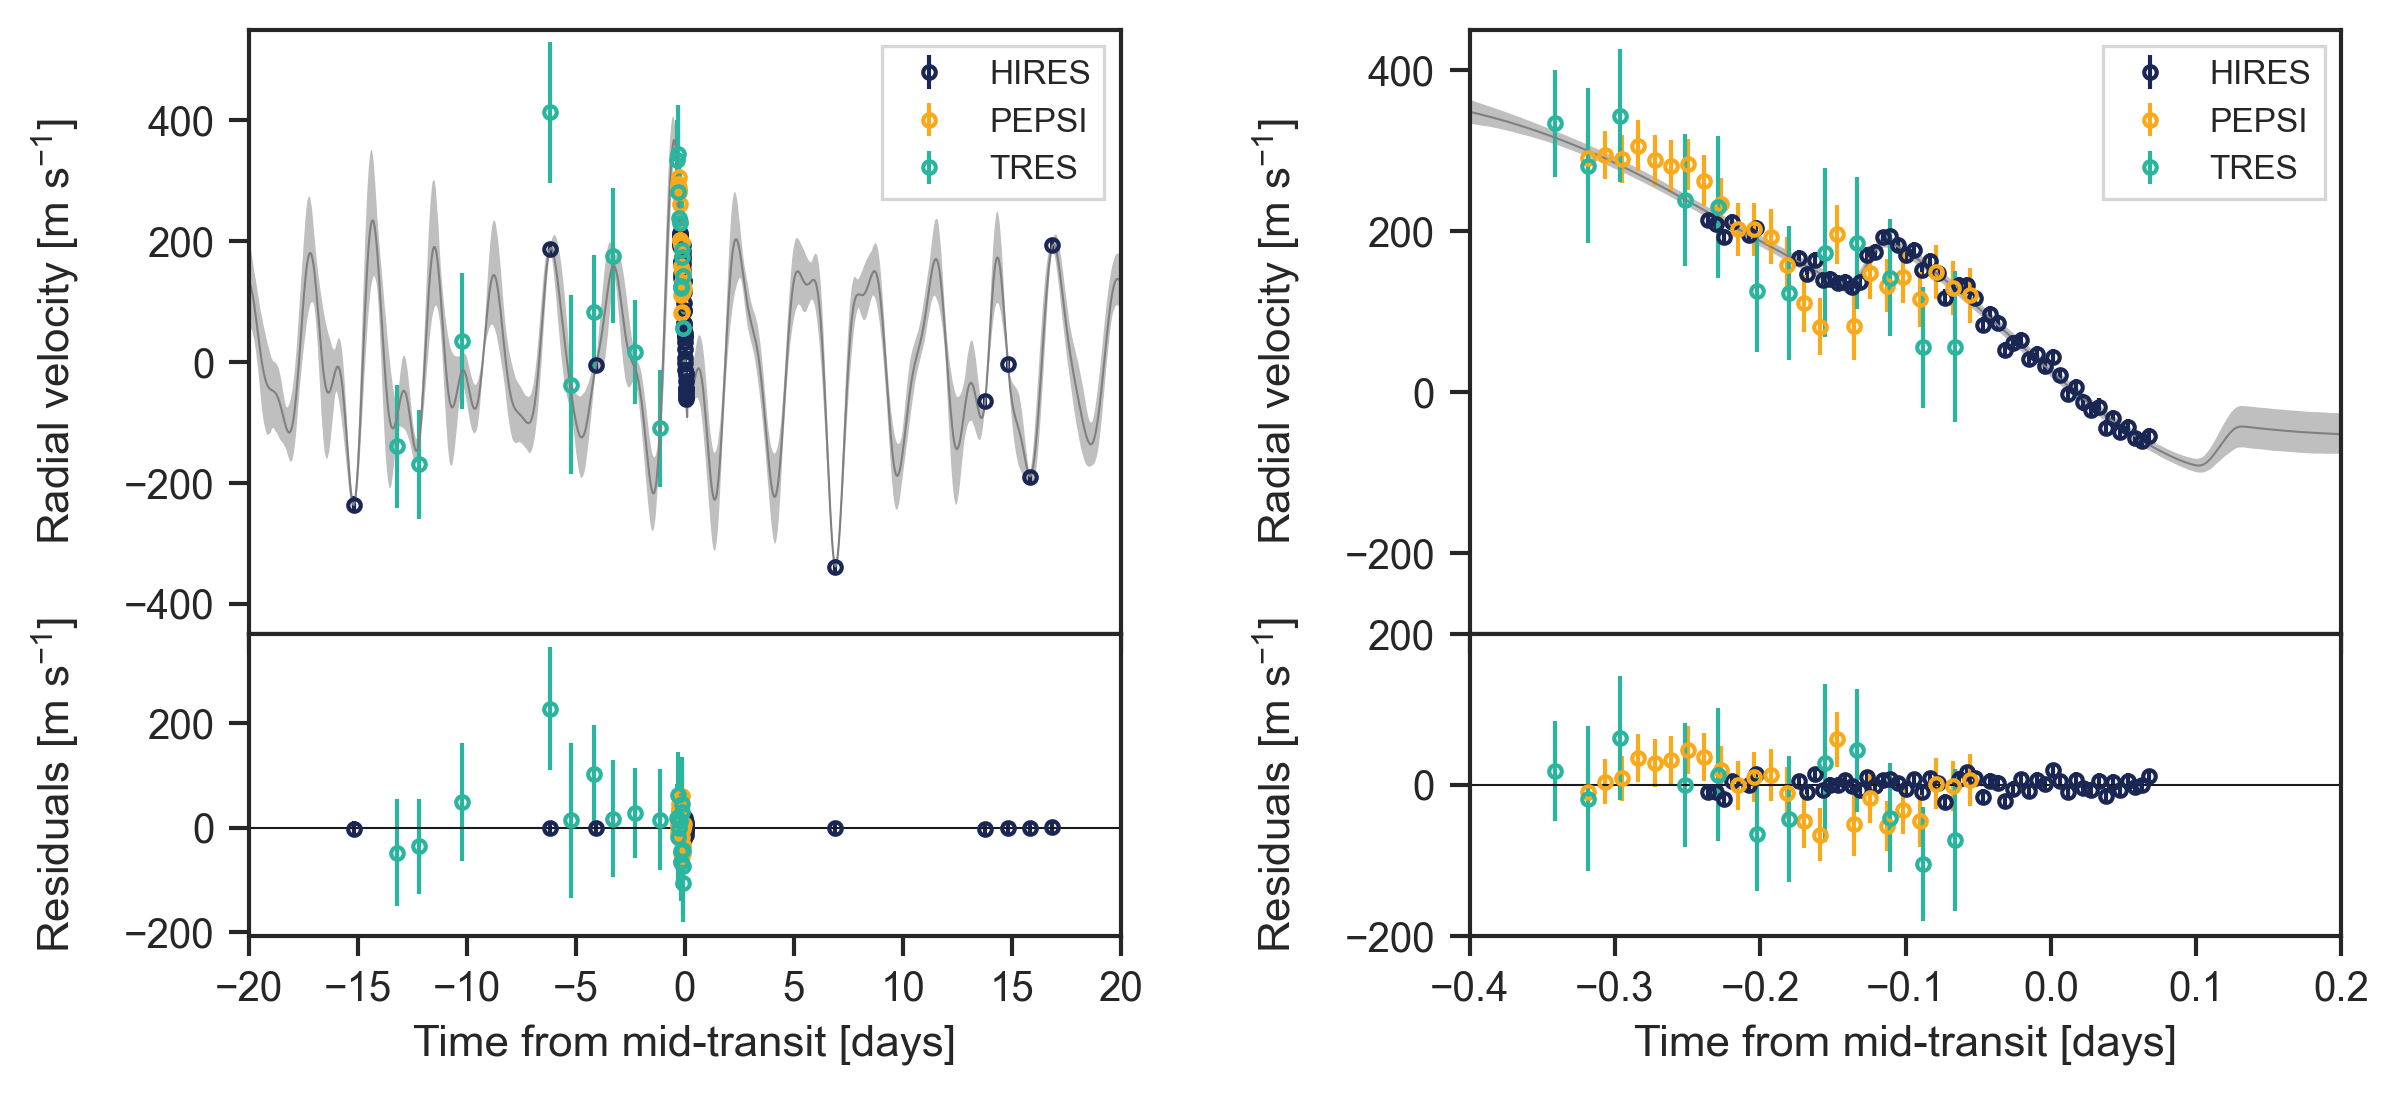

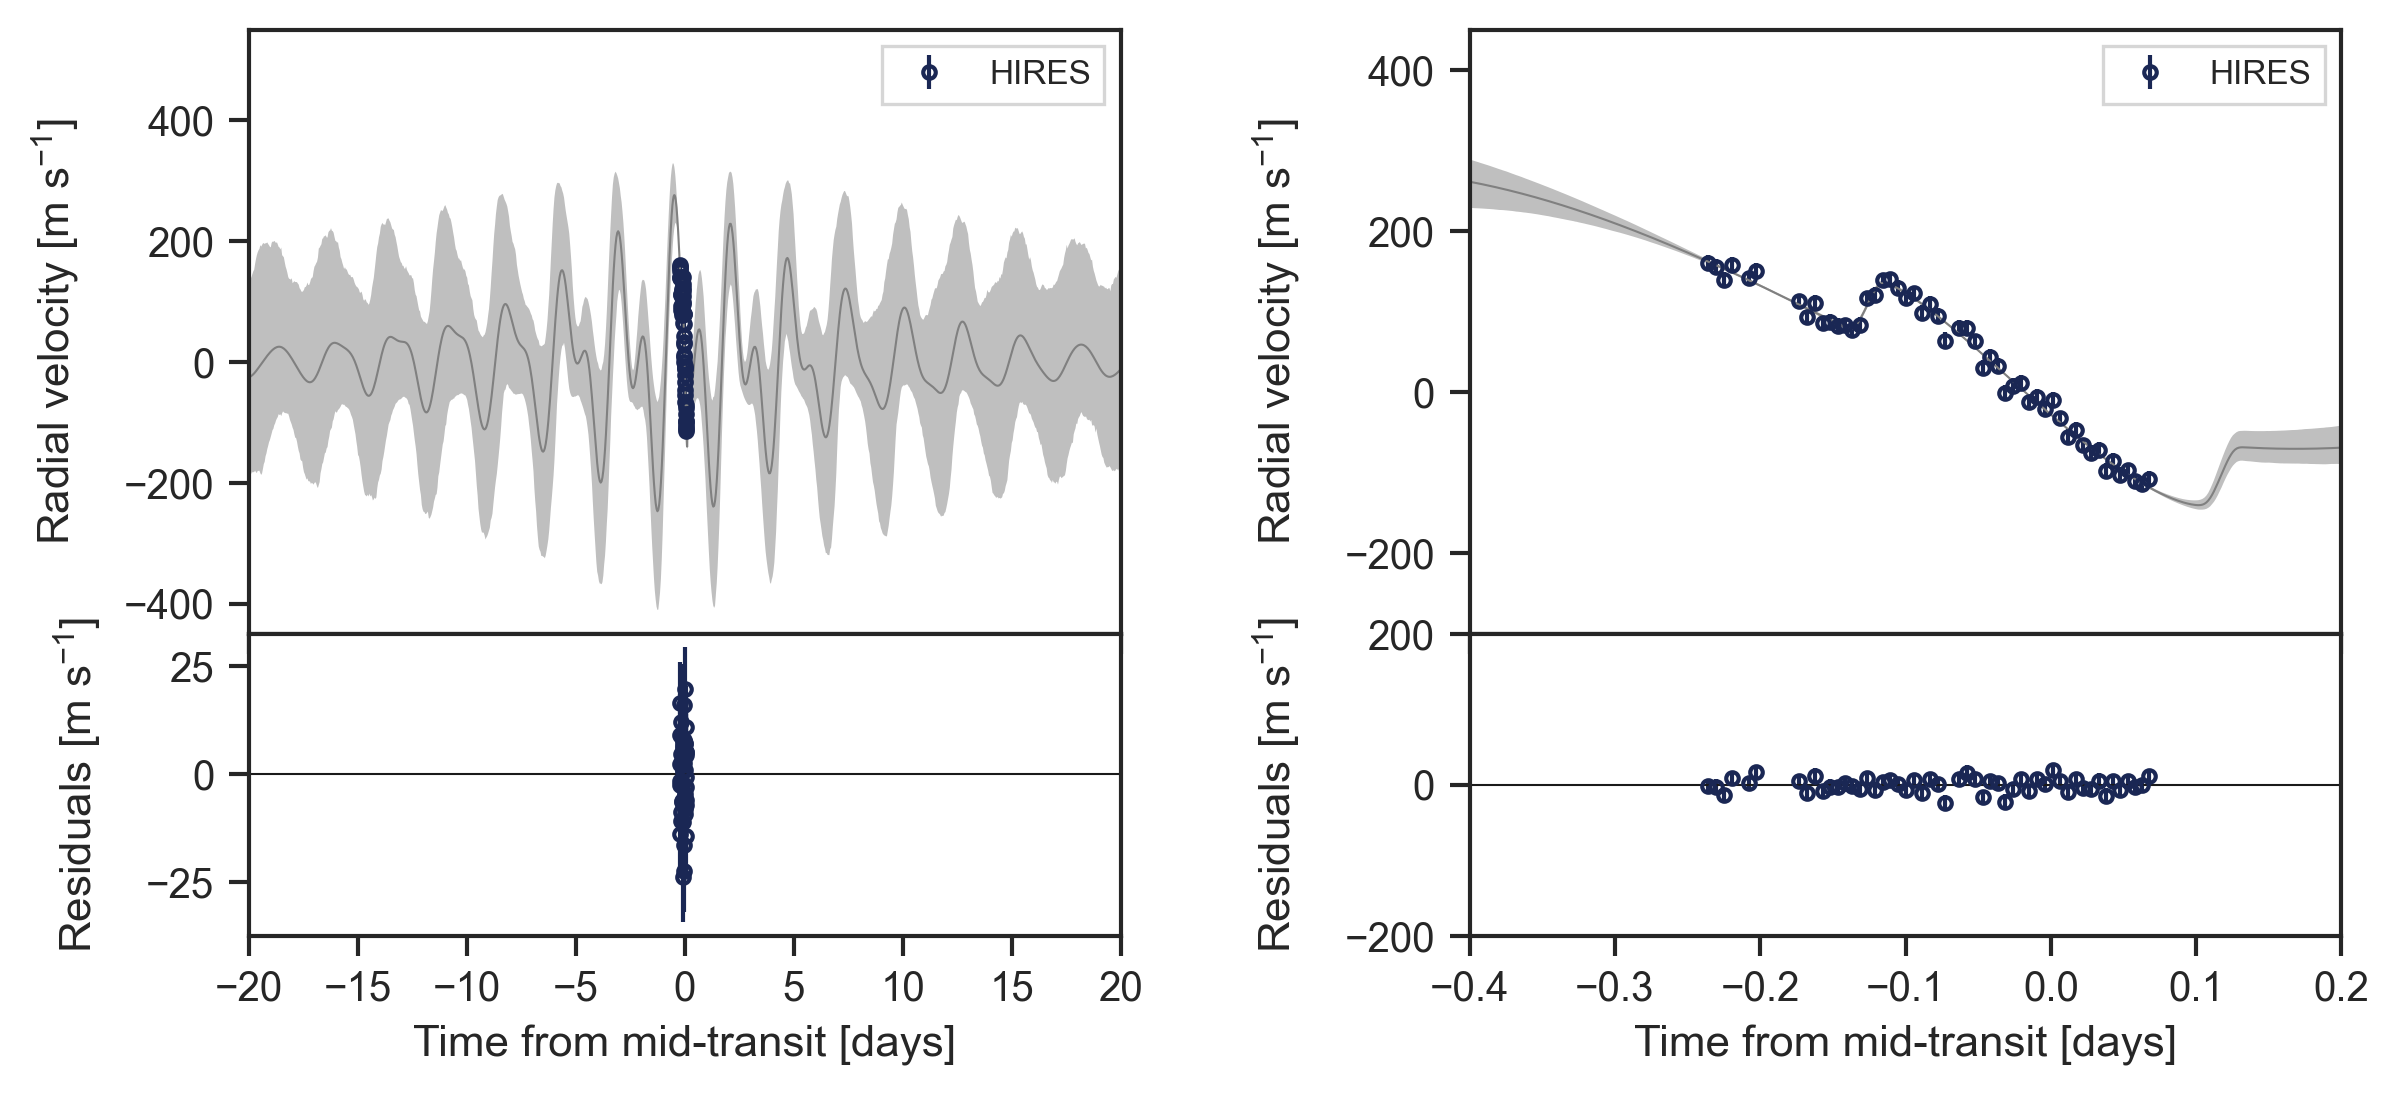

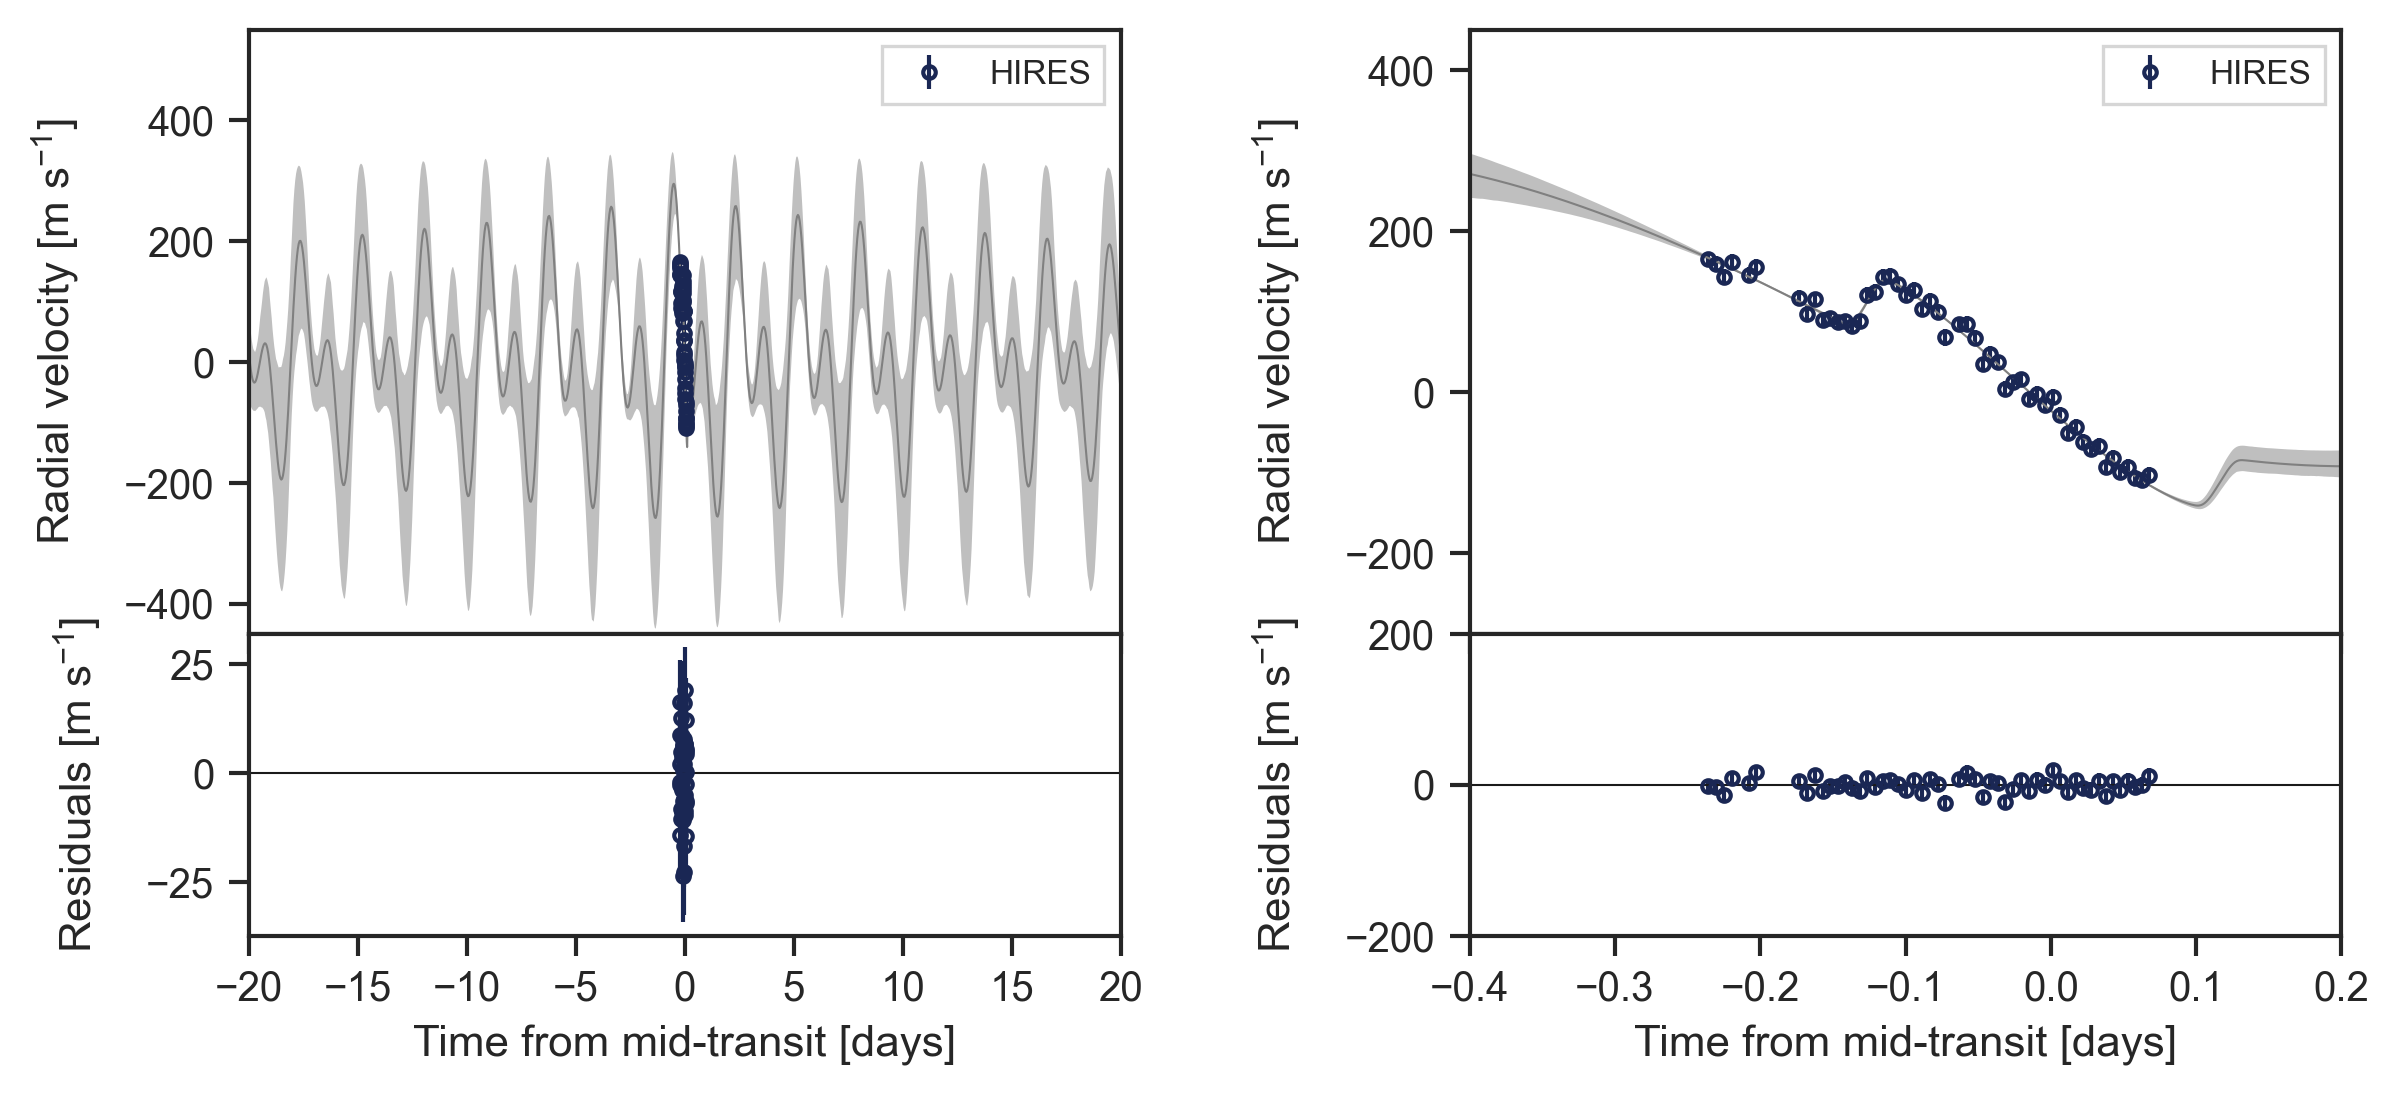

In [613]:
plot_gp_trace(trace_gp, mask=all_rm, figpath='../figures/gp_fit.pdf')
plot_gp_trace(trace_gp_protprio, mask=all_rm, figpath='../figures/gp_protprio_fit.pdf')
plot_gp_trace(trace_gp_hires, mask=hires_rm, figpath='../figures/gp_hires_fit.pdf')
plot_gp_trace(trace_gp_protprio_hires, mask=hires_rm, figpath='../figures/gp_protprio_hires_fit.pdf')

# Make LaTeX table for preferred model

In [182]:
idata_gp_protprio_hires = az.from_pymc3(trace_gp_protprio_hires, model=model_gp_protprio_hires)

results = az.summary(idata_gp_protprio_hires, 
                     var_names=get_varnames(trace_gp_protprio_hires), 
                     round_to=6, 
                     fmt='wide',
                     kind='stats')

results.to_latex(buf='../tables/results.tex')
results.to_csv('../tables/results.csv')

### Check fraction of diverging samples

In [174]:
model_names = ["Linear",
               "Linear + Prot prior",
               "Quadratic",
               "Quadratic + Prot prior",
               "GP",
               "GP + Prot prior",
               "GP (HIRES only)",
               "GP + Prot prior (HIRES only)"]

for i,trace in enumerate([trace_line,
             trace_line_protprio,
             trace_quad,
             trace_quad_protprio,
             trace_gp,
             trace_gp_protprio,
             trace_gp_hires,
             trace_gp_protprio_hires]):
    
    print(model_names[i])
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size/len(trace)
    print('Percentage of Divergent %.5f' % divperc)
    print('='*40)

Linear
Number of Divergent 8
Percentage of Divergent 0.00800
Linear + Prot prior
Number of Divergent 2
Percentage of Divergent 0.00200
Quadratic
Number of Divergent 0
Percentage of Divergent 0.00000
Quadratic + Prot prior
Number of Divergent 0
Percentage of Divergent 0.00000
GP
Number of Divergent 0
Percentage of Divergent 0.00000
GP + Prot prior
Number of Divergent 0
Percentage of Divergent 0.00000
GP (HIRES only)
Number of Divergent 0
Percentage of Divergent 0.00000
GP + Prot prior (HIRES only)
Number of Divergent 0
Percentage of Divergent 0.00000


In [149]:
def return_max_logp(trace, model):
    _logp = list(map(model.logp, trace))
    return (np.max(_logp))

# return_max_logp(trace_line, model_line)
# return_max_logp(trace_line_protprio, model_line_protprio)
# return_max_logp(trace_quad, model_quad)
# return_max_logp(trace_quad_protprio, model_quad_protprio)
# return_max_logp(trace_gp_hires, model_gp_hires)
# return_max_logp(trace_gp_protprio_hires, model_gp_protprio_hires)
# return_max_logp(trace_gp, model_gp)
# return_max_logp(trace_gp_protprio, model_gp_protprio)

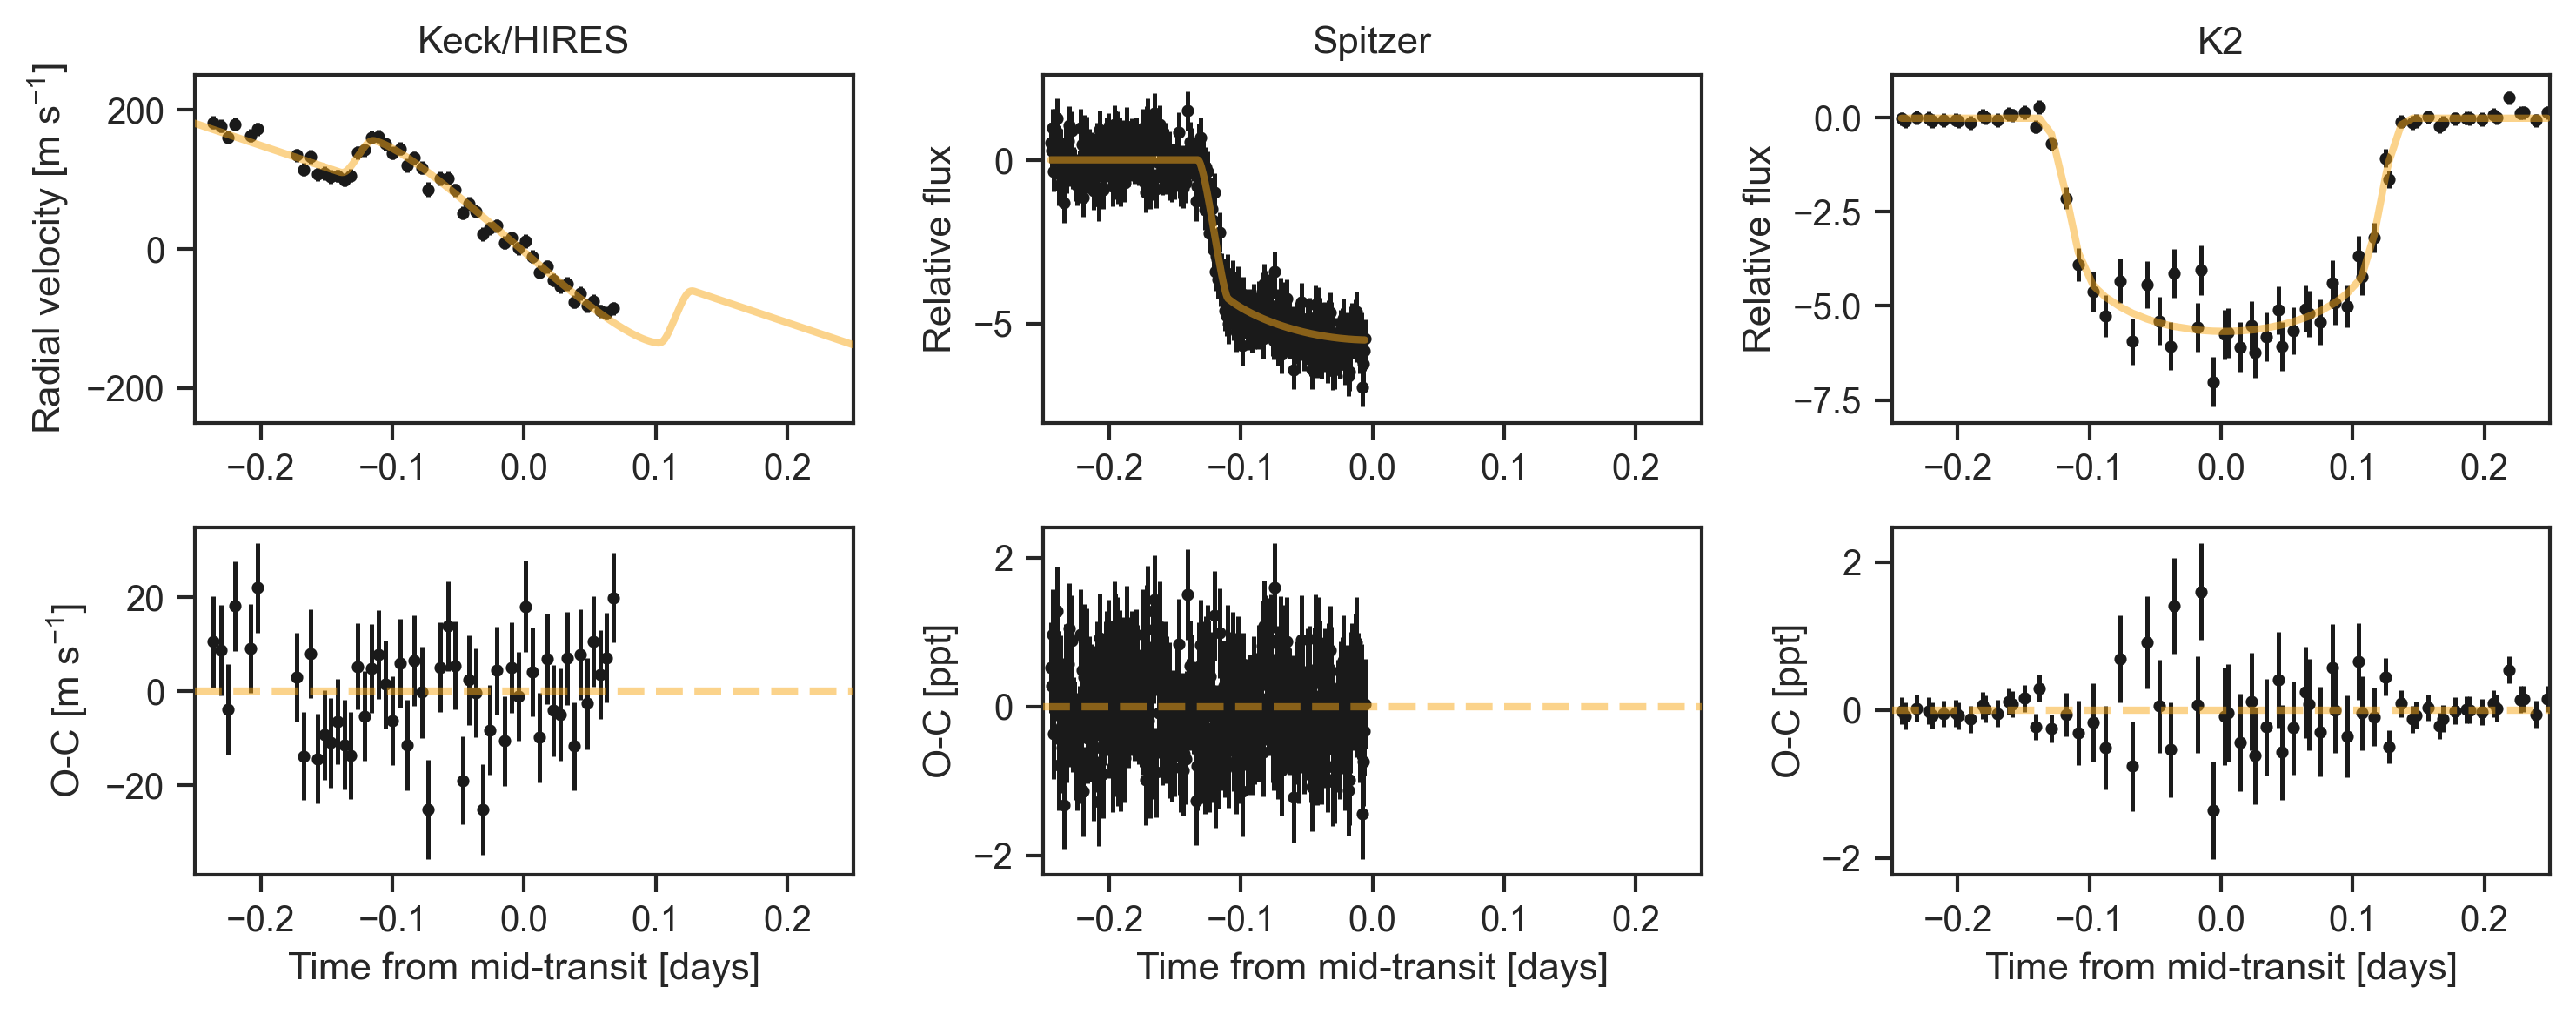

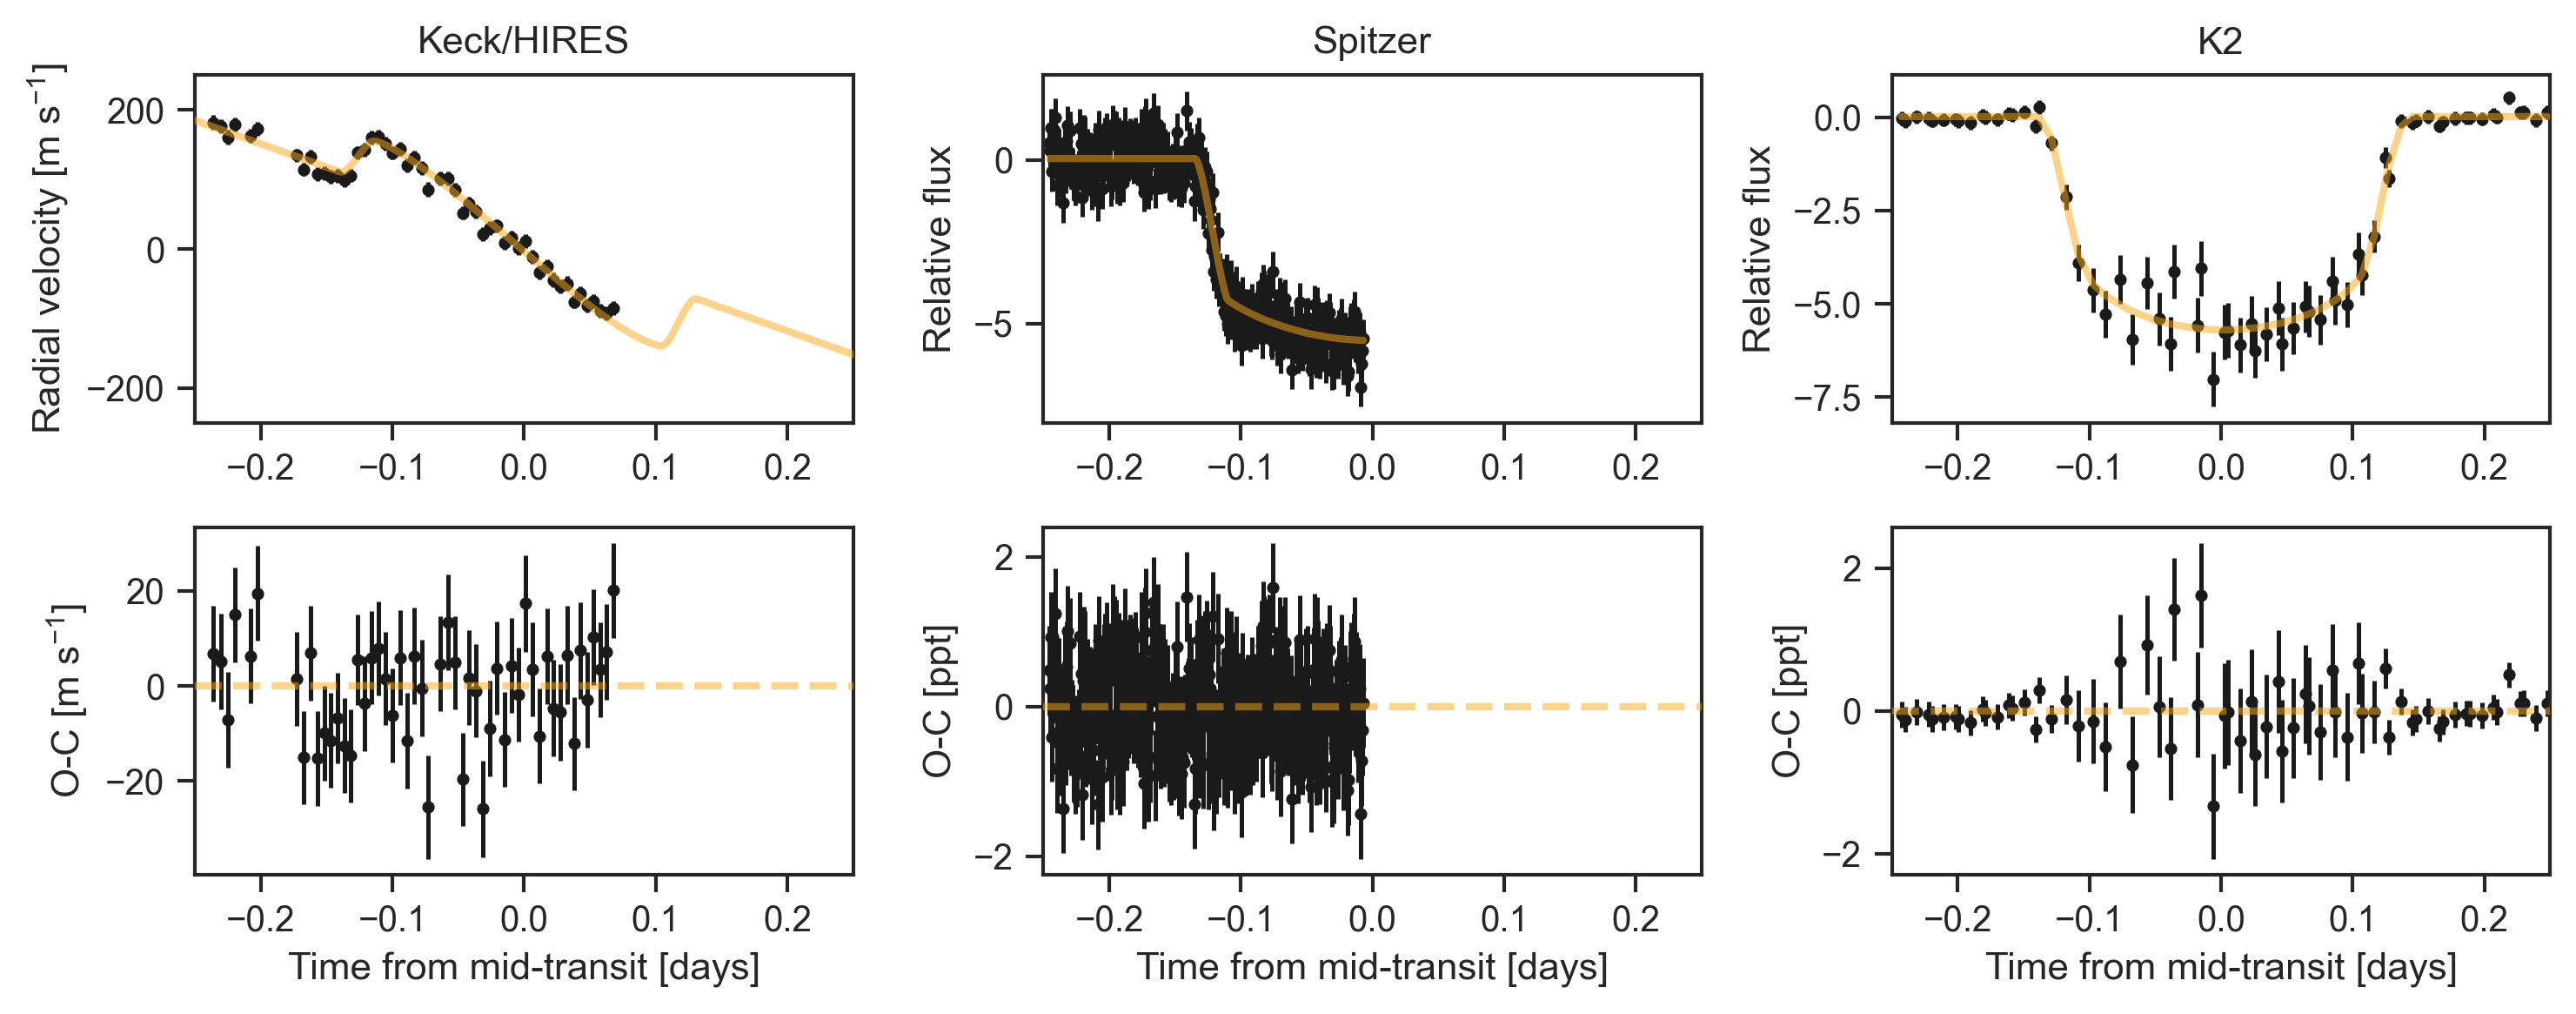

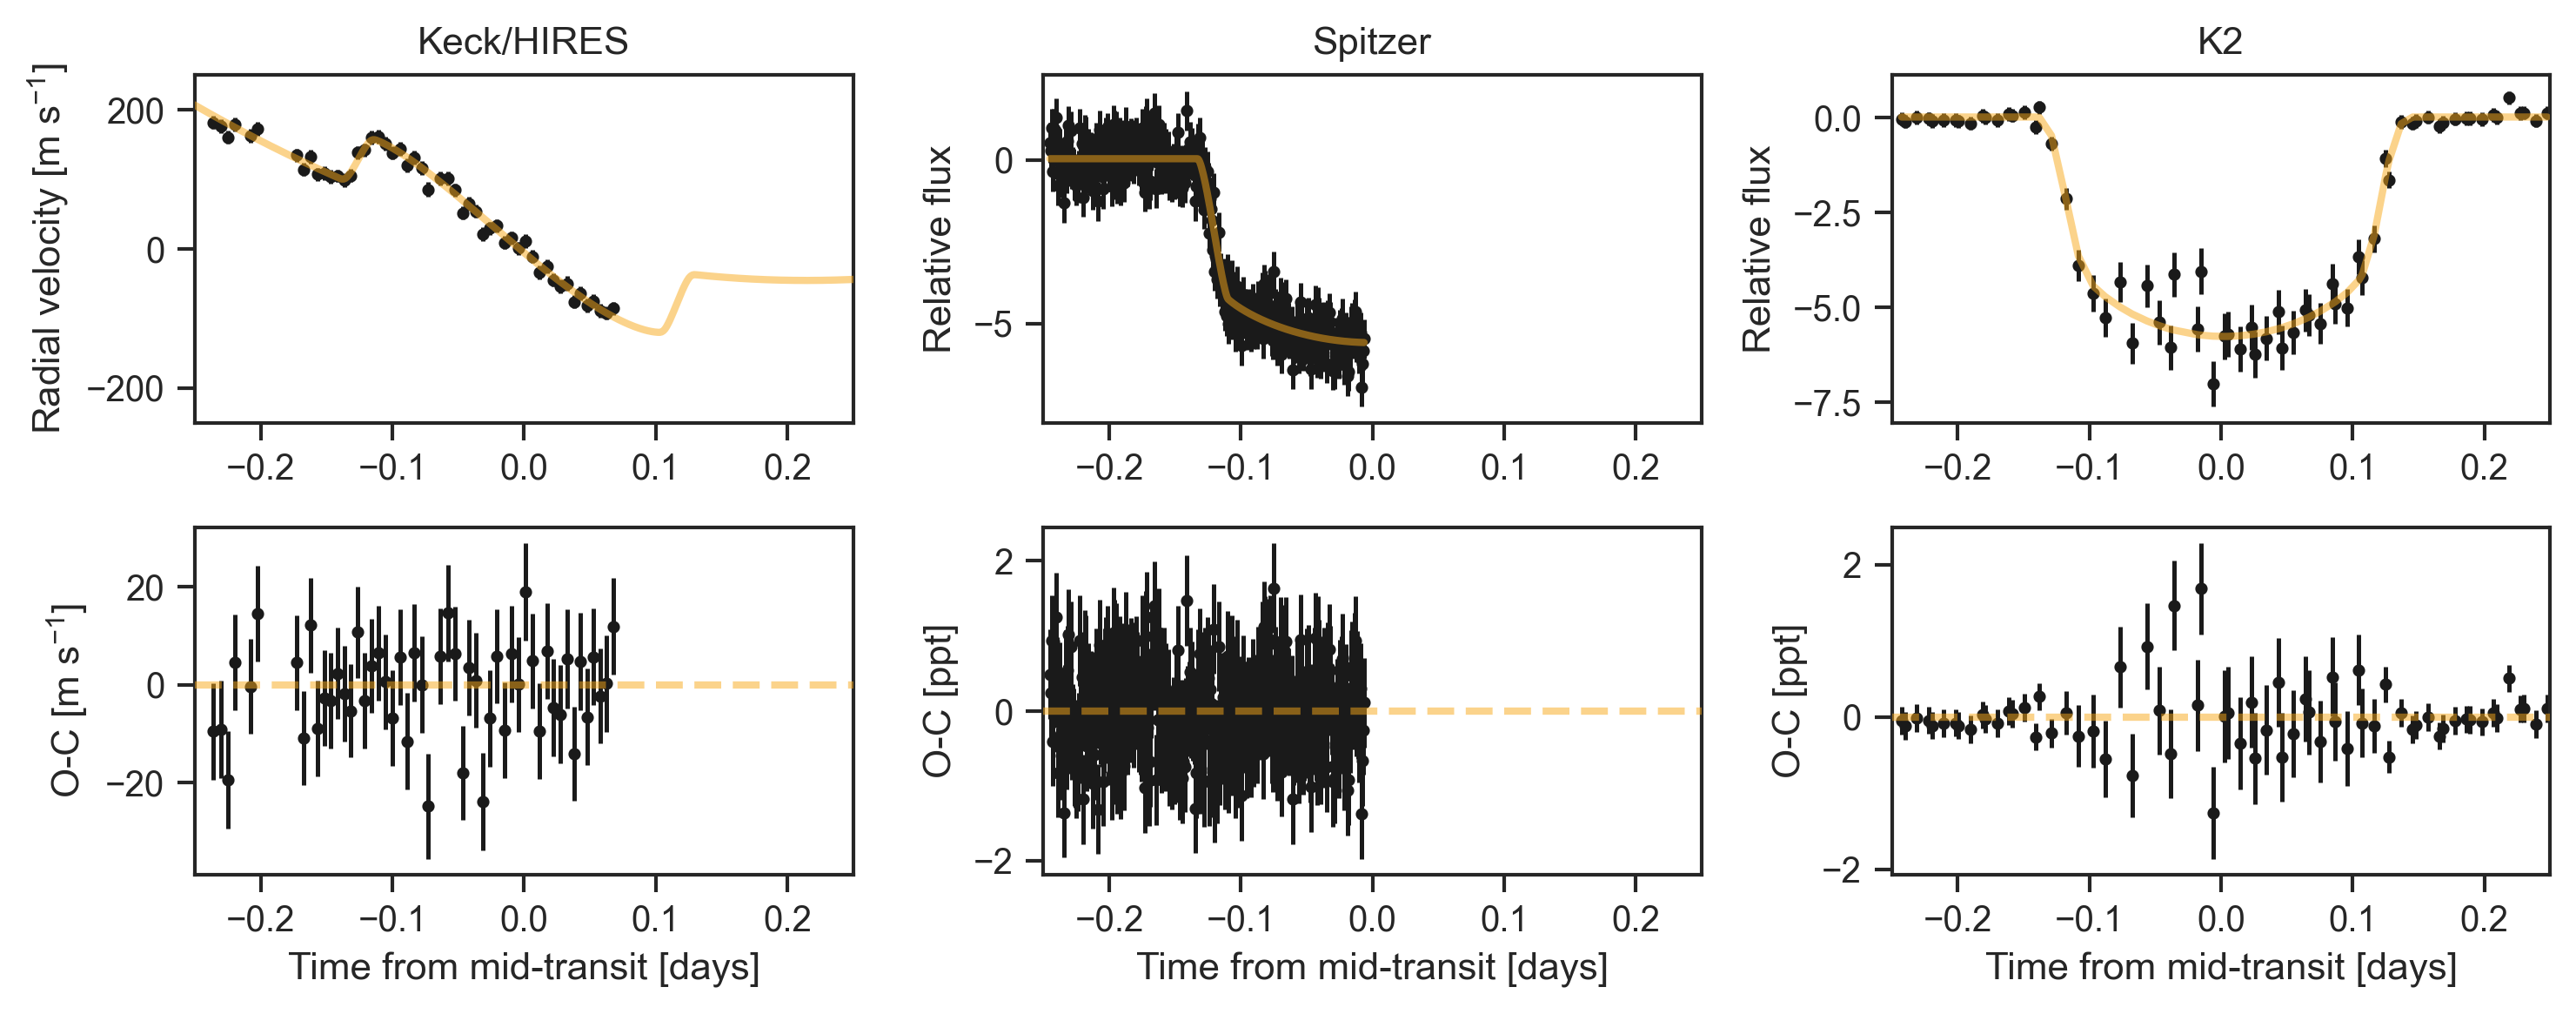

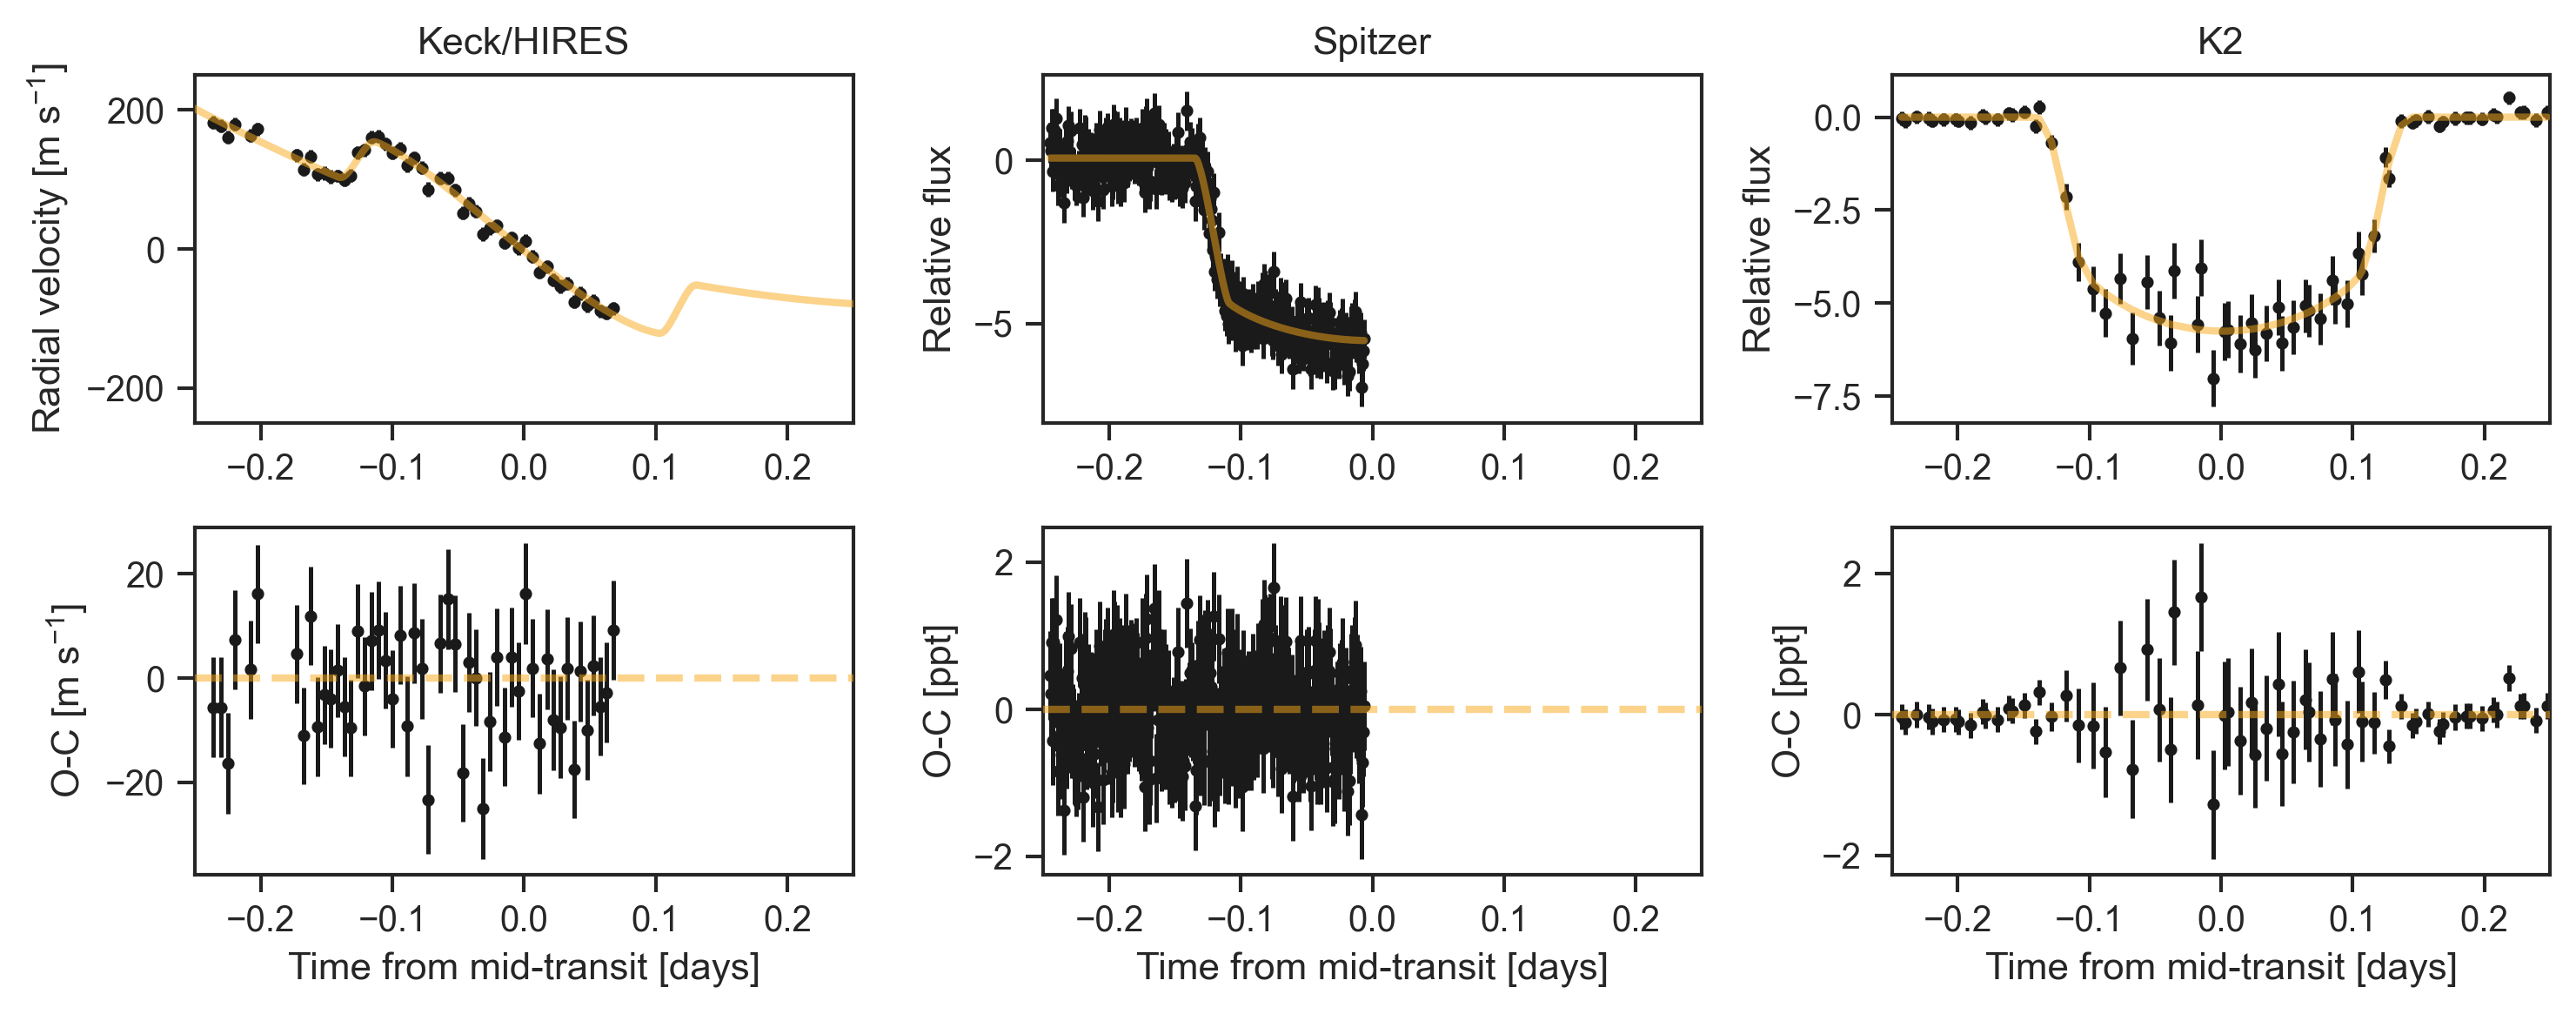

In [611]:
def plot_maxlogp_soln(trace, figpath=None):
    
    line_kws = {"lw": 2, "alpha": 0.5}
    
    maxlogp = np.argmax(trace['model_logp'])
    
    time_hires = np.linspace(-0.25,0.25,int(1e3))
    tfmt_hires = ((hires_time-trace['t0'][maxlogp]-0.5*trace['period'][maxlogp])%trace['period'][maxlogp]) - 0.5*trace['period'][maxlogp]

    lc_tfmt = ((ktwo_time-trace['t0'][maxlogp]-0.5*trace['period'][maxlogp])%trace['period'][maxlogp]) - 0.5*trace['period'][maxlogp]
    spitz_tfmt = ((spitz_time-trace['t0'][maxlogp]-0.5*trace['period'][maxlogp])%trace['period'][maxlogp]) - 0.5*trace['period'][maxlogp]
    
    arg = np.argsort(lc_tfmt)
    arg = np.argsort(tfmt_hires)

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=3, figsize=(10,4))

    ax1[0].set_title("Keck/HIRES")
    ax1[0].errorbar(hires_time, hires_rv, yerr=trace["err_rv"][maxlogp], color='k', fmt='.')
    ax1[0].plot(t_rv, trace["rv_model_pred"][maxlogp], "C1-", zorder=999, **line_kws)
    ax1[0].set_ylabel('Radial velocity [m s$^\mathregular{-1}$]')
    ax1[0].set_xlim(-0.25,0.25)
    ax1[0].set_ylim(-250,250)

    ax2[0].axhline(0, color="C1", ls='--', zorder=999, **line_kws)
    ax2[0].errorbar(hires_time, hires_rv-trace["rv_model"][maxlogp], yerr=trace["err_rv"][maxlogp], color='k', fmt='.')
    ax2[0].set_xlabel('Time from mid-transit [days]')
    ax2[0].set_ylabel(r'O-C [m s$^\mathregular{-1}$]')
    ax2[0].set_xlim(-0.25,0.25)

    ax1[1].set_title("Spitzer")
    ax1[1].errorbar(spitz_tfmt, spitz_flux, yerr=trace["err_spitz"][maxlogp], color='k', fmt='.')
    ax1[1].plot(spitz_tfmt, trace["light_curve_spitz"][maxlogp], "C1-", zorder=999, **line_kws)
    ax1[1].set_ylabel('Relative flux')
    ax1[1].set_xlim(-0.25,0.25)

    ax2[1].axhline(0, color="C1", ls='--', zorder=999, **line_kws)
    ax2[1].errorbar(spitz_tfmt, (spitz_flux-trace["light_curve_spitz"][maxlogp]), yerr=trace["err_spitz"][maxlogp], color='k', fmt='.')
    ax2[1].set_xlabel('Time from mid-transit [days]')
    ax2[1].set_ylabel(r'O-C [ppt]')
    ax2[1].set_xlim(-0.25,0.25)

    ax1[2].set_title("K2")
    ind = np.argsort(ktwo_tfmt)
    ax1[2].errorbar(ktwo_tfmt, ktwo_flux, yerr=trace["err_ktwo"][maxlogp], color='k', fmt='.')
    ax1[2].plot(ktwo_tfmt[ind], trace["light_curve"][maxlogp][ind], "C1-", zorder=999, **line_kws)
    ax1[2].set_ylabel('Relative flux')
    ax1[2].set_xlim(-0.25,0.25)

    ax2[2].axhline(0, color="C1", ls='--', zorder=999, **line_kws)
    ax2[2].errorbar(ktwo_tfmt, (ktwo_flux-trace["light_curve"][maxlogp]), yerr=trace["err_ktwo"][maxlogp], color='k', fmt='.')
    ax2[2].set_xlabel('Time from mid-transit [days]')
    ax2[2].set_ylabel(r'O-C [ppt]')
    ax2[2].set_xlim(-0.25,0.25)

    plt.tight_layout()
    if figpath:
        plt.savefig(figpath, bbox_inches='tight')
    plt.show()
    
    return

plot_maxlogp_soln(trace_line, '../figures/maxlogp_soln_line.pdf')
plot_maxlogp_soln(trace_line_protprio, '../figures/maxlogp_soln_line_protprio.pdf')
plot_maxlogp_soln(trace_quad, '../figures/maxlogp_soln_quad.pdf')
plot_maxlogp_soln(trace_quad_protprio, '../figures/maxlogp_soln_quad_protprio.pdf')

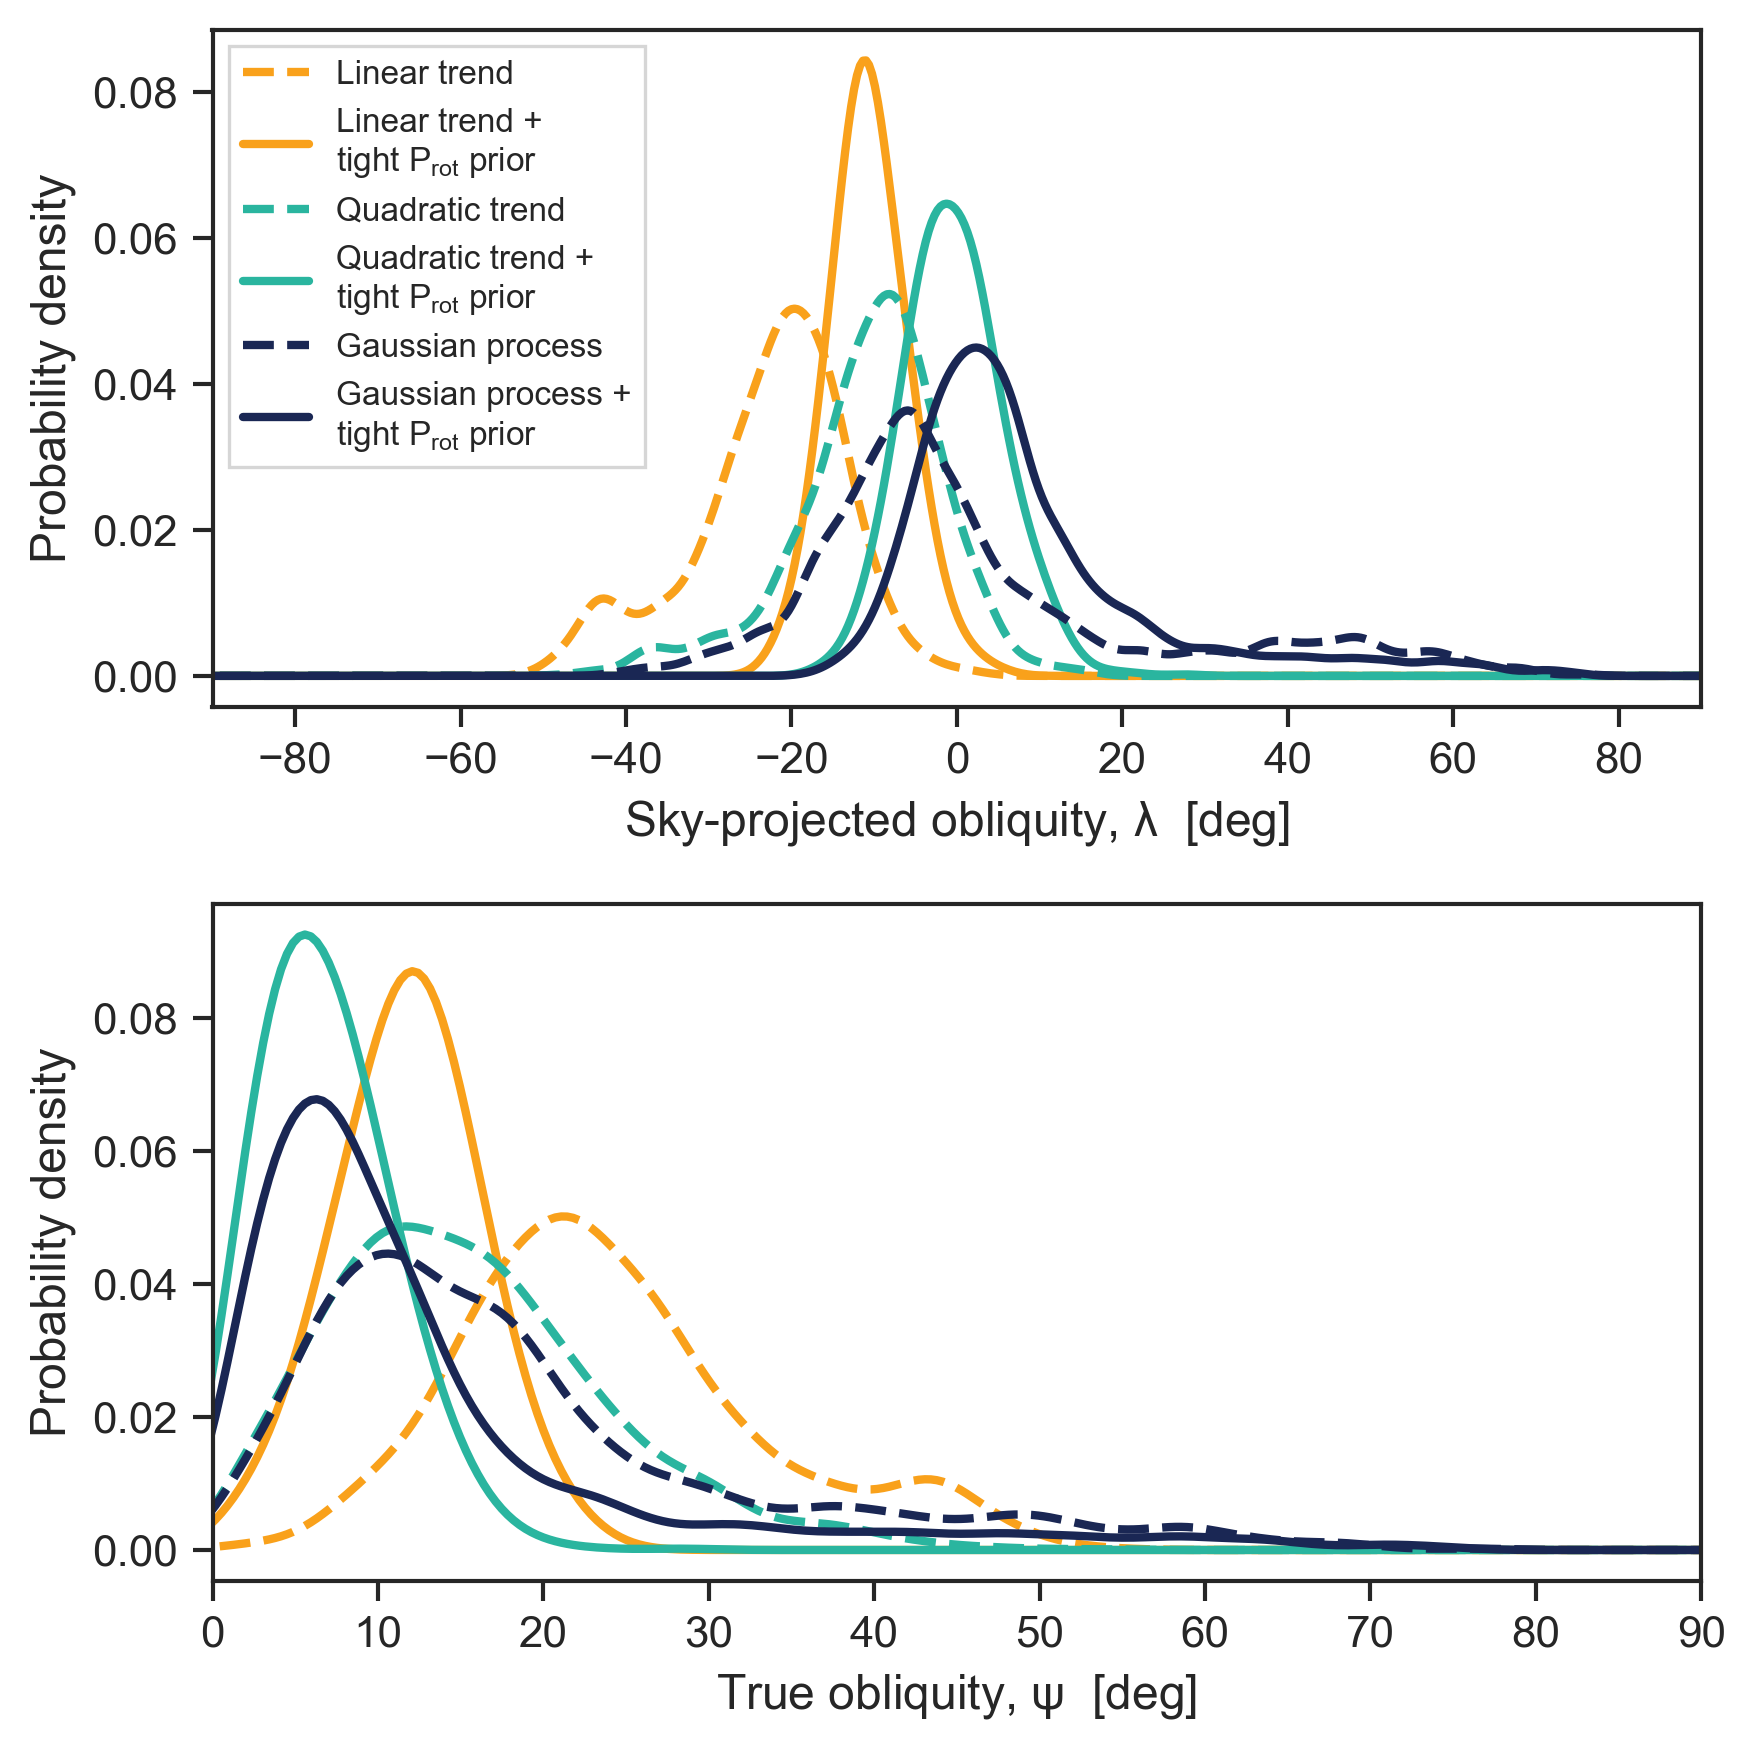

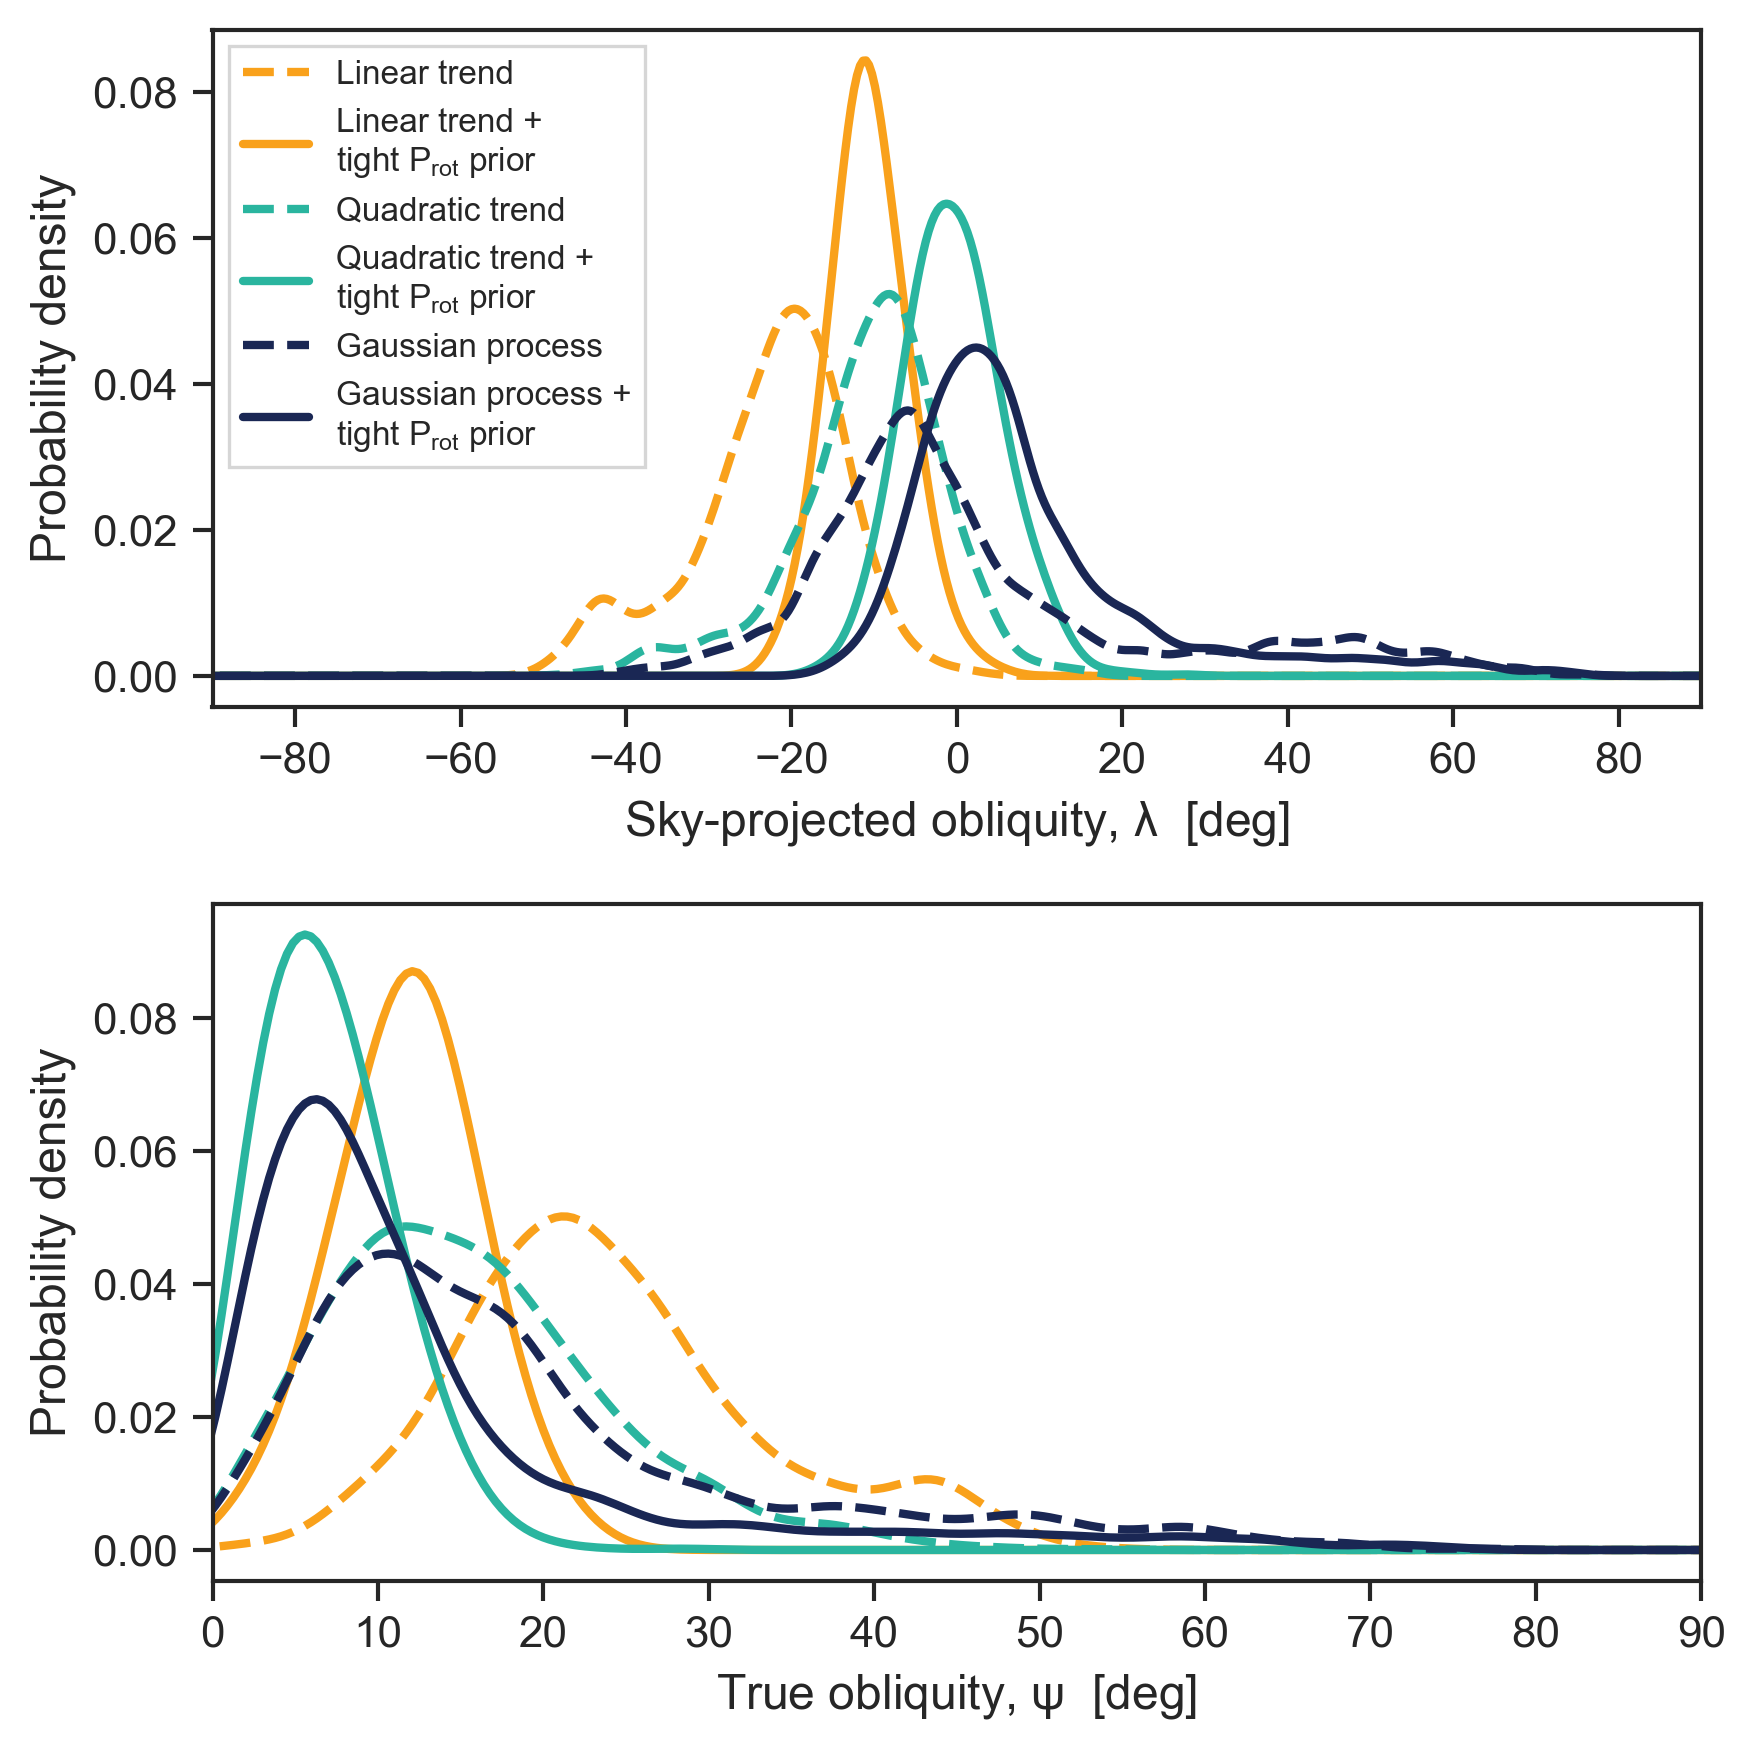

In [526]:
def plot_posterior_comparison(figpath=None, bandwidth=2, hist=False):

    linestyles = ["--","-"]
    colors = ['#f9a11b','#f9a11b', '#2ab59f', '#2ab59f', '#1a2754', '#1a2754']
    
    fig,(ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
    
    labels = ['Linear trend',
              'Linear trend +\ntight P$_\mathregular{rot}$ prior',
              'Quadratic trend',
              'Quadratic trend +\ntight P$_\mathregular{rot}$ prior',
              'Gaussian process',              
              'Gaussian process +\ntight P$_\mathregular{rot}$ prior',]
    
    for i,tr in enumerate([trace_line, trace_line_protprio,
                           trace_quad, trace_quad_protprio,
                           trace_gp_hires, trace_gp_protprio_hires]):

        
        
        psi = true_psi(tr['i_st'], tr['i_pl_deg'], tr['obliquity'])
        

        angle = np.linspace(-180,180,1000)
            
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(tr["obliquity"][:, np.newaxis])
        log_dens = kde.score_samples(angle[:, np.newaxis])
        ax1.plot(angle, np.exp(log_dens), lw=2, ls=linestyles[i%2], color=colors[i], label=labels[i])

        kde_psi = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(psi[:, np.newaxis])
        log_dens_psi = kde_psi.score_samples(angle[:, np.newaxis])
        ax2.plot(angle, np.exp(log_dens_psi), lw=2, ls=linestyles[i%2], color=colors[i], label=labels[i])
        
        if hist==True:
            ax1.hist(tr['obliquity'], bins=np.linspace(-180,180,200), histtype='step', lw=2, ls=linestyles[i%2], color=colors[i], density=True)
            ax2.hist(psi, bins=np.linspace(-180,180,200), histtype='step', lw=2, ls=linestyles[i%2], color=colors[i], density=True)            
        

    ax1.set_xlim(-90,90)
    ax2.set_xlim(0,90)
    
    ax1.legend(loc='upper left', prop={'size':8})
    ax1.set_xlabel(r'Sky-projected obliquity, $\mathregular{\lambda}$  [deg]')
    ax2.set_xlabel(r'True obliquity, $\mathregular{\psi}$  [deg]')
    
    for ax in [ax1,ax2]:
        ax.set_ylabel('Probability density')    
        
    plt.tight_layout()
    if figpath:
        plt.savefig(figpath, dpi=300, bbox_inches='tight')    
    plt.show()
    return

plot_posterior_comparison(figpath="../figures/obliquity_posterior_comparison.pdf")
plot_posterior_comparison(figpath="../figures/obliquity_posterior_comparison.jpg")

# Table 2: reported obliquities

In [452]:
model_names = ["Linear trend",
               "Linear trend, tight Prot prior",
               "Quadratic trend",
               "Quadratic trend, tight Prot prior",
               "Quasi-periodic GP",
               "Quasi-periodic GP, tight Prot prior",
               "Quasi-periodic GP (all instruments)",
               "Quasi-periodic GP, tight Prot prior (all instruments)"]

for i,tr in enumerate([trace_line, trace_line_protprio,
                       trace_quad, trace_quad_protprio,
                       trace_gp_hires, trace_gp_protprio_hires,
                       trace_gp, trace_gp_protprio]):
    
    _psi = true_psi(tr['i_st'],tr['i_pl_deg'],tr['obliquity'])
    _psi = np.array(_psi)
                
    _lambda_err = az.hdi(tr['obliquity'], hdi_prob=0.68)-np.median(tr['obliquity'])
    _psi_err = az.hdi(_psi, hdi_prob=0.68)-np.median(_psi)
    
    print(model_names[i],'&',
          str(round(np.median(tr['obliquity'])))+'$_{'+str(round(_lambda_err[0]))+'}^{+'+str(round(_lambda_err[1]))+'}$ & '
          +str(round(np.median(_psi)))+'$_{'+str(round(_psi_err[0]))+'}^{+'+str(round(_psi_err[1]))+'}$ \\\\')


Linear trend & -21$_{-7}^{+9}$ & 23$_{-8}^{+8}$ \\
Linear trend, tight Prot prior & -11$_{-4}^{+5}$ & 12$_{-4}^{+5}$ \\
Quadratic trend & -9$_{-7}^{+9}$ & 14$_{-9}^{+6}$ \\
Quadratic trend, tight Prot prior & -1$_{-6}^{+5}$ & 6$_{-4}^{+4}$ \\
Quasi-periodic GP & -4$_{-16}^{+12}$ & 15$_{-12}^{+7}$ \\
Quasi-periodic GP, tight Prot prior & 5$_{-12}^{+7}$ & 8$_{-7}^{+4}$ \\
Quasi-periodic GP (all instruments) & 8$_{-24}^{+21}$ & 16$_{-15}^{+11}$ \\
Quasi-periodic GP, tight Prot prior (all instruments) & 9$_{-15}^{+10}$ & 11$_{-11}^{+6}$ \\


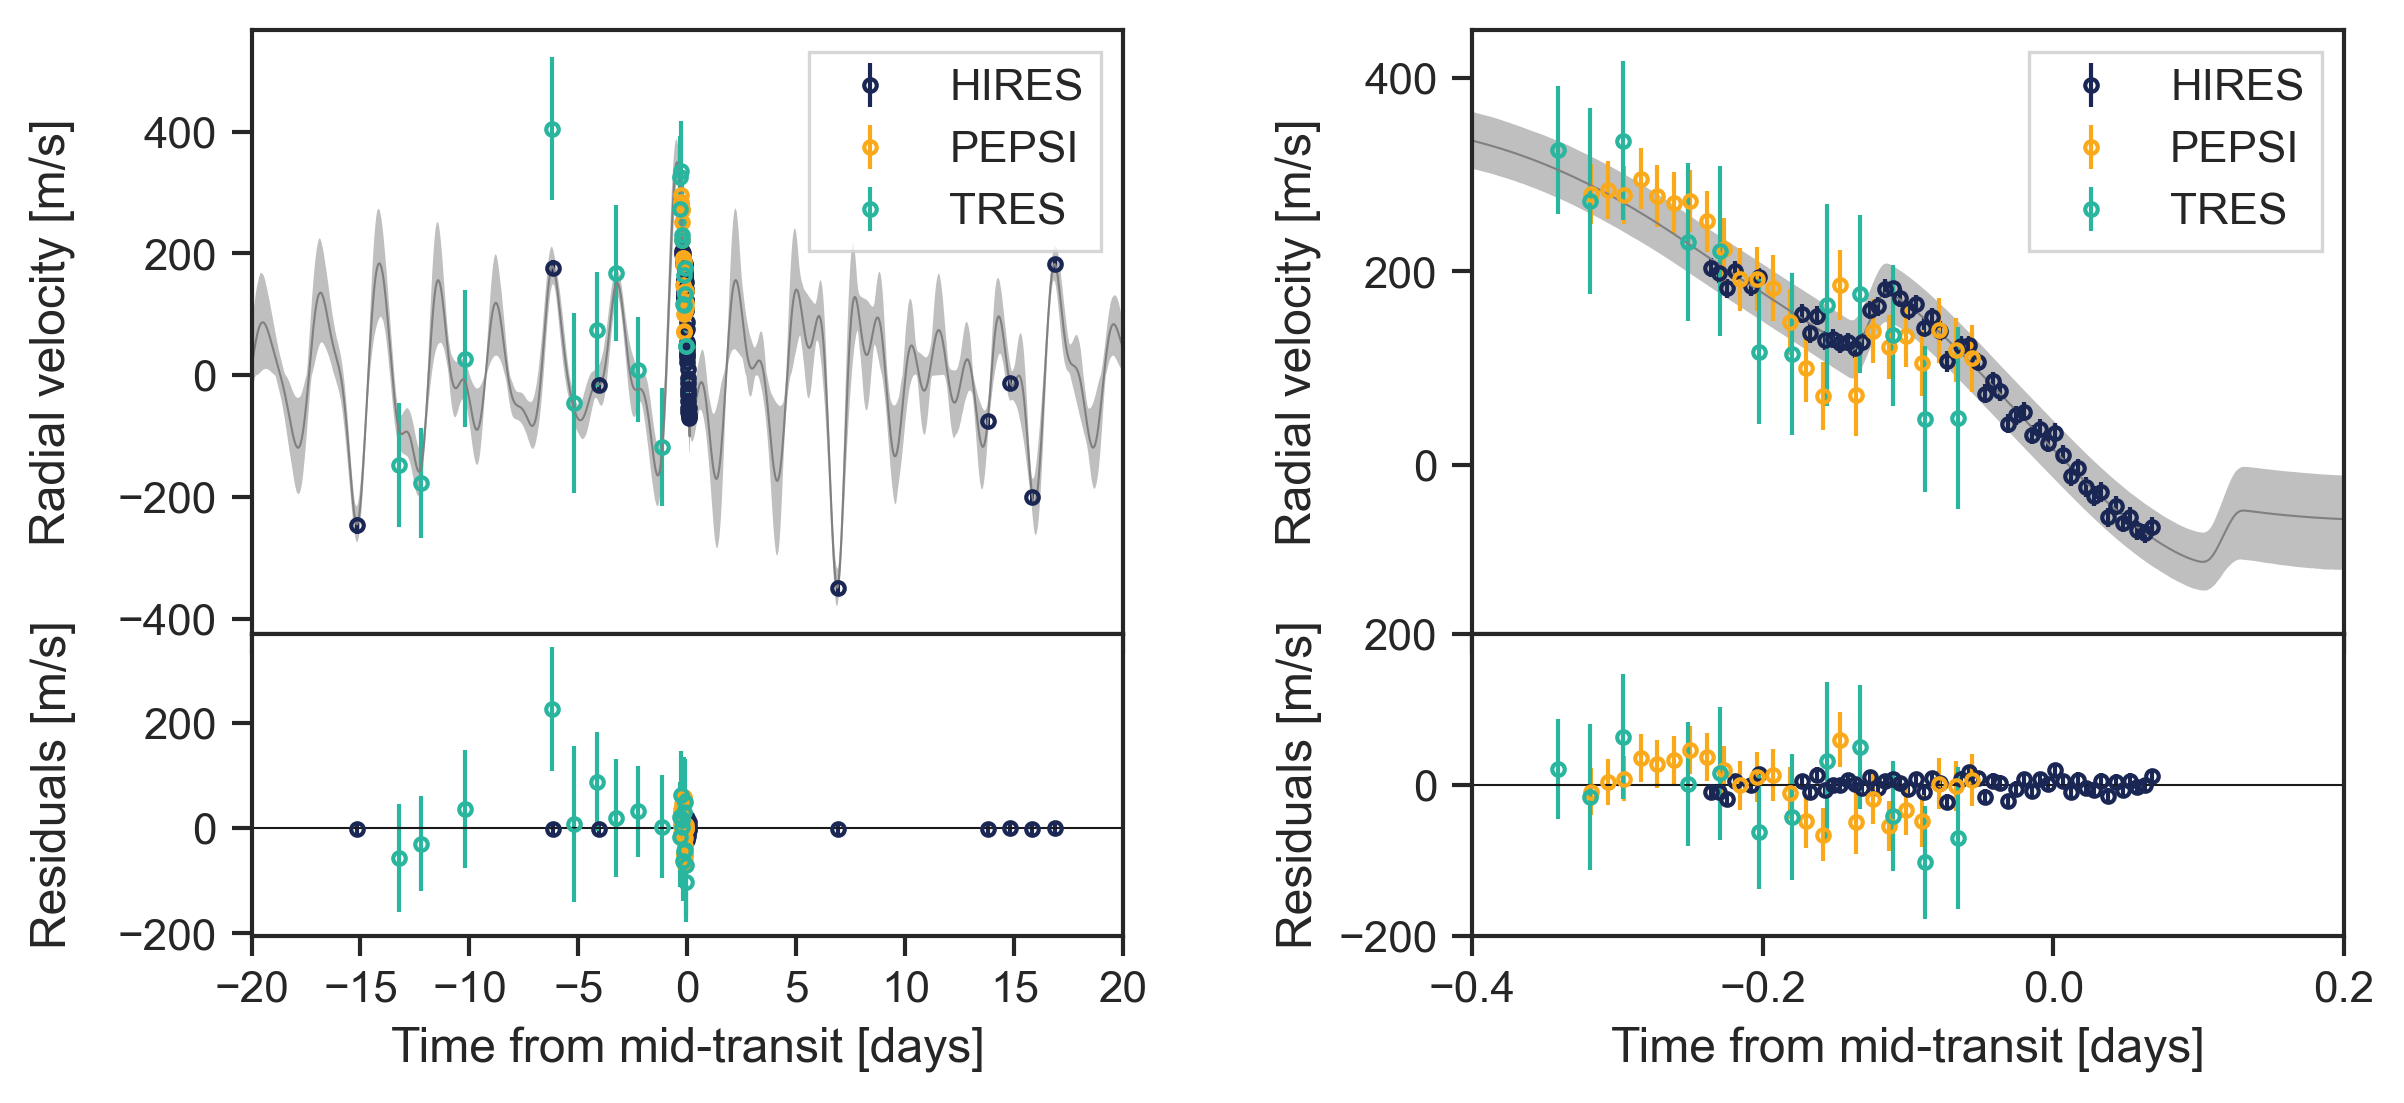

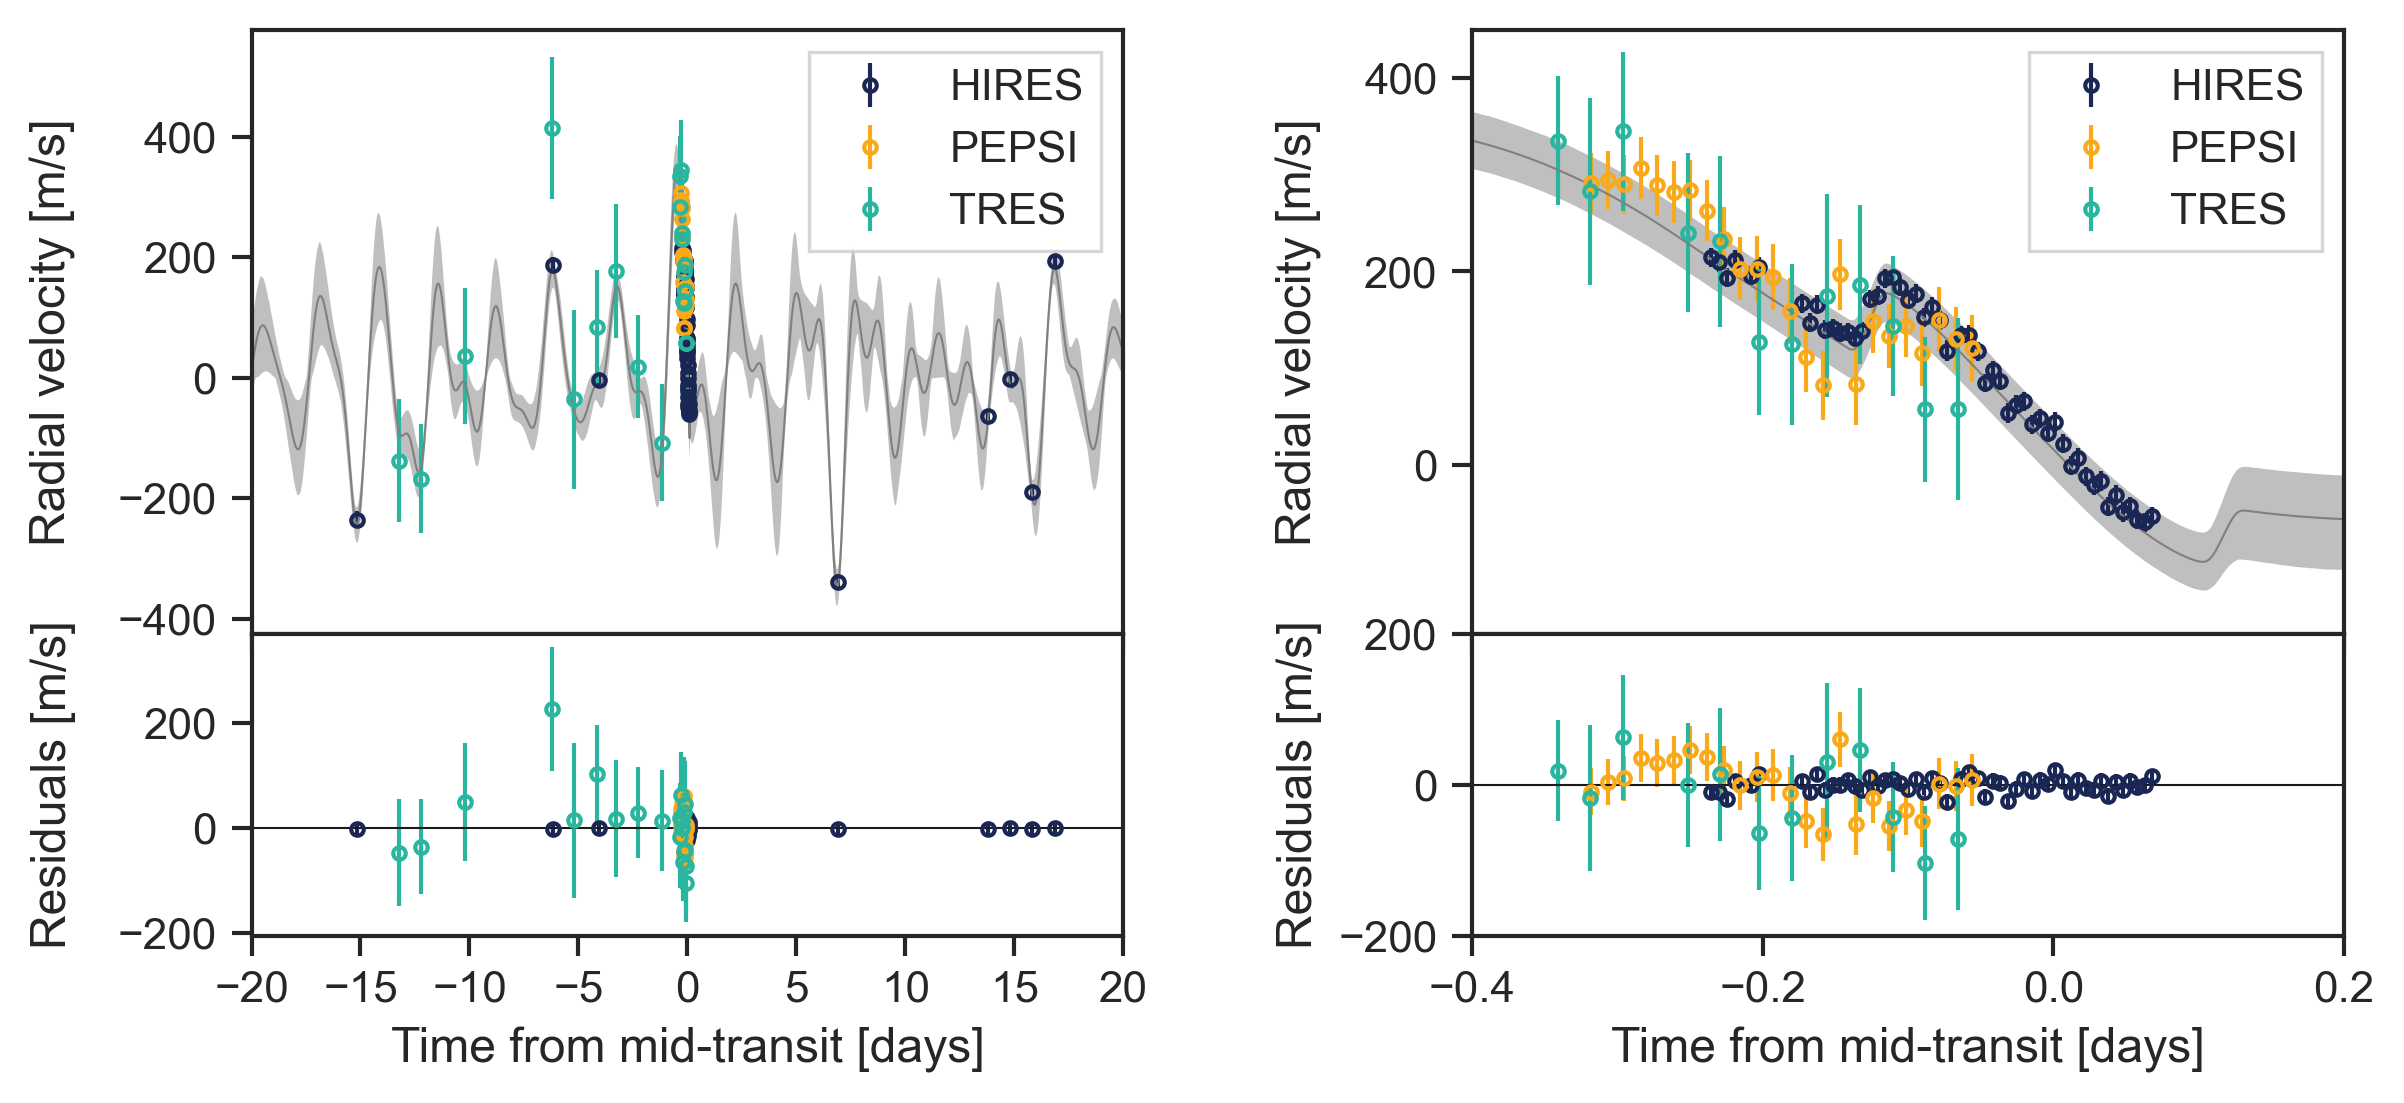

In [397]:
plot_gp_trace(trace_gp, mask=all_rm)
#plot_gp_trace(trace_gp, mask=all_rm, figpath="./figures/gp-rm-fit.pdf")
plot_gp_trace(trace_gp_protprio, mask=all_rm)
#plot_gp_trace(trace_gp_hires, model_gp_hires, mask=hires_rm)

# print(np.shape(trace_gp["mean_rv"]))
# print(np.shape(trace_gp["rm_curve"]))
# print(np.shape(trace_gp["gp_rv"]))

In [181]:
#maxlogp = np.argmax(trace_line['model_logp'])
#print(trace_line['obliquity'][maxlogp])
#print(trace_line['model_logp'][maxlogp])

maxlogp = np.argmax(trace_quad['model_logp'])
print(trace_quad['obliquity'][maxlogp])
print(trace_quad['model_logp'][maxlogp])

# maxlogp = np.argmax(trace_line_protprio['model_logp'])
# print(trace_line_protprio['obliquity'][maxlogp])
# print(trace_line_protprio['model_logp'][maxlogp])

maxlogp = np.argmax(trace_quad_protprio['model_logp'])
print(trace_quad_protprio['obliquity'][maxlogp])
print(trace_quad_protprio['model_logp'][maxlogp])

maxlogp = np.argmax(trace_gp_protprio_hires['model_logp'])
print(trace_gp_protprio_hires['obliquity'][maxlogp])
print(trace_gp_protprio_hires['model_logp'][maxlogp])

#denom = np.max(trace_line['model_logp'])
denom = np.max(trace_quad['model_logp'])

#trace_line, trace_line_protprio, 

for tr in [trace_quad, trace_quad_protprio,
           trace_gp, trace_gp_protprio, trace_gp_hires, trace_gp_protprio_hires]:
    print(np.max(tr['model_logp'])/denom)


# print('Linear Bayes factor:', np.max(trace_line['model_logp'])/denom)
# print('Quad Bayes factor:', np.max(trace_quad['model_logp'])/denom)
# print('Linear Prot prior Bayes factor:', np.max(trace_line_protprio['model_logp'])/denom)
# print('Quad Prot prior Bayes factor:', np.max(trace_quad_protprio['model_logp'])/denom)

-11.865105945731404
-557.9874269316042
-4.703398927472379
-559.0064985673002
15.792252982971553
-549.5972399382565
1.0
1.0018263344055975
1.5359073826973082
1.5356622924459864
0.98379862120905
0.98496348378406


# Comparison between inferred impact parameter and a/R* 

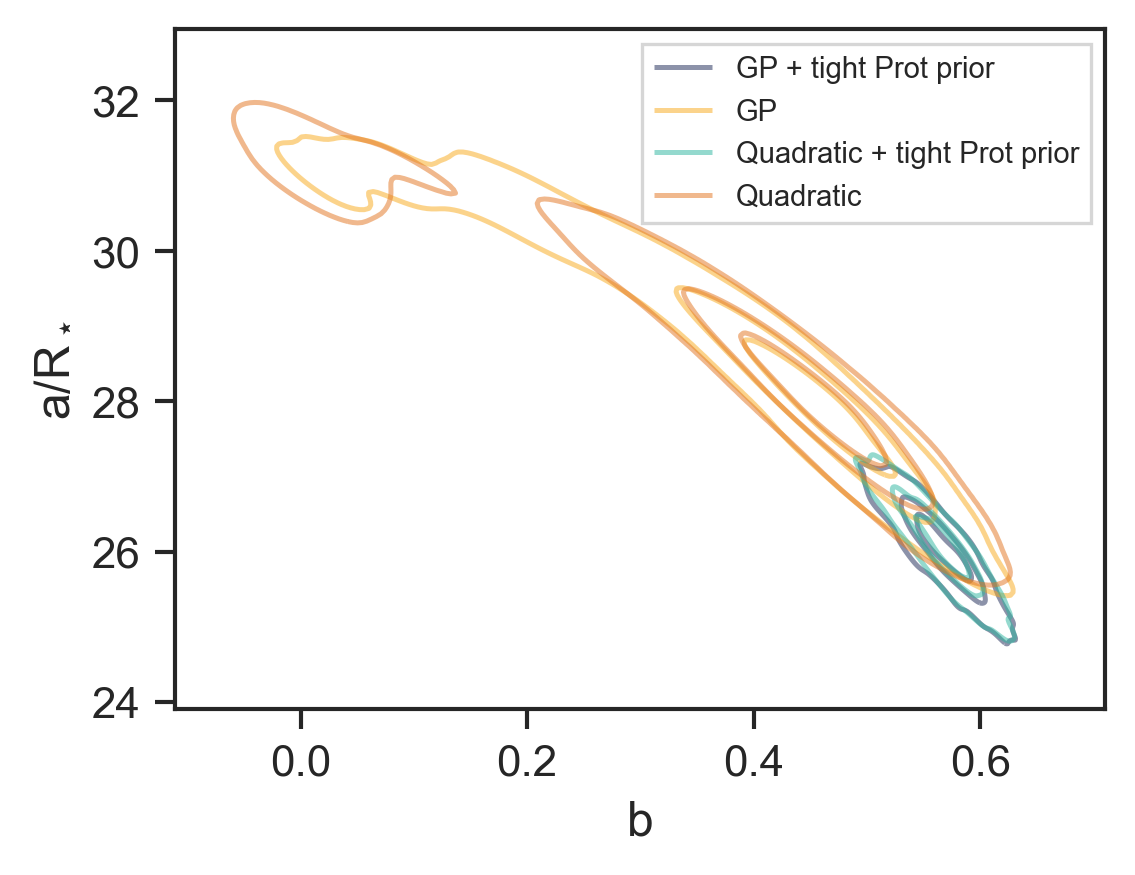

In [506]:
sns.kdeplot(x=trace_gp_protprio_hires["b"], y=trace_gp_protprio_hires["a_r"], label='GP + tight Prot prior', **kde_kws)
sns.kdeplot(x=trace_gp_hires["b"], y=trace_gp_hires["a_r"], label='GP', **kde_kws)
sns.kdeplot(x=trace_quad_protprio["b"], y=trace_quad_protprio["a_r"], label='Quadratic + tight Prot prior', **kde_kws)
sns.kdeplot(x=trace_quad["b"], y=trace_quad["a_r"], label='Quadratic', **kde_kws)
plt.legend(prop={'size':7})
plt.xlabel('b')
plt.ylabel('a/R$_\star$')
plt.show()